# **NEEDED LIBRARIES IMPORT**

In [ ]:
!pip install pytube
 
from pytube import YouTube
import os
import dill
import random
import itertools
import math
 
from scipy import stats
import numpy as np
from numpy.random import RandomState
import pandas as pd
import matplotlib.pyplot as plt
 
import librosa
import librosa.display
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.utils import shuffle
 
import torch.nn as nn 
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
 
from google.colab import drive
 
from tqdm import tqdm

# **DECLARATION OF USEFUL CLASSES/METHODS**

## **DATASET IMPORT/UNZIP**

In [ ]:
import os
import tarfile
import zipfile

def extract_file(path, to_directory='.'):
    opener, mode = tarfile.open, 'r:gz'
    cwd = os.getcwd()
    os.chdir(to_directory)

    try:
        file = opener(path, mode)
        try: file.extractall()
        finally: file.close()
    finally:
        os.chdir(cwd)

## **AUDIO CONVERSION INTO SPECTROGRAMS AND DATA AUGMENTATION**

In [ ]:
def create_dataset_gtzan(genre_folder='artists', save_folder='song_data',
                        sr=22050, n_mels=128,
                        n_fft=2048, hop_length=512,pitch_v=[1],noise_v=[1]):
    """This function creates the dataset given a folder
     with the correct structure (genres/*.mp3)
    and saves it to a specified folder.
    Moreover, it also generates augmented data."""
    def manipulate(data, sampling_rate, pitch_factor):
      return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    
    def manipulite(data, noise_factor):
      noise = np.random.randn(len(data))
      augmented_data = data + noise_factor * noise
      # Cast back to same data type
      augmented_data = augmented_data.astype(type(data[0]))
      return augmented_data

    # get list of all genres
    os.makedirs(save_folder, exist_ok=True)
    genres = [path for path in os.listdir(genre_folder) if
              not path.endswith('.mf')]
    
    # iterate through all genres, songs and find mel spectrogram
    for genre in genres:
        print(genre)
        genre_path = os.path.join(genre_folder, genre)
        genre_songs = os.listdir(genre_path)

        for song in genre_songs:
          song_path = os.path.join(genre_path, song)
          augmentation = False
          # Create mel spectrogram and convert it to the log scale
          y, sr = librosa.load(song_path, sr=sr)
          S = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels,
                                                   n_fft=n_fft,
                                                   hop_length=hop_length)
          log_S = librosa.amplitude_to_db(S)
          data = (genre, log_S, song, augmentation)

          # Save each song, plus its augmented forms
          save_name = genre + '_%%-%%_' + song
          with open(os.path.join(save_folder, save_name), 'wb') as fp:
              dill.dump(data, fp)
            
          for d in pitch_v:
            y_pitch = manipulate(y, sampling_rate=sr, pitch_factor=d)
            S = librosa.feature.melspectrogram(y_pitch, sr=sr, n_mels=n_mels,
                                             n_fft=n_fft,
                                             hop_length=hop_length)
            log_S = librosa.amplitude_to_db(S)
            augmentation = True
            data = (genre, log_S, song, augmentation)
            save_name = genre + '_%%-%%_' + song +"aug_pitch_"+ str(d)
            with open(os.path.join(save_folder, save_name), 'wb') as fp:
              dill.dump(data, fp)

          for d in noise_v:
            y_noise = manipulite(y,noise_factor=d)
            S = librosa.feature.melspectrogram(y_noise, sr=sr, n_mels=n_mels,
                                             n_fft=n_fft,
                                             hop_length=hop_length)
            log_S = librosa.amplitude_to_db(S)
            augmentation = True
            data = (genre, log_S, song, augmentation)
            save_name = genre + '_%%-%%_' + song +"aug_noise_"+str(d)
            with open(os.path.join(save_folder, save_name), 'wb') as fp:
              dill.dump(data, fp)


In [ ]:
def load_ds_gtzan(song_folder_name='/content/song_data'):

  """Import spectrograms into in-ambient variables"""
  
  song_list = os.listdir(song_folder_name)
  genres, spectros, song_names, augmentation = [], [], [], []
  pbar = tqdm(total=len(song_list), desc="Loading from the folder")
  for i,song in enumerate(song_list):
    
    with open(os.path.join(song_folder_name, song), 'rb') as fp:
      loaded_song = dill.load(fp)
      genres.append(loaded_song[0])
      spectros.append(loaded_song[1])
      song_names.append(loaded_song[2])
      augmentation.append(loaded_song[3])
    pbar.update(1)
  pbar.close()


  return genres, spectros, song_names, augmentation

##**DATA PREPARATION: SLICE INTO TIME INTERVALS, SPLIT INTO TRAIN/TEST/VAL**

In [ ]:
def slice_songs_gtzan(X, Y, S, length=911):
    """Slices the spectrogram into sub-spectrograms according to length"""

    # Create empty lists for train and test sets
    genre = []
    spectrogram = []
    song_name = []

    # Slice up songs using the length specified
    for i, song in enumerate(X):
      
      if song.shape[1]>938:
        song = song[:, :938]

      slices = int(song.shape[1] / length)
      if slices>1:
        for j in range(slices):
            spectrogram.append(song[:, length * j:length * (j + 1)])
            genre.append(Y[i])
            song_name.append(S[i])
      else:
        spectrogram.append(song[:, 0:length])
        genre.append(Y[i])
        song_name.append(S[i])
      
    return np.array(spectrogram), np.array(genre), np.array(song_name)

In [ ]:
def remove_augmented(X,Y,S,D):

  spectros, genres, names, augm = [], [], [], []

  for x,y,s,d in zip(X,Y,S,D):
    if not d:
      spectros.append(x)
      genres.append(y)
      names.append(s)
      augm.append(d)

  return spectros,genres,names,augm


In [ ]:
def split_ds(Y,X,S,D,test_split_size,random_state=42,all_train=False):
  
  XnoAug,YnoAug,SnoAug,DnoAug = remove_augmented(X, Y, S, D)
  X_train,X_test,Y_train,Y_test,S_train,S_test, D_train, D_test = train_test_split(XnoAug,YnoAug,SnoAug,DnoAug, test_size=test_split_size, random_state = random_state, stratify=YnoAug)
  if(all_train):

    X_val,Y_val,S_val, D_val=X_test,Y_test,S_test,D_test

  else:
    X_train,X_val,Y_train,Y_val,S_train,S_val, D_train, D_val = train_test_split(X_train, Y_train, S_train, D_train, test_size=test_split_size, random_state = random_state, stratify=Y_train)
  
  X_tr, Y_tr, S_tr, D_tr = [], [], [], []

  for x,y,s,d in zip(X, Y, S, D):
    if s in S_train:
      X_tr.append(x)
      Y_tr.append(y)
      S_tr.append(s)
      D_tr.append(d)
  
  X_tr, Y_tr, S_tr, D_tr = shuffle(X_tr, Y_tr, S_tr, D_tr, random_state=42)

  return X_tr,Y_tr,S_tr,D_tr,X_test,Y_test,S_test,D_test,X_val,Y_val,S_val,D_val,S

def encode_labels_linear(Y, le=None):
  """Encodes target variables into numbers"""
  if le is None:
      le = preprocessing.LabelEncoder()
      Y_le = le.fit_transform(Y)
  else:
      Y_le = le.transform(Y)
  return Y_le, le

## **MODEL DECLARATION**

### **ARCHITECTURE**

In [ ]:
class CRNN(nn.Module):

    def __init__(self, img_channel, img_height, img_width, num_class,
                 map_to_seq_hidden=64, rnn_hidden=256, leaky_relu=False):
        super(CRNN, self).__init__()


        self.cnn, (output_channel, output_height, output_width) = \
            self._cnn_backbone(img_channel, img_height, img_width)

        self.rec1 = nn.GRU(output_channel*output_height*output_width,10, bidirectional=True)
        self.rec2 = nn.GRU(20,num_class, bidirectional=False)
        self.drop_final = nn.Dropout(.3)
        self.dense = nn.Linear(10,10)

    def _cnn_backbone(self, img_channel, img_height, img_width):

        channels = [img_channel, 64, 128, 128, 128, 128]
        kernel_sizes = (3,3) 
        pool_sizes = [(2, 2), (4, 2), (4, 2), (4, 2), (1, 2)]  # size of pooling area


        cnn = nn.Sequential()

        def conv_elu(i):
            # shape of input: (batch, input_channel, height, width)
            input_channel = channels[i]
            output_channel = channels[i+1]

            cnn.add_module(
                f'conv{i}',
                nn.Conv2d(input_channel, output_channel, kernel_sizes, padding=1)
            )

            elu = nn.ELU() 
            cnn.add_module(f'elu{i}', elu)

            cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(output_channel))

            cnn.add_module(f'pooling{i}', nn.MaxPool2d(kernel_size=pool_sizes[i]))

            cnn.add_module(f'dropout{i}', nn.Dropout(0.1))


        # size of image: (channel, height, width) = (img_channel, img_height, img_width)
        cnn.add_module(f'batchnorm_initial', nn.BatchNorm2d(img_channel))

        conv_elu(0)

        conv_elu(1)

        conv_elu(2)

        conv_elu(3)

        conv_elu(4)


        def compute_dims(dim_in, kernel_dim):
          h_old = dim_in[0]
          w_old = dim_in[1]

          h_new = math.floor((h_old-(kernel_dim[0]-1)-1)/kernel_dim[0] + 1)
          w_new = math.floor((w_old-(kernel_dim[1]-1)-1)/kernel_dim[1] + 1)

          return (h_new, w_new)
        
        output_channel = channels[-1]
        output_height, output_width = compute_dims(compute_dims(compute_dims(compute_dims(compute_dims((img_height, img_width), pool_sizes[0]), pool_sizes[1]), pool_sizes[2]), pool_sizes[3]), pool_sizes[4])
        return cnn, (output_channel, output_height, output_width)



    def forward(self, images):
        # shape of images: (batch, channel, height, width)
        torch.cuda.empty_cache()
        
        conv = self.cnn(images)
        
        batch, channel, height, width = conv.size()
        conv = conv.reshape(batch, channel * width,height ).permute(0,2,1)
        
        conv, _ = self.rec1(conv)
        
        conv, _ = self.rec2(conv)
  
        conv = self.drop_final(conv)
        
    
        conv = self.dense(conv)
        
        return conv
        del conv

### **DATASET IMPLEMENTATION (SUITED FOR BATCH DIVISION)**

In [ ]:
class GTZANDataset(Dataset):

    CHARS = ['country','jazz','blues','reggae','disco','pop','classical','rock','metal','hiphop']
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

    def __init__(self, X,Y,S, root_dir=None, mode=None, paths=None):

        self.paths = S
        self.labels = Y
        self.texts = X
        self.img_height = X.shape[2]
        self.img_width = X.shape[3]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):

      return self.texts[index], self.labels[index]


### **EARLY STOPPING**

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=True, delta=0, path='checkpoints/last.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### **USEFUL NETWORK METHODS**

In [ ]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()
    images, targets= [d.to(device) for d in data]
    
    logits = torch.cuda.FloatTensor(crnn(images)).requires_grad_().to(device)

    reshaped_l = torch.as_tensor(logits.reshape(logits.shape[0],(logits.shape[1]*logits.shape[2])))
    
    loss = criterion(reshaped_l.to(device), targets.reshape(targets.shape[0]*targets.shape[1]).to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(crnn, dataloader, criterion,
             max_iter=None):
    crnn.eval()

    tot_count = 0
    tot_loss = 0
    tot_correct = 0
    wrong_cases = []
    all_reals, all_preds = [],[]

    pbar_total = max_iter if max_iter else len(dataloader)
    pbar = tqdm(total=pbar_total, desc="Evaluate")

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if max_iter and i >= max_iter:
                break
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, targets = [d.to(device) for d in data]

            logits = torch.cuda.FloatTensor(crnn(images)).requires_grad_().to(device)

            reshaped_l = torch.as_tensor(logits.reshape(logits.shape[0],(logits.shape[1]*logits.shape[2])))
            
            loss = criterion(reshaped_l.to(device), targets.reshape(targets.shape[0]*targets.shape[1]).to(device))

            preds = [np.argmax(log.cpu()) for log in logits]
            reals = targets.cpu().numpy().tolist()

            batch_size = targets.shape[0]
            tot_count += batch_size
            tot_loss += loss.item()
            all_reals += reals
            all_preds += preds


            pbar.update(1)
        pbar.close()
    acc = f1_score(all_reals, all_preds, average='weighted')    
    evaluation = {
        'loss': tot_loss / tot_count,
        'acc': acc,
        'wrong_cases': wrong_cases
    }
    return evaluation

In [ ]:
def predict(crnn, dataloader):
    crnn.eval()
    pbar = tqdm(total=len(dataloader), desc="Predict")

    all_preds = []
    all_targets=[]
    with torch.no_grad():
        for data in dataloader:
            device = 'cuda' if next(crnn.parameters()).is_cuda else 'cpu'

            images, target = [f.to(device) for f in data]

            logits = crnn(images)
            preds=[np.argmax(log.cpu()) for log in logits]

            all_preds += preds
            all_targets += target.cpu()
            

            pbar.update(1)
        pbar.close()

    return all_preds, all_targets

## **FULL TRAIN/EVALUATION FUNCTION**

In [ ]:
def train_model(slice_len, random_state, X, Y, S, D, final=False):

  def train_actual():

    assert save_interval % valid_interval == 0
    i = 1
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(1, epochs + 1):
        print(f'epoch: {epoch}')
        tot_train_loss = 0.
        tot_train_count = 0
        for train_data in train_loader:
            loss = train_batch(crnn, train_data, optimizer, criterion, device)
            train_size = train_data[0].size(0)
            tot_train_loss += loss
            tot_train_count += train_size
            if i % show_interval == 0:
                    print('train_batch_loss[', i, ']: ', loss / train_size)

            if i % valid_interval == 0:
                evaluation = evaluate(crnn, valid_loader, criterion)
                print('valid_evaluation: loss = {loss}, acc = {acc}'.format(**evaluation))
                loss_val = evaluation['loss']

                if i % save_interval == 0:
                  prefix = 'crnn'
                  save_model_path = os.path.join(checkpoints_dir, f'{prefix}_{i:06}_acc{evaluation["acc"]}.pt')
                  torch.save(crnn.state_dict(), save_model_path)
                  print('save model at ', save_model_path)

                early_stopping(loss_val, crnn)
            i += 1
        print('train_loss: ', tot_train_loss / tot_train_count)

        if early_stopping.early_stop:
          print("Early stopping")
          break

  print(f'Current trial: slice_length = {slice_len}; random_state = {random_state}')

  Xa,Ya,Sa,Da,Xb,Yb,Sb,Db,Xc,Yc,Sc,Dc,Name_song = split_ds(Y,X,S,D , 0.1,all_train=False, random_state = random_state)
  
  X_sliced_training, Y_sliced_training, S_sliced_training = slice_songs_gtzan(Xa,Ya,Sa,slice_len)
  X_sliced_test, Y_sliced_test, S_sliced_test = slice_songs_gtzan(Xb,Yb,Sb,slice_len)
  X_sliced_val, Y_sliced_val, S_sliced_val = slice_songs_gtzan(Xc,Yc,Sc,slice_len)

  X_sliced_training = X_sliced_training.reshape(X_sliced_training.shape + (1,))
  X_sliced_test = X_sliced_test.reshape(X_sliced_test.shape + (1,))
  X_sliced_val = X_sliced_val.reshape(X_sliced_val.shape + (1,))

  X_sliced_training = torch.from_numpy(X_sliced_training).permute(0,3,1,2).cuda()
  X_sliced_test = torch.from_numpy(X_sliced_test).permute(0,3,1,2).cuda()
  X_sliced_val = torch.from_numpy(X_sliced_val).permute(0,3,1,2).cuda()

  Y_sliced_enc_training, le = encode_labels_linear(Y_sliced_training)
  Y_sliced_enc_test, le = encode_labels_linear(Y_sliced_test, le)
  Y_sliced_enc_val, le = encode_labels_linear(Y_sliced_val, le)

  Y_sliced_enc_training = torch.from_numpy(Y_sliced_enc_training).reshape(Y_sliced_enc_training.shape + (1,))
  Y_sliced_enc_test = torch.from_numpy(Y_sliced_enc_test).reshape(Y_sliced_enc_test.shape + (1,))
  Y_sliced_enc_val = torch.from_numpy(Y_sliced_enc_val).reshape(Y_sliced_enc_val.shape + (1,))

  S_sliced_training = np.asarray(S_sliced_training).reshape((S_sliced_training.shape[0],1))
  S_sliced_test = np.asarray(S_sliced_test).reshape((S_sliced_test.shape[0],1))
  S_sliced_val = np.asarray(S_sliced_val).reshape((S_sliced_val.shape[0],1))

  !rm -r checkpoints/
  !mkdir checkpoints/

  epochs = 10000
  train_batch_size = 32
  eval_batch_size = 32
  predict_batch_size = 32
  lr = .0001
  show_interval = 100
  valid_interval = math.ceil(Y_sliced_training.shape[0]/train_batch_size)
  save_interval = valid_interval
  cpu_workers = 0
  reload_checkpoint = None
  valid_max_iter = 100
  checkpoints_dir = 'checkpoints/'
  img_width = X_sliced_training.shape[3]
  img_height = X_sliced_training.shape[2]
  img_channel = X_sliced_training.shape[1]
  patience=10
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # device = torch.device('cpu')
  print(f'device: {device}')

  train_dataset = GTZANDataset(X_sliced_training,Y_sliced_enc_training,S_sliced_training)
  valid_dataset = GTZANDataset(X_sliced_test,Y_sliced_enc_test,S_sliced_test)
  train_loader = DataLoader(
      dataset=train_dataset,
      batch_size=train_batch_size,
      shuffle=True,
      num_workers=cpu_workers)
  valid_loader = DataLoader(
      dataset=valid_dataset,
      batch_size=eval_batch_size,
      shuffle=True,
      num_workers=cpu_workers)
  num_class = 10

  crnn = CRNN(img_channel,img_height,img_width,num_class)
  # if reload_checkpoint:
  #     crnn.load_state_dict(torch.load(reload_checkpoint, map_location=device))
  crnn.to(device)
  optimizer = torch.optim.Adam(crnn.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss(reduction='sum')
  criterion.to(device)

  train_actual()

  predict_dataset = GTZANDataset(X_sliced_val,Y_sliced_enc_val,S_sliced_val)
  predict_loader = DataLoader( dataset=predict_dataset,
      batch_size=predict_batch_size,
      shuffle=False)

  crnn.load_state_dict(torch.load("checkpoints/last.pt", map_location=device))
  preds, targets = [], []
  preds,targets = predict(crnn, predict_loader)
  preds= [int(pred) for pred in preds]
  targets= [int(target) for target in targets]

  score = f1_score(targets, preds, average='weighted')

  print(f'F1 without majority = {score}')
  for name in np.unique(S_sliced_val):
    listadinumeri=[p for p, n in zip(preds,S_sliced_val)if n==name ]
    moda=int(stats.mode(listadinumeri)[0])
    i=0
    for pr, na in zip(preds,S_sliced_val):
      if na==name:
        preds[i]=moda
      i=i+1
  
  score2 = f1_score(targets, preds, average='weighted')
  print(f'F1 with majority = {score2}')

  if final:
    return crnn, preds, targets, le, X_sliced_val, Y_sliced_enc_val, S_sliced_val

  else:
    return (slice_len, (score, score2))



## **VISUALIZATION FUNCTIONS**

In [ ]:
def compute_top2(X,Y,S,model):
  predict_dataset = GTZANDataset(X,Y,S)
  predict_loader = DataLoader(dataset=predict_dataset,
      batch_size=32,
      shuffle=False)

  preds, targets = [], []
  preds,targets = predict(model, predict_loader)
  preds= [int(pred) for pred in preds]
  targets= [int(target) for target in targets]

  for name in np.unique(S):
    listadinumeri=[p for p, n in zip(preds,S) if n==name]
    uni,e= np.unique(np.array(listadinumeri),return_counts=True)

    Z = [x for _,x in sorted(zip(e,uni),reverse=True)]
    dimension=len(Z)
    if(dimension>=2):
      top=Z[:2]
    else:
      top=Z

    i=0
    for pr, na in zip(preds,S):
      if na==name:
        preds[i]=top
      i=i+1

  i=0
  for pr,gt in zip(preds,targets):
    if (gt in pr):
      preds[i]=targets[i]
    else:
      preds[i]=preds[i][0]
    i=i+1
  return f1_score(targets, preds, average='weighted')


  
def compute_top3(X,Y,S,model):
  predict_dataset = GTZANDataset(X,Y,S)
  predict_loader = DataLoader(dataset=predict_dataset,
      batch_size=32,
      shuffle=False)

  preds, targets = [], []
  preds,targets = predict(model, predict_loader)
  preds= [int(pred) for pred in preds]
  targets= [int(target) for target in targets]

  for name in np.unique(S_sliced_val):
    listadinumeri=[p for p, n in zip(preds,S_sliced_val)if n==name ]
    uni,e= np.unique(np.array(listadinumeri),return_counts=True)

    Z = [x for _,x in sorted(zip(e,uni),reverse=True)]

    dimension=len(Z)
    if(dimension>=3):
      top=Z[:3]
    if(dimension==2):
      top=Z[:2]
    if(dimension==1):
      top=Z
   

    #moda=int(stats.mode(listadinumeri)[0])
    i=0
    for pr, na in zip(preds,S_sliced_val):
      if na==name:
        preds[i]=top
      i=i+1
  
  i=0
  for pr,gt in zip(preds,targets):
    if (gt in pr):
      preds[i]=targets[i]
    else:
      preds[i]=preds[i][0]
    i=i+1

  return f1_score(targets, preds, average='weighted')

In [ ]:
def create_spectrogram_plots(X,Y, encoder, num_class = 10):

    X = X.cpu().numpy()
    Y = Y.cpu().numpy()
    X,Y = shuffle(X,Y)
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(11, 7), sharex=True,
                           sharey=True)

    row = 0
    col = 0

    for i in range(num_class):

        for x,y in zip(X, Y):

          if y == i:
            plt.axes(ax[row, col])
            x_new = librosa.core.power_to_db(librosa.db_to_amplitude(x))
            librosa.display.specshow(x_new.reshape((x_new.shape[1],x_new.shape[2])), sr=16000)
            plt.title(encoder.inverse_transform([i])[0])
            col += 1
            if col == 5:
                row += 1
                col = 0
            break

    fig.tight_layout()
    # plt.savefig('gdrive/MyDrive/Music_genre_class/pics/pic.svg', format='svg')

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
   

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Wistia')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    # plt.savefig('/content/gdrive/MyDrive/Music_genre_class/pics/cm.svg', format='svg')
    plt.show()

In [ ]:
def slice_song_user(song, length=911):

  spectrogram = []
  slices = int(song.shape[1] / length)
  if slices>1:
    for j in range(slices):
        spectrogram.append(song[:, length * j:length * (j + 1)])
        
  else:
    spectrogram.append(song[:, 0:length])

  
  return torch.from_numpy(np.array(spectrogram))

In [ ]:
def predict_yt(url, network, encoder, slice_len = 94):  
  sr = 22050
  song = YouTube(url)
  path = song.streams.filter(only_audio=True).filter(abr="160kbps")[0].download()
  canzone, sr = librosa.load(path, sr=sr)
  S_canzone = librosa.feature.melspectrogram(canzone, sr=sr, n_mels=128,n_fft=2048,hop_length=512)
  log_S_canzone = librosa.amplitude_to_db(S_canzone)
  y_canzone = slice_song_user(log_S_canzone, length=slice_len)
  with torch.no_grad():
    prediction = network(y_canzone.reshape(y_canzone.shape + (1,)).permute(0,3,1,2).cuda())
    preds=[np.argmax(log.cpu()) for log in prediction]
    final = int(stats.mode(preds)[0]) 
  genre = encoder.inverse_transform([final])[0]
  title = path.replace('/content/','').replace('.webm', '')
  print(f'The genre of the song "{title}" is: {genre}.')


# **MAIN**

##**DATA ACQUISITION AND PREPROCESSING**

In [ ]:
!wget 'http://opihi.cs.uvic.ca/sound/genres.tar.gz'

--2021-07-04 15:52:54--  http://opihi.cs.uvic.ca/sound/genres.tar.gz
Resolving opihi.cs.uvic.ca (opihi.cs.uvic.ca)... 142.104.68.135
Connecting to opihi.cs.uvic.ca (opihi.cs.uvic.ca)|142.104.68.135|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225571541 (1.1G) [application/x-gzip]
Saving to: ‘genres.tar.gz’

genres.tar.gz       100%[===================>]   1.14G  1.78MB/s    in 10m 58s 

2021-07-04 16:03:53 (1.78 MB/s) - ‘genres.tar.gz’ saved [1225571541/1225571541]



In [ ]:
extract_file('/content/genres.tar.gz', to_directory='.')
!rm genres.tar.gz

In [ ]:
# connection to Google Drive to import/export results

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
create_dataset_gtzan('genres')

metal
blues
rock
reggae
classical
hiphop
disco
pop
country
jazz


In [ ]:
!cp -r song_data/ '/content/gdrive/My Drive/Music_genre_class/song_data2/'

In [ ]:
Y,X,S,D = load_ds_gtzan('gdrive/MyDrive/Music_genre_class/song_data2')

# if data is not stored on Drive, simply invoke Y,X,S,D = load_ds_gtzan()

##**GRID SEARCH FOR (SLICE_LENGTH, RANDOM_STATE)**

In [ ]:
scores = []
slice_lengths = [911,465,312,157,94,32]
random_states = [0,21,42]
for l in slice_lengths:
  for r in random_states:
    score = train_model(l, r, X, Y, S, D)
    scores.append(score)

Current trial: slice_length = 94; random_state = 0
rm: cannot remove 'checkpoints/': No such file or directory
device: cuda
epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train_batch_loss[ 100 ]:  2.3066604137420654
train_batch_loss[ 200 ]:  2.285207509994507
train_batch_loss[ 300 ]:  2.285740375518799
train_batch_loss[ 400 ]:  2.2029974460601807
train_batch_loss[ 500 ]:  2.2213938236236572
train_batch_loss[ 600 ]:  2.1402902603149414


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.31it/s]


valid_evaluation: loss = 2.242044855753581, acc = 0.060394389580495804
save model at  checkpoints/crnn_000684_acc0.060394389580495804.pt
Validation loss decreased (inf --> 2.242045).  Saving model ...
train_loss:  2.2694700172190587
epoch: 2
train_batch_loss[ 700 ]:  2.1339969635009766
train_batch_loss[ 800 ]:  2.2392799854278564
train_batch_loss[ 900 ]:  2.12300443649292
train_batch_loss[ 1000 ]:  2.211937427520752
train_batch_loss[ 1100 ]:  2.207064628601074
train_batch_loss[ 1200 ]:  2.123060703277588
train_batch_loss[ 1300 ]:  2.254106283187866


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.66it/s]


valid_evaluation: loss = 2.0507205401526556, acc = 0.30220765568579583
save model at  checkpoints/crnn_001368_acc0.30220765568579583.pt
Validation loss decreased (2.242045 --> 2.050721).  Saving model ...
train_loss:  2.179707706993881
epoch: 3
train_batch_loss[ 1400 ]:  2.1372950077056885
train_batch_loss[ 1500 ]:  2.231621265411377
train_batch_loss[ 1600 ]:  2.104457378387451
train_batch_loss[ 1700 ]:  2.078792095184326
train_batch_loss[ 1800 ]:  2.232386827468872
train_batch_loss[ 1900 ]:  2.218879222869873
train_batch_loss[ 2000 ]:  2.0554275512695312


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.47it/s]


valid_evaluation: loss = 1.978599591255188, acc = 0.30360167271784894
save model at  checkpoints/crnn_002052_acc0.30360167271784894.pt
Validation loss decreased (2.050721 --> 1.978600).  Saving model ...
train_loss:  2.086625353408067
epoch: 4
train_batch_loss[ 2100 ]:  2.0604875087738037
train_batch_loss[ 2200 ]:  1.920040488243103
train_batch_loss[ 2300 ]:  1.9658111333847046
train_batch_loss[ 2400 ]:  2.09104585647583
train_batch_loss[ 2500 ]:  2.0184342861175537
train_batch_loss[ 2600 ]:  2.189678192138672
train_batch_loss[ 2700 ]:  1.8384164571762085


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.21it/s]


valid_evaluation: loss = 1.8603877777523465, acc = 0.33575991007255374
save model at  checkpoints/crnn_002736_acc0.33575991007255374.pt
Validation loss decreased (1.978600 --> 1.860388).  Saving model ...
train_loss:  1.9917822787682107
epoch: 5
train_batch_loss[ 2800 ]:  1.9974637031555176
train_batch_loss[ 2900 ]:  2.077155113220215
train_batch_loss[ 3000 ]:  1.9852534532546997
train_batch_loss[ 3100 ]:  1.8662718534469604
train_batch_loss[ 3200 ]:  1.7915542125701904
train_batch_loss[ 3300 ]:  1.9111196994781494
train_batch_loss[ 3400 ]:  1.9735380411148071


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.04it/s]


valid_evaluation: loss = 1.8436122428046333, acc = 0.3800211753990829
save model at  checkpoints/crnn_003420_acc0.3800211753990829.pt
Validation loss decreased (1.860388 --> 1.843612).  Saving model ...
train_loss:  1.9023500337849266
epoch: 6
train_batch_loss[ 3500 ]:  1.7621963024139404
train_batch_loss[ 3600 ]:  1.8422257900238037
train_batch_loss[ 3700 ]:  1.9085174798965454
train_batch_loss[ 3800 ]:  1.782971978187561
train_batch_loss[ 3900 ]:  1.8731499910354614
train_batch_loss[ 4000 ]:  1.8609378337860107


Evaluate:   0%|          | 0/29 [00:00<?, ?it/s]

train_batch_loss[ 4100 ]:  1.702713966369629


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.29it/s]


valid_evaluation: loss = 1.5930002133051555, acc = 0.5116511584849048
save model at  checkpoints/crnn_004104_acc0.5116511584849048.pt
Validation loss decreased (1.843612 --> 1.593000).  Saving model ...
train_loss:  1.815966194233068
epoch: 7
train_batch_loss[ 4200 ]:  1.8261678218841553
train_batch_loss[ 4300 ]:  1.7145081758499146
train_batch_loss[ 4400 ]:  1.7215948104858398
train_batch_loss[ 4500 ]:  1.7613415718078613
train_batch_loss[ 4600 ]:  1.986519694328308
train_batch_loss[ 4700 ]:  1.639017939567566


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.07it/s]


valid_evaluation: loss = 1.542195413907369, acc = 0.5323509983494332
save model at  checkpoints/crnn_004788_acc0.5323509983494332.pt
Validation loss decreased (1.593000 --> 1.542195).  Saving model ...
train_loss:  1.7446741568971345
epoch: 8
train_batch_loss[ 4800 ]:  1.7595770359039307
train_batch_loss[ 4900 ]:  1.9150748252868652
train_batch_loss[ 5000 ]:  1.5850874185562134
train_batch_loss[ 5100 ]:  1.8257660865783691
train_batch_loss[ 5200 ]:  1.5747466087341309
train_batch_loss[ 5300 ]:  1.5045678615570068
train_batch_loss[ 5400 ]:  1.8464537858963013


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.49it/s]


valid_evaluation: loss = 1.4955268658532037, acc = 0.5396848809136425
save model at  checkpoints/crnn_005472_acc0.5396848809136425.pt
Validation loss decreased (1.542195 --> 1.495527).  Saving model ...
train_loss:  1.6805752848837547
epoch: 9
train_batch_loss[ 5500 ]:  1.7475699186325073
train_batch_loss[ 5600 ]:  1.6165039539337158
train_batch_loss[ 5700 ]:  1.6532812118530273
train_batch_loss[ 5800 ]:  1.498336911201477
train_batch_loss[ 5900 ]:  1.9078119993209839
train_batch_loss[ 6000 ]:  1.6763805150985718
train_batch_loss[ 6100 ]:  1.8031015396118164


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.40it/s]


valid_evaluation: loss = 1.3697059286965265, acc = 0.6257466141911017
save model at  checkpoints/crnn_006156_acc0.6257466141911017.pt
Validation loss decreased (1.495527 --> 1.369706).  Saving model ...
train_loss:  1.629322542139096
epoch: 10
train_batch_loss[ 6200 ]:  1.603450059890747
train_batch_loss[ 6300 ]:  1.412047028541565
train_batch_loss[ 6400 ]:  1.5523656606674194
train_batch_loss[ 6500 ]:  1.5918296575546265
train_batch_loss[ 6600 ]:  1.5310345888137817
train_batch_loss[ 6700 ]:  1.4383081197738647
train_batch_loss[ 6800 ]:  1.4934377670288086


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.89it/s]


valid_evaluation: loss = 1.358933129840427, acc = 0.5998198391483026
save model at  checkpoints/crnn_006840_acc0.5998198391483026.pt
Validation loss decreased (1.369706 --> 1.358933).  Saving model ...
train_loss:  1.57590498660436
epoch: 11
train_batch_loss[ 6900 ]:  1.2919362783432007
train_batch_loss[ 7000 ]:  1.620180606842041
train_batch_loss[ 7100 ]:  1.3283778429031372
train_batch_loss[ 7200 ]:  1.6090881824493408
train_batch_loss[ 7300 ]:  1.6347514390945435
train_batch_loss[ 7400 ]:  1.86697256565094
train_batch_loss[ 7500 ]:  1.4494128227233887


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.34it/s]


valid_evaluation: loss = 1.2326506810718112, acc = 0.6713234239259933
save model at  checkpoints/crnn_007524_acc0.6713234239259933.pt
Validation loss decreased (1.358933 --> 1.232651).  Saving model ...
train_loss:  1.5238673783569614
epoch: 12
train_batch_loss[ 7600 ]:  1.5339246988296509
train_batch_loss[ 7700 ]:  1.604063868522644
train_batch_loss[ 7800 ]:  1.481359839439392
train_batch_loss[ 7900 ]:  1.3753068447113037
train_batch_loss[ 8000 ]:  1.4503095149993896
train_batch_loss[ 8100 ]:  1.371486783027649
train_batch_loss[ 8200 ]:  1.7391250133514404


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.34it/s]


valid_evaluation: loss = 1.2478175693088107, acc = 0.6519422719037887
save model at  checkpoints/crnn_008208_acc0.6519422719037887.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.4819348721183703
epoch: 13
train_batch_loss[ 8300 ]:  1.344767451286316
train_batch_loss[ 8400 ]:  1.657751441001892
train_batch_loss[ 8500 ]:  1.3947534561157227
train_batch_loss[ 8600 ]:  1.662650227546692
train_batch_loss[ 8700 ]:  1.1623504161834717
train_batch_loss[ 8800 ]:  1.4697951078414917


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.69it/s]


valid_evaluation: loss = 1.1670097340477839, acc = 0.6835249866336643
save model at  checkpoints/crnn_008892_acc0.6835249866336643.pt
Validation loss decreased (1.232651 --> 1.167010).  Saving model ...
train_loss:  1.440268171961906
epoch: 14
train_batch_loss[ 8900 ]:  1.3185157775878906
train_batch_loss[ 9000 ]:  1.3753494024276733
train_batch_loss[ 9100 ]:  1.1479727029800415
train_batch_loss[ 9200 ]:  1.6043487787246704
train_batch_loss[ 9300 ]:  1.151567816734314
train_batch_loss[ 9400 ]:  1.2942687273025513
train_batch_loss[ 9500 ]:  1.4678564071655273


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.64it/s]


valid_evaluation: loss = 1.08841522137324, acc = 0.7001339689489436
save model at  checkpoints/crnn_009576_acc0.7001339689489436.pt
Validation loss decreased (1.167010 --> 1.088415).  Saving model ...
train_loss:  1.4005764517764496
epoch: 15
train_batch_loss[ 9600 ]:  1.4396401643753052
train_batch_loss[ 9700 ]:  1.2143012285232544
train_batch_loss[ 9800 ]:  1.2450065612792969
train_batch_loss[ 9900 ]:  1.4380474090576172
train_batch_loss[ 10000 ]:  1.1948268413543701
train_batch_loss[ 10100 ]:  1.2443441152572632
train_batch_loss[ 10200 ]:  1.2615395784378052


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.02it/s]


valid_evaluation: loss = 1.1128066492080688, acc = 0.6794882013139982
save model at  checkpoints/crnn_010260_acc0.6794882013139982.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.3645939837866958
epoch: 16
train_batch_loss[ 10300 ]:  1.201427936553955
train_batch_loss[ 10400 ]:  1.3412524461746216
train_batch_loss[ 10500 ]:  1.345941424369812
train_batch_loss[ 10600 ]:  0.9896550178527832
train_batch_loss[ 10700 ]:  1.4101266860961914
train_batch_loss[ 10800 ]:  1.3675206899642944
train_batch_loss[ 10900 ]:  0.9380576014518738


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.83it/s]


valid_evaluation: loss = 1.1489635229110717, acc = 0.6298358160871581
save model at  checkpoints/crnn_010944_acc0.6298358160871581.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.3247708216398124
epoch: 17
train_batch_loss[ 11000 ]:  1.1868157386779785
train_batch_loss[ 11100 ]:  1.0149388313293457
train_batch_loss[ 11200 ]:  0.9441583752632141
train_batch_loss[ 11300 ]:  1.2441428899765015
train_batch_loss[ 11400 ]:  1.4451504945755005
train_batch_loss[ 11500 ]:  1.5983421802520752
train_batch_loss[ 11600 ]:  1.4966317415237427


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.56it/s]


valid_evaluation: loss = 1.1443922037548488, acc = 0.6363520318534255
save model at  checkpoints/crnn_011628_acc0.6363520318534255.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.2951885199405093
epoch: 18
train_batch_loss[ 11700 ]:  1.4806041717529297
train_batch_loss[ 11800 ]:  1.1378998756408691
train_batch_loss[ 11900 ]:  1.2557435035705566
train_batch_loss[ 12000 ]:  1.3588770627975464
train_batch_loss[ 12100 ]:  1.308579444885254
train_batch_loss[ 12200 ]:  1.4551231861114502
train_batch_loss[ 12300 ]:  1.2013925313949585


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.02it/s]


valid_evaluation: loss = 1.0085998723242018, acc = 0.706464814555088
save model at  checkpoints/crnn_012312_acc0.706464814555088.pt
Validation loss decreased (1.088415 --> 1.008600).  Saving model ...
train_loss:  1.2625089888710053
epoch: 19
train_batch_loss[ 12400 ]:  1.129021406173706
train_batch_loss[ 12500 ]:  1.064483880996704
train_batch_loss[ 12600 ]:  1.4419758319854736
train_batch_loss[ 12700 ]:  1.644528865814209
train_batch_loss[ 12800 ]:  1.3894771337509155
train_batch_loss[ 12900 ]:  1.0870537757873535


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.93it/s]


valid_evaluation: loss = 1.0384382976426019, acc = 0.6825452058550293
save model at  checkpoints/crnn_012996_acc0.6825452058550293.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.2275247681996677
epoch: 20
train_batch_loss[ 13000 ]:  1.2604265213012695
train_batch_loss[ 13100 ]:  0.9496346712112427
train_batch_loss[ 13200 ]:  1.4633785486221313
train_batch_loss[ 13300 ]:  0.9101592302322388
train_batch_loss[ 13400 ]:  1.194812297821045
train_batch_loss[ 13500 ]:  1.119888424873352
train_batch_loss[ 13600 ]:  1.0972238779067993


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.46it/s]


valid_evaluation: loss = 1.0007549850145976, acc = 0.7081760855216919
save model at  checkpoints/crnn_013680_acc0.7081760855216919.pt
Validation loss decreased (1.008600 --> 1.000755).  Saving model ...
train_loss:  1.1959098153971186
epoch: 21
train_batch_loss[ 13700 ]:  1.3994102478027344
train_batch_loss[ 13800 ]:  1.2202852964401245
train_batch_loss[ 13900 ]:  0.7712234854698181
train_batch_loss[ 14000 ]:  1.1394507884979248
train_batch_loss[ 14100 ]:  1.0435030460357666
train_batch_loss[ 14200 ]:  1.3545681238174438
train_batch_loss[ 14300 ]:  1.0837699174880981


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.87it/s]


valid_evaluation: loss = 0.9563579564624363, acc = 0.7331873016897599
save model at  checkpoints/crnn_014364_acc0.7331873016897599.pt
Validation loss decreased (1.000755 --> 0.956358).  Saving model ...
train_loss:  1.1649706164178206
epoch: 22
train_batch_loss[ 14400 ]:  1.1721796989440918
train_batch_loss[ 14500 ]:  1.4687302112579346
train_batch_loss[ 14600 ]:  1.0588396787643433
train_batch_loss[ 14700 ]:  1.1622427701950073
train_batch_loss[ 14800 ]:  1.2900015115737915
train_batch_loss[ 14900 ]:  0.9622592329978943
train_batch_loss[ 15000 ]:  1.2290349006652832


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.13it/s]


valid_evaluation: loss = 0.971399049229092, acc = 0.7143224932161311
save model at  checkpoints/crnn_015048_acc0.7143224932161311.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.141176514348648
epoch: 23
train_batch_loss[ 15100 ]:  0.9588618874549866
train_batch_loss[ 15200 ]:  0.9729702472686768
train_batch_loss[ 15300 ]:  1.1102986335754395
train_batch_loss[ 15400 ]:  1.3760915994644165
train_batch_loss[ 15500 ]:  1.066834807395935
train_batch_loss[ 15600 ]:  0.9029157757759094
train_batch_loss[ 15700 ]:  0.8503550291061401


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.58it/s]


valid_evaluation: loss = 0.9785652134153578, acc = 0.7036226188670698
save model at  checkpoints/crnn_015732_acc0.7036226188670698.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.0985806035188763
epoch: 24
train_batch_loss[ 15800 ]:  1.0888874530792236
train_batch_loss[ 15900 ]:  1.0071965456008911
train_batch_loss[ 16000 ]:  0.9721601009368896
train_batch_loss[ 16100 ]:  1.0648895502090454
train_batch_loss[ 16200 ]:  1.1554359197616577
train_batch_loss[ 16300 ]:  1.1880106925964355
train_batch_loss[ 16400 ]:  1.135204553604126


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.96it/s]


valid_evaluation: loss = 0.8982718928654989, acc = 0.7523531168038355
save model at  checkpoints/crnn_016416_acc0.7523531168038355.pt
Validation loss decreased (0.956358 --> 0.898272).  Saving model ...
train_loss:  1.0836461362851828
epoch: 25
train_batch_loss[ 16500 ]:  1.2607532739639282
train_batch_loss[ 16600 ]:  1.358497142791748
train_batch_loss[ 16700 ]:  1.0865929126739502
train_batch_loss[ 16800 ]:  0.9694792032241821
train_batch_loss[ 16900 ]:  0.9859636425971985
train_batch_loss[ 17000 ]:  0.8045247793197632


Evaluate:  17%|█▋        | 5/29 [00:00<00:00, 46.26it/s]

train_batch_loss[ 17100 ]:  1.0656910623822893


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.55it/s]


valid_evaluation: loss = 0.9035744126637777, acc = 0.7420038240284337
save model at  checkpoints/crnn_017100_acc0.7420038240284337.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.0555279530288424
epoch: 26
train_batch_loss[ 17200 ]:  1.213944435119629
train_batch_loss[ 17300 ]:  0.9378722906112671
train_batch_loss[ 17400 ]:  1.0647921562194824
train_batch_loss[ 17500 ]:  1.4596185684204102
train_batch_loss[ 17600 ]:  0.8512666821479797
train_batch_loss[ 17700 ]:  1.2607696056365967


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.89it/s]


valid_evaluation: loss = 0.8881582135624356, acc = 0.7594543882186267
save model at  checkpoints/crnn_017784_acc0.7594543882186267.pt
Validation loss decreased (0.898272 --> 0.888158).  Saving model ...
train_loss:  1.032590345252743
epoch: 27
train_batch_loss[ 17800 ]:  1.0943533182144165
train_batch_loss[ 17900 ]:  1.0227408409118652
train_batch_loss[ 18000 ]:  0.8842426538467407
train_batch_loss[ 18100 ]:  0.8640408515930176
train_batch_loss[ 18200 ]:  1.1228446960449219
train_batch_loss[ 18300 ]:  0.9240766167640686
train_batch_loss[ 18400 ]:  1.083139181137085


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.87it/s]


valid_evaluation: loss = 0.9007665488455031, acc = 0.7285405403803312
save model at  checkpoints/crnn_018468_acc0.7285405403803312.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.0108473032535785
epoch: 28
train_batch_loss[ 18500 ]:  1.147933006286621
train_batch_loss[ 18600 ]:  1.277814507484436
train_batch_loss[ 18700 ]:  0.8704000115394592
train_batch_loss[ 18800 ]:  0.8986495733261108
train_batch_loss[ 18900 ]:  0.7790242433547974
train_batch_loss[ 19000 ]:  1.4552158117294312
train_batch_loss[ 19100 ]:  1.16187584400177


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.02it/s]


valid_evaluation: loss = 0.9228991678025987, acc = 0.7238505937710359
save model at  checkpoints/crnn_019152_acc0.7238505937710359.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.005967459920666
epoch: 29
train_batch_loss[ 19200 ]:  0.9391311407089233
train_batch_loss[ 19300 ]:  1.124144196510315
train_batch_loss[ 19400 ]:  0.8742580413818359
train_batch_loss[ 19500 ]:  1.2693120241165161
train_batch_loss[ 19600 ]:  0.9698066711425781
train_batch_loss[ 19700 ]:  1.01500403881073
train_batch_loss[ 19800 ]:  0.9948446750640869


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.37it/s]


valid_evaluation: loss = 0.8536508447594113, acc = 0.7430548041719421
save model at  checkpoints/crnn_019836_acc0.7430548041719421.pt
Validation loss decreased (0.888158 --> 0.853651).  Saving model ...
train_loss:  0.9702116165196017
epoch: 30
train_batch_loss[ 19900 ]:  1.3963913917541504
train_batch_loss[ 20000 ]:  1.042983055114746
train_batch_loss[ 20100 ]:  0.9648281335830688
train_batch_loss[ 20200 ]:  0.6400432586669922
train_batch_loss[ 20300 ]:  0.6789681315422058
train_batch_loss[ 20400 ]:  0.8508082628250122
train_batch_loss[ 20500 ]:  0.9517955780029297


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.54it/s]


valid_evaluation: loss = 0.8397742467456394, acc = 0.7602126970711683
save model at  checkpoints/crnn_020520_acc0.7602126970711683.pt
Validation loss decreased (0.853651 --> 0.839774).  Saving model ...
train_loss:  0.9465421815304436
epoch: 31
train_batch_loss[ 20600 ]:  1.0313341617584229
train_batch_loss[ 20700 ]:  0.9195134043693542
train_batch_loss[ 20800 ]:  0.7218055725097656
train_batch_loss[ 20900 ]:  0.7959251999855042
train_batch_loss[ 21000 ]:  1.0701004266738892
train_batch_loss[ 21100 ]:  1.048985242843628


Evaluate:   0%|          | 0/29 [00:00<?, ?it/s]

train_batch_loss[ 21200 ]:  0.8872206211090088


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.54it/s]


valid_evaluation: loss = 0.9002608267466227, acc = 0.743691295264795
save model at  checkpoints/crnn_021204_acc0.743691295264795.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.9471507506333479
epoch: 32
train_batch_loss[ 21300 ]:  1.1489810943603516
train_batch_loss[ 21400 ]:  1.1489566564559937
train_batch_loss[ 21500 ]:  1.0091397762298584
train_batch_loss[ 21600 ]:  0.8819578289985657
train_batch_loss[ 21700 ]:  0.8080266118049622
train_batch_loss[ 21800 ]:  1.2847301959991455


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.75it/s]


valid_evaluation: loss = 0.8951463919215732, acc = 0.7397134931236719
save model at  checkpoints/crnn_021888_acc0.7397134931236719.pt
EarlyStopping counter: 2 out of 10
train_loss:  0.928473446823769
epoch: 33
train_batch_loss[ 21900 ]:  0.7694588899612427
train_batch_loss[ 22000 ]:  1.0202418565750122
train_batch_loss[ 22100 ]:  0.7872639298439026
train_batch_loss[ 22200 ]:  0.9778643250465393
train_batch_loss[ 22300 ]:  1.1337110996246338
train_batch_loss[ 22400 ]:  0.9036450982093811
train_batch_loss[ 22500 ]:  0.7172990441322327


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.20it/s]


valid_evaluation: loss = 0.8518172629674275, acc = 0.7589927199322463
save model at  checkpoints/crnn_022572_acc0.7589927199322463.pt
EarlyStopping counter: 3 out of 10
train_loss:  0.9098688636242553
epoch: 34
train_batch_loss[ 22600 ]:  0.6323115825653076
train_batch_loss[ 22700 ]:  0.8047974705696106
train_batch_loss[ 22800 ]:  0.5943002104759216
train_batch_loss[ 22900 ]:  0.9614301919937134
train_batch_loss[ 23000 ]:  0.9175488948822021
train_batch_loss[ 23100 ]:  1.1571117639541626
train_batch_loss[ 23200 ]:  1.0450632572174072


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.77it/s]


valid_evaluation: loss = 0.8724552647272745, acc = 0.7483480890935629
save model at  checkpoints/crnn_023256_acc0.7483480890935629.pt
EarlyStopping counter: 4 out of 10
train_loss:  0.8945597680889421
epoch: 35
train_batch_loss[ 23300 ]:  1.309760570526123
train_batch_loss[ 23400 ]:  0.90310138463974
train_batch_loss[ 23500 ]:  0.6245847940444946
train_batch_loss[ 23600 ]:  0.837090790271759
train_batch_loss[ 23700 ]:  1.1341063976287842
train_batch_loss[ 23800 ]:  0.6875781416893005
train_batch_loss[ 23900 ]:  0.8647072911262512


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.17it/s]


valid_evaluation: loss = 0.890165958404541, acc = 0.7424175670653492
save model at  checkpoints/crnn_023940_acc0.7424175670653492.pt
EarlyStopping counter: 5 out of 10
train_loss:  0.882778230866832
epoch: 36
train_batch_loss[ 24000 ]:  0.6151589751243591
train_batch_loss[ 24100 ]:  0.7909151315689087
train_batch_loss[ 24200 ]:  0.7950913310050964
train_batch_loss[ 24300 ]:  1.026710033416748
train_batch_loss[ 24400 ]:  1.0260084867477417
train_batch_loss[ 24500 ]:  0.5107356309890747
train_batch_loss[ 24600 ]:  0.742157518863678


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.02it/s]


valid_evaluation: loss = 0.7910251516766018, acc = 0.7777676405540381
save model at  checkpoints/crnn_024624_acc0.7777676405540381.pt
Validation loss decreased (0.839774 --> 0.791025).  Saving model ...
train_loss:  0.8667757271085093
epoch: 37
train_batch_loss[ 24700 ]:  0.8520901203155518
train_batch_loss[ 24800 ]:  0.505654513835907
train_batch_loss[ 24900 ]:  1.3091816902160645
train_batch_loss[ 25000 ]:  1.0308924913406372
train_batch_loss[ 25100 ]:  0.8645049929618835
train_batch_loss[ 25200 ]:  0.5488958954811096
train_batch_loss[ 25300 ]:  0.7269567251205444


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.46it/s]


valid_evaluation: loss = 0.8575068420834011, acc = 0.7493118812803276
save model at  checkpoints/crnn_025308_acc0.7493118812803276.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.8567933927674679
epoch: 38
train_batch_loss[ 25400 ]:  1.0804697275161743
train_batch_loss[ 25500 ]:  0.7552856802940369
train_batch_loss[ 25600 ]:  0.8320629000663757
train_batch_loss[ 25700 ]:  0.597136914730072
train_batch_loss[ 25800 ]:  0.366128534078598
train_batch_loss[ 25900 ]:  0.6869766712188721


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.47it/s]


valid_evaluation: loss = 0.8207006907463074, acc = 0.7655249051074807
save model at  checkpoints/crnn_025992_acc0.7655249051074807.pt
EarlyStopping counter: 2 out of 10
train_loss:  0.8426446683558363
epoch: 39
train_batch_loss[ 26000 ]:  1.017570972442627
train_batch_loss[ 26100 ]:  0.8594755530357361
train_batch_loss[ 26200 ]:  0.8572510480880737
train_batch_loss[ 26300 ]:  0.6160465478897095
train_batch_loss[ 26400 ]:  0.7268540263175964
train_batch_loss[ 26500 ]:  0.8776070475578308
train_batch_loss[ 26600 ]:  0.8357971906661987


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.45it/s]


valid_evaluation: loss = 0.8114163523250156, acc = 0.7625593181194408
save model at  checkpoints/crnn_026676_acc0.7625593181194408.pt
EarlyStopping counter: 3 out of 10
train_loss:  0.8260535741212109
epoch: 40
train_batch_loss[ 26700 ]:  0.685057520866394
train_batch_loss[ 26800 ]:  0.9435925483703613
train_batch_loss[ 26900 ]:  0.7025377154350281
train_batch_loss[ 27000 ]:  0.6862762570381165
train_batch_loss[ 27100 ]:  0.8899401426315308
train_batch_loss[ 27200 ]:  1.079679012298584
train_batch_loss[ 27300 ]:  1.0203282833099365


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.05it/s]


valid_evaluation: loss = 0.7822827290826374, acc = 0.7683065942127145
save model at  checkpoints/crnn_027360_acc0.7683065942127145.pt
Validation loss decreased (0.791025 --> 0.782283).  Saving model ...
train_loss:  0.8102143852362962
epoch: 41
train_batch_loss[ 27400 ]:  0.9541086554527283
train_batch_loss[ 27500 ]:  0.7117648124694824
train_batch_loss[ 27600 ]:  1.030285358428955
train_batch_loss[ 27700 ]:  0.7719276547431946
train_batch_loss[ 27800 ]:  0.8610550165176392
train_batch_loss[ 27900 ]:  0.9350504279136658
train_batch_loss[ 28000 ]:  0.6667896509170532


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.57it/s]


valid_evaluation: loss = 0.8502874766455756, acc = 0.757967419759466
save model at  checkpoints/crnn_028044_acc0.757967419759466.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.8040873180419057
epoch: 42
train_batch_loss[ 28100 ]:  0.5474284291267395
train_batch_loss[ 28200 ]:  0.7408088445663452
train_batch_loss[ 28300 ]:  0.9662744998931885
train_batch_loss[ 28400 ]:  0.6108388304710388
train_batch_loss[ 28500 ]:  0.6572015881538391
train_batch_loss[ 28600 ]:  0.7690912485122681
train_batch_loss[ 28700 ]:  1.0373657941818237


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.77it/s]


valid_evaluation: loss = 0.8631116517384847, acc = 0.7682768633490519
save model at  checkpoints/crnn_028728_acc0.7682768633490519.pt
EarlyStopping counter: 2 out of 10
train_loss:  0.791608457735373
epoch: 43
train_batch_loss[ 28800 ]:  1.0258954763412476
train_batch_loss[ 28900 ]:  0.6067562103271484
train_batch_loss[ 29000 ]:  1.0897568464279175
train_batch_loss[ 29100 ]:  0.5975837111473083
train_batch_loss[ 29200 ]:  0.7358089685440063
train_batch_loss[ 29300 ]:  0.8324577808380127
train_batch_loss[ 29400 ]:  1.0064585208892822


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.84it/s]


valid_evaluation: loss = 0.8938664637671576, acc = 0.746082098662228
save model at  checkpoints/crnn_029412_acc0.746082098662228.pt
EarlyStopping counter: 3 out of 10
train_loss:  0.7808277144953165
epoch: 44
train_batch_loss[ 29500 ]:  0.9168161153793335
train_batch_loss[ 29600 ]:  0.6840366721153259
train_batch_loss[ 29700 ]:  0.826968252658844
train_batch_loss[ 29800 ]:  0.7992410063743591
train_batch_loss[ 29900 ]:  0.4498031437397003
train_batch_loss[ 30000 ]:  0.7139579653739929


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.33it/s]


valid_evaluation: loss = 0.8532546925544738, acc = 0.7660523490843375
save model at  checkpoints/crnn_030096_acc0.7660523490843375.pt
EarlyStopping counter: 4 out of 10
train_loss:  0.7738016477392098
epoch: 45
train_batch_loss[ 30100 ]:  0.6325413584709167
train_batch_loss[ 30200 ]:  0.6176424622535706
train_batch_loss[ 30300 ]:  0.6516959071159363
train_batch_loss[ 30400 ]:  0.7264223694801331
train_batch_loss[ 30500 ]:  0.8358305096626282
train_batch_loss[ 30600 ]:  0.6096628308296204
train_batch_loss[ 30700 ]:  0.7729889750480652


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.72it/s]


valid_evaluation: loss = 0.8729086573918661, acc = 0.7523372479057756
save model at  checkpoints/crnn_030780_acc0.7523372479057756.pt
EarlyStopping counter: 5 out of 10
train_loss:  0.7586417287574493
epoch: 46
train_batch_loss[ 30800 ]:  0.7032009363174438
train_batch_loss[ 30900 ]:  0.5825082659721375
train_batch_loss[ 31000 ]:  0.6629422903060913
train_batch_loss[ 31100 ]:  0.7415552139282227
train_batch_loss[ 31200 ]:  0.7324984073638916
train_batch_loss[ 31300 ]:  0.829189121723175
train_batch_loss[ 31400 ]:  0.6420745849609375


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.84it/s]


valid_evaluation: loss = 0.8654996135499742, acc = 0.7700268430237691
save model at  checkpoints/crnn_031464_acc0.7700268430237691.pt
EarlyStopping counter: 6 out of 10
train_loss:  0.7375286661766411
epoch: 47
train_batch_loss[ 31500 ]:  0.5210912227630615
train_batch_loss[ 31600 ]:  0.5333493947982788
train_batch_loss[ 31700 ]:  0.6251315474510193
train_batch_loss[ 31800 ]:  0.7151636481285095
train_batch_loss[ 31900 ]:  0.8433881998062134
train_batch_loss[ 32000 ]:  0.7674150466918945
train_batch_loss[ 32100 ]:  0.6268510222434998


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.24it/s]


valid_evaluation: loss = 0.878135610156589, acc = 0.7637430135601286
save model at  checkpoints/crnn_032148_acc0.7637430135601286.pt
EarlyStopping counter: 7 out of 10
train_loss:  0.734456323716103
epoch: 48
train_batch_loss[ 32200 ]:  0.4038737416267395
train_batch_loss[ 32300 ]:  0.7349547743797302
train_batch_loss[ 32400 ]:  0.9458633065223694
train_batch_loss[ 32500 ]:  0.6970990896224976
train_batch_loss[ 32600 ]:  0.4229521155357361
train_batch_loss[ 32700 ]:  0.6320050954818726
train_batch_loss[ 32800 ]:  0.9151467680931091


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.50it/s]


valid_evaluation: loss = 0.9198164811399248, acc = 0.7503918165999474
save model at  checkpoints/crnn_032832_acc0.7503918165999474.pt
EarlyStopping counter: 8 out of 10
train_loss:  0.7306907475457979
epoch: 49
train_batch_loss[ 32900 ]:  0.8830077648162842
train_batch_loss[ 33000 ]:  0.7380729913711548
train_batch_loss[ 33100 ]:  0.7723124027252197
train_batch_loss[ 33200 ]:  0.6156758069992065
train_batch_loss[ 33300 ]:  0.852587103843689
train_batch_loss[ 33400 ]:  0.6458860039710999
train_batch_loss[ 33500 ]:  0.7735025882720947


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.27it/s]


valid_evaluation: loss = 0.8880586920844185, acc = 0.7634912258959689
save model at  checkpoints/crnn_033516_acc0.7634912258959689.pt
EarlyStopping counter: 9 out of 10
train_loss:  0.7306009218035412
epoch: 50
train_batch_loss[ 33600 ]:  0.6726452112197876
train_batch_loss[ 33700 ]:  0.8898561000823975
train_batch_loss[ 33800 ]:  0.7671752572059631
train_batch_loss[ 33900 ]:  0.6946232318878174
train_batch_loss[ 34000 ]:  0.536004900932312
train_batch_loss[ 34100 ]:  0.8192394971847534


Evaluate:  17%|█▋        | 5/29 [00:00<00:00, 47.26it/s]

train_batch_loss[ 34200 ]:  0.6561823572431292


Predict:  19%|█▉        | 5/26 [00:00<00:00, 50.00it/s]

valid_evaluation: loss = 0.8921404634581672, acc = 0.7622027458799675
save model at  checkpoints/crnn_034200_acc0.7622027458799675.pt
EarlyStopping counter: 10 out of 10
train_loss:  0.70588886459832
Early stopping


Predict: 100%|██████████| 26/26 [00:00<00:00, 48.96it/s]


F1 without majority = 0.786740011192942
F1 with majority = 0.8325954592363263
Current trial: slice_length = 94; random_state = 21
device: cuda
epoch: 1
train_batch_loss[ 100 ]:  2.3995132446289062
train_batch_loss[ 200 ]:  2.294823169708252
train_batch_loss[ 300 ]:  2.180870771408081
train_batch_loss[ 400 ]:  2.2452330589294434
train_batch_loss[ 500 ]:  2.255980968475342
train_batch_loss[ 600 ]:  2.2380824089050293


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.94it/s]


valid_evaluation: loss = 2.201249605814616, acc = 0.10831332152583954
save model at  checkpoints/crnn_000684_acc0.10831332152583954.pt
Validation loss decreased (inf --> 2.201250).  Saving model ...
train_loss:  2.2656724969927557
epoch: 2
train_batch_loss[ 700 ]:  2.156614065170288
train_batch_loss[ 800 ]:  2.217154026031494
train_batch_loss[ 900 ]:  2.1831650733947754
train_batch_loss[ 1000 ]:  2.218079090118408
train_batch_loss[ 1100 ]:  2.0485401153564453
train_batch_loss[ 1200 ]:  2.1648380756378174
train_batch_loss[ 1300 ]:  2.0643951892852783


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.85it/s]


valid_evaluation: loss = 2.083465814590454, acc = 0.17127186093143892
save model at  checkpoints/crnn_001368_acc0.17127186093143892.pt
Validation loss decreased (2.201250 --> 2.083466).  Saving model ...
train_loss:  2.1700409709126314
epoch: 3
train_batch_loss[ 1400 ]:  2.023465633392334
train_batch_loss[ 1500 ]:  2.0379068851470947
train_batch_loss[ 1600 ]:  1.8986918926239014
train_batch_loss[ 1700 ]:  2.0329513549804688
train_batch_loss[ 1800 ]:  2.0160868167877197
train_batch_loss[ 1900 ]:  1.9682502746582031
train_batch_loss[ 2000 ]:  1.902824878692627


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.99it/s]


valid_evaluation: loss = 1.912343790266249, acc = 0.2684497581800191
save model at  checkpoints/crnn_002052_acc0.2684497581800191.pt
Validation loss decreased (2.083466 --> 1.912344).  Saving model ...
train_loss:  2.0660465652996076
epoch: 4
train_batch_loss[ 2100 ]:  1.946599006652832
train_batch_loss[ 2200 ]:  2.0215866565704346
train_batch_loss[ 2300 ]:  1.8451839685440063
train_batch_loss[ 2400 ]:  1.962897777557373
train_batch_loss[ 2500 ]:  2.042919874191284
train_batch_loss[ 2600 ]:  1.9172195196151733
train_batch_loss[ 2700 ]:  1.909673810005188


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.18it/s]


valid_evaluation: loss = 1.7891851377487182, acc = 0.3117338973768246
save model at  checkpoints/crnn_002736_acc0.3117338973768246.pt
Validation loss decreased (1.912344 --> 1.789185).  Saving model ...
train_loss:  1.9631730135031142
epoch: 5
train_batch_loss[ 2800 ]:  1.920558214187622
train_batch_loss[ 2900 ]:  1.8347663879394531
train_batch_loss[ 3000 ]:  1.8735777139663696
train_batch_loss[ 3100 ]:  1.97154700756073
train_batch_loss[ 3200 ]:  1.641933560371399
train_batch_loss[ 3300 ]:  1.8528108596801758
train_batch_loss[ 3400 ]:  1.5352861881256104


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.22it/s]


valid_evaluation: loss = 1.6813394864400228, acc = 0.3617913361477666
save model at  checkpoints/crnn_003420_acc0.3617913361477666.pt
Validation loss decreased (1.789185 --> 1.681339).  Saving model ...
train_loss:  1.8873030826933155
epoch: 6
train_batch_loss[ 3500 ]:  1.8930402994155884
train_batch_loss[ 3600 ]:  1.838010311126709
train_batch_loss[ 3700 ]:  1.8016160726547241
train_batch_loss[ 3800 ]:  1.6721211671829224
train_batch_loss[ 3900 ]:  1.8467127084732056
train_batch_loss[ 4000 ]:  1.7219138145446777


Evaluate:   0%|          | 0/29 [00:00<?, ?it/s]

train_batch_loss[ 4100 ]:  1.8056632280349731


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 45.94it/s]


valid_evaluation: loss = 1.608766902287801, acc = 0.393580834105248
save model at  checkpoints/crnn_004104_acc0.393580834105248.pt
Validation loss decreased (1.681339 --> 1.608767).  Saving model ...
train_loss:  1.8232760713260687
epoch: 7
train_batch_loss[ 4200 ]:  1.9801703691482544
train_batch_loss[ 4300 ]:  1.7162139415740967
train_batch_loss[ 4400 ]:  1.5861371755599976
train_batch_loss[ 4500 ]:  1.62941312789917
train_batch_loss[ 4600 ]:  1.8505492210388184
train_batch_loss[ 4700 ]:  1.6586041450500488


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.82it/s]


valid_evaluation: loss = 1.5693603658676147, acc = 0.4264410274654629
save model at  checkpoints/crnn_004788_acc0.4264410274654629.pt
Validation loss decreased (1.608767 --> 1.569360).  Saving model ...
train_loss:  1.761829209556632
epoch: 8
train_batch_loss[ 4800 ]:  1.701747179031372
train_batch_loss[ 4900 ]:  1.679161548614502
train_batch_loss[ 5000 ]:  1.6650714874267578
train_batch_loss[ 5100 ]:  1.7822636365890503
train_batch_loss[ 5200 ]:  1.7179102897644043
train_batch_loss[ 5300 ]:  1.7562366724014282
train_batch_loss[ 5400 ]:  1.5772322416305542


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.95it/s]


valid_evaluation: loss = 1.3882309012942844, acc = 0.5528564982588765
save model at  checkpoints/crnn_005472_acc0.5528564982588765.pt
Validation loss decreased (1.569360 --> 1.388231).  Saving model ...
train_loss:  1.7077856880156592
epoch: 9
train_batch_loss[ 5500 ]:  1.5743436813354492
train_batch_loss[ 5600 ]:  1.6990841627120972
train_batch_loss[ 5700 ]:  1.549450159072876
train_batch_loss[ 5800 ]:  1.5697705745697021
train_batch_loss[ 5900 ]:  1.604671835899353
train_batch_loss[ 6000 ]:  1.541261911392212
train_batch_loss[ 6100 ]:  1.7576876878738403


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.81it/s]


valid_evaluation: loss = 1.3779376951853435, acc = 0.5386935384157425
save model at  checkpoints/crnn_006156_acc0.5386935384157425.pt
Validation loss decreased (1.388231 --> 1.377938).  Saving model ...
train_loss:  1.6603585812290018
epoch: 10
train_batch_loss[ 6200 ]:  1.7393497228622437
train_batch_loss[ 6300 ]:  1.612020492553711
train_batch_loss[ 6400 ]:  1.4358125925064087
train_batch_loss[ 6500 ]:  1.3250916004180908
train_batch_loss[ 6600 ]:  1.7002428770065308
train_batch_loss[ 6700 ]:  1.6860421895980835
train_batch_loss[ 6800 ]:  1.9481033086776733


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.56it/s]


valid_evaluation: loss = 1.423250126308865, acc = 0.5639142747901711
save model at  checkpoints/crnn_006840_acc0.5639142747901711.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.6055992147395968
epoch: 11
train_batch_loss[ 6900 ]:  1.366497278213501
train_batch_loss[ 7000 ]:  1.7447768449783325
train_batch_loss[ 7100 ]:  1.501055359840393
train_batch_loss[ 7200 ]:  1.7061766386032104
train_batch_loss[ 7300 ]:  1.3694874048233032
train_batch_loss[ 7400 ]:  1.7234991788864136
train_batch_loss[ 7500 ]:  1.4750696420669556


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.08it/s]


valid_evaluation: loss = 1.2520420837402344, acc = 0.6286663346512477
save model at  checkpoints/crnn_007524_acc0.6286663346512477.pt
Validation loss decreased (1.377938 --> 1.252042).  Saving model ...
train_loss:  1.5643125100608934
epoch: 12
train_batch_loss[ 7600 ]:  1.5064465999603271
train_batch_loss[ 7700 ]:  1.5368824005126953
train_batch_loss[ 7800 ]:  1.6881370544433594
train_batch_loss[ 7900 ]:  1.5376514196395874
train_batch_loss[ 8000 ]:  1.6166315078735352
train_batch_loss[ 8100 ]:  1.6908068656921387
train_batch_loss[ 8200 ]:  1.4595474004745483


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.99it/s]


valid_evaluation: loss = 1.2734261147181194, acc = 0.6046373558016542
save model at  checkpoints/crnn_008208_acc0.6046373558016542.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.531084005375894
epoch: 13
train_batch_loss[ 8300 ]:  1.3876246213912964
train_batch_loss[ 8400 ]:  1.6610451936721802
train_batch_loss[ 8500 ]:  1.9341460466384888
train_batch_loss[ 8600 ]:  1.4350825548171997
train_batch_loss[ 8700 ]:  1.5771342515945435
train_batch_loss[ 8800 ]:  1.454727053642273


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.05it/s]


valid_evaluation: loss = 1.164344498316447, acc = 0.6275360367590366
save model at  checkpoints/crnn_008892_acc0.6275360367590366.pt
Validation loss decreased (1.252042 --> 1.164344).  Saving model ...
train_loss:  1.4923287001384358
epoch: 14
train_batch_loss[ 8900 ]:  1.7040386199951172
train_batch_loss[ 9000 ]:  1.5917116403579712
train_batch_loss[ 9100 ]:  1.196000337600708
train_batch_loss[ 9200 ]:  1.3793139457702637
train_batch_loss[ 9300 ]:  1.4369856119155884
train_batch_loss[ 9400 ]:  1.6004266738891602
train_batch_loss[ 9500 ]:  1.4252053499221802


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.28it/s]


valid_evaluation: loss = 1.1230848500463697, acc = 0.6671571725675889
save model at  checkpoints/crnn_009576_acc0.6671571725675889.pt
Validation loss decreased (1.164344 --> 1.123085).  Saving model ...
train_loss:  1.455789714127738
epoch: 15
train_batch_loss[ 9600 ]:  1.3000330924987793
train_batch_loss[ 9700 ]:  1.422078013420105
train_batch_loss[ 9800 ]:  1.3475245237350464
train_batch_loss[ 9900 ]:  1.1803786754608154
train_batch_loss[ 10000 ]:  1.4776411056518555
train_batch_loss[ 10100 ]:  1.5288445949554443
train_batch_loss[ 10200 ]:  1.353143334388733


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.49it/s]


valid_evaluation: loss = 1.1546175948778787, acc = 0.6554710059475557
save model at  checkpoints/crnn_010260_acc0.6554710059475557.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.414211015914966
epoch: 16
train_batch_loss[ 10300 ]:  1.5923936367034912
train_batch_loss[ 10400 ]:  1.54573655128479
train_batch_loss[ 10500 ]:  1.6735962629318237
train_batch_loss[ 10600 ]:  1.2914683818817139
train_batch_loss[ 10700 ]:  1.388871669769287
train_batch_loss[ 10800 ]:  1.3342771530151367
train_batch_loss[ 10900 ]:  1.4607354402542114


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 45.75it/s]


valid_evaluation: loss = 1.0556845559014214, acc = 0.6792588528899126
save model at  checkpoints/crnn_010944_acc0.6792588528899126.pt
Validation loss decreased (1.123085 --> 1.055685).  Saving model ...
train_loss:  1.3764613823526572
epoch: 17
train_batch_loss[ 11000 ]:  1.2594009637832642
train_batch_loss[ 11100 ]:  1.3236497640609741
train_batch_loss[ 11200 ]:  1.175950050354004
train_batch_loss[ 11300 ]:  1.510105013847351
train_batch_loss[ 11400 ]:  1.2886468172073364
train_batch_loss[ 11500 ]:  1.1142500638961792
train_batch_loss[ 11600 ]:  1.6499862670898438


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.81it/s]


valid_evaluation: loss = 1.028828698264228, acc = 0.688671841102037
save model at  checkpoints/crnn_011628_acc0.688671841102037.pt
Validation loss decreased (1.055685 --> 1.028829).  Saving model ...
train_loss:  1.3497551666420238
epoch: 18
train_batch_loss[ 11700 ]:  1.4656010866165161
train_batch_loss[ 11800 ]:  1.2328749895095825
train_batch_loss[ 11900 ]:  1.2053985595703125
train_batch_loss[ 12000 ]:  1.532408595085144
train_batch_loss[ 12100 ]:  1.28082275390625
train_batch_loss[ 12200 ]:  1.531956672668457
train_batch_loss[ 12300 ]:  1.1053370237350464


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.91it/s]


valid_evaluation: loss = 1.0412831944889493, acc = 0.6496262947358058
save model at  checkpoints/crnn_012312_acc0.6496262947358058.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.323452560641093
epoch: 19
train_batch_loss[ 12400 ]:  1.4335066080093384
train_batch_loss[ 12500 ]:  1.30936861038208
train_batch_loss[ 12600 ]:  1.7176532745361328
train_batch_loss[ 12700 ]:  1.1409173011779785
train_batch_loss[ 12800 ]:  1.4153742790222168
train_batch_loss[ 12900 ]:  1.2055703401565552


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.94it/s]


valid_evaluation: loss = 1.0370537757873535, acc = 0.6636247273063544
save model at  checkpoints/crnn_012996_acc0.6636247273063544.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.2935474073499864
epoch: 20
train_batch_loss[ 13000 ]:  1.2588905096054077
train_batch_loss[ 13100 ]:  1.1245858669281006
train_batch_loss[ 13200 ]:  1.4668349027633667
train_batch_loss[ 13300 ]:  1.2840031385421753
train_batch_loss[ 13400 ]:  1.197066068649292
train_batch_loss[ 13500 ]:  1.1762630939483643
train_batch_loss[ 13600 ]:  1.0520009994506836


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.53it/s]


valid_evaluation: loss = 0.9473150197664897, acc = 0.7037672380745615
save model at  checkpoints/crnn_013680_acc0.7037672380745615.pt
Validation loss decreased (1.028829 --> 0.947315).  Saving model ...
train_loss:  1.2684829653481342
epoch: 21
train_batch_loss[ 13700 ]:  1.297269344329834
train_batch_loss[ 13800 ]:  1.3115813732147217
train_batch_loss[ 13900 ]:  1.0220903158187866
train_batch_loss[ 14000 ]:  1.228806972503662
train_batch_loss[ 14100 ]:  1.3003602027893066
train_batch_loss[ 14200 ]:  1.1449378728866577
train_batch_loss[ 14300 ]:  1.199694037437439


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.77it/s]


valid_evaluation: loss = 0.9474522860844931, acc = 0.7071799628788181
save model at  checkpoints/crnn_014364_acc0.7071799628788181.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.238837857763136
epoch: 22
train_batch_loss[ 14400 ]:  1.121151089668274
train_batch_loss[ 14500 ]:  1.1451570987701416
train_batch_loss[ 14600 ]:  1.301162600517273
train_batch_loss[ 14700 ]:  1.1018434762954712
train_batch_loss[ 14800 ]:  1.5200469493865967
train_batch_loss[ 14900 ]:  1.0481982231140137
train_batch_loss[ 15000 ]:  1.6197682619094849


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.76it/s]


valid_evaluation: loss = 0.923414273791843, acc = 0.7101479177873641
save model at  checkpoints/crnn_015048_acc0.7101479177873641.pt
Validation loss decreased (0.947315 --> 0.923414).  Saving model ...
train_loss:  1.2178103524143968
epoch: 23
train_batch_loss[ 15100 ]:  0.8405547142028809
train_batch_loss[ 15200 ]:  1.1096633672714233
train_batch_loss[ 15300 ]:  1.2237706184387207
train_batch_loss[ 15400 ]:  1.131442904472351
train_batch_loss[ 15500 ]:  1.2013434171676636
train_batch_loss[ 15600 ]:  0.9544004797935486
train_batch_loss[ 15700 ]:  1.2046937942504883


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.09it/s]


valid_evaluation: loss = 0.9228569914235009, acc = 0.7111463197477793
save model at  checkpoints/crnn_015732_acc0.7111463197477793.pt
Validation loss decreased (0.923414 --> 0.922857).  Saving model ...
train_loss:  1.1934463776133624
epoch: 24
train_batch_loss[ 15800 ]:  1.3211696147918701
train_batch_loss[ 15900 ]:  1.1596001386642456
train_batch_loss[ 16000 ]:  1.0938432216644287
train_batch_loss[ 16100 ]:  0.955286979675293
train_batch_loss[ 16200 ]:  1.356513261795044
train_batch_loss[ 16300 ]:  1.105895757675171
train_batch_loss[ 16400 ]:  1.3054777383804321


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.36it/s]


valid_evaluation: loss = 0.9100854910744561, acc = 0.7017637853706906
save model at  checkpoints/crnn_016416_acc0.7017637853706906.pt
Validation loss decreased (0.922857 --> 0.910085).  Saving model ...
train_loss:  1.1694625786466035
epoch: 25
train_batch_loss[ 16500 ]:  0.9711852669715881
train_batch_loss[ 16600 ]:  1.2200714349746704
train_batch_loss[ 16700 ]:  1.0575984716415405
train_batch_loss[ 16800 ]:  1.0412344932556152
train_batch_loss[ 16900 ]:  1.0652343034744263
train_batch_loss[ 17000 ]:  1.4554797410964966


Evaluate:  17%|█▋        | 5/29 [00:00<00:00, 45.35it/s]

train_batch_loss[ 17100 ]:  1.0424906185695104


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.06it/s]


valid_evaluation: loss = 0.9057047891616822, acc = 0.6991638798534356
save model at  checkpoints/crnn_017100_acc0.6991638798534356.pt
Validation loss decreased (0.910085 --> 0.905705).  Saving model ...
train_loss:  1.1479903301366345
epoch: 26
train_batch_loss[ 17200 ]:  1.2428154945373535
train_batch_loss[ 17300 ]:  1.3300669193267822
train_batch_loss[ 17400 ]:  1.137757658958435
train_batch_loss[ 17500 ]:  1.064932942390442
train_batch_loss[ 17600 ]:  1.1096668243408203
train_batch_loss[ 17700 ]:  0.924733579158783


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.30it/s]


valid_evaluation: loss = 0.8940452432632446, acc = 0.7152311258714847
save model at  checkpoints/crnn_017784_acc0.7152311258714847.pt
Validation loss decreased (0.905705 --> 0.894045).  Saving model ...
train_loss:  1.1268582775323535
epoch: 27
train_batch_loss[ 17800 ]:  0.9907335638999939
train_batch_loss[ 17900 ]:  1.3628392219543457
train_batch_loss[ 18000 ]:  0.969920814037323
train_batch_loss[ 18100 ]:  1.0696370601654053
train_batch_loss[ 18200 ]:  0.6469929814338684
train_batch_loss[ 18300 ]:  1.075430989265442
train_batch_loss[ 18400 ]:  1.0685559511184692


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.72it/s]


valid_evaluation: loss = 0.9358042208353679, acc = 0.6883197694864998
save model at  checkpoints/crnn_018468_acc0.6883197694864998.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.1112152971303457
epoch: 28
train_batch_loss[ 18500 ]:  1.0285606384277344
train_batch_loss[ 18600 ]:  1.2751305103302002
train_batch_loss[ 18700 ]:  0.9873086810112
train_batch_loss[ 18800 ]:  0.7222837805747986
train_batch_loss[ 18900 ]:  1.2507940530776978
train_batch_loss[ 19000 ]:  1.0488622188568115
train_batch_loss[ 19100 ]:  1.1844565868377686


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.92it/s]


valid_evaluation: loss = 0.8499341334236993, acc = 0.7416651027951492
save model at  checkpoints/crnn_019152_acc0.7416651027951492.pt
Validation loss decreased (0.894045 --> 0.849934).  Saving model ...
train_loss:  1.0867424871150795
epoch: 29
train_batch_loss[ 19200 ]:  1.237355351448059
train_batch_loss[ 19300 ]:  1.0775429010391235
train_batch_loss[ 19400 ]:  1.1557188034057617
train_batch_loss[ 19500 ]:  0.791047215461731
train_batch_loss[ 19600 ]:  0.8945515751838684
train_batch_loss[ 19700 ]:  1.1121779680252075
train_batch_loss[ 19800 ]:  1.1630839109420776


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.43it/s]


valid_evaluation: loss = 0.818435099919637, acc = 0.7678645251630766
save model at  checkpoints/crnn_019836_acc0.7678645251630766.pt
Validation loss decreased (0.849934 --> 0.818435).  Saving model ...
train_loss:  1.0661851971019716
epoch: 30
train_batch_loss[ 19900 ]:  1.125174880027771
train_batch_loss[ 20000 ]:  1.241727590560913
train_batch_loss[ 20100 ]:  0.9267851114273071
train_batch_loss[ 20200 ]:  0.9935122132301331
train_batch_loss[ 20300 ]:  1.316845417022705
train_batch_loss[ 20400 ]:  0.9354932904243469
train_batch_loss[ 20500 ]:  1.1449180841445923


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.36it/s]


valid_evaluation: loss = 0.8641369639502632, acc = 0.7333046128988217
save model at  checkpoints/crnn_020520_acc0.7333046128988217.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.044550530006747
epoch: 31
train_batch_loss[ 20600 ]:  0.9309528470039368
train_batch_loss[ 20700 ]:  1.1321853399276733
train_batch_loss[ 20800 ]:  0.9394810795783997
train_batch_loss[ 20900 ]:  1.0726125240325928
train_batch_loss[ 21000 ]:  1.3087893724441528
train_batch_loss[ 21100 ]:  1.0025506019592285


Evaluate:   0%|          | 0/29 [00:00<?, ?it/s]

train_batch_loss[ 21200 ]:  0.9905457496643066


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.51it/s]


valid_evaluation: loss = 0.8488381661309137, acc = 0.7477010750675359
save model at  checkpoints/crnn_021204_acc0.7477010750675359.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.0371745577455929
epoch: 32
train_batch_loss[ 21300 ]:  1.1438795328140259
train_batch_loss[ 21400 ]:  1.3399180173873901
train_batch_loss[ 21500 ]:  1.3726332187652588
train_batch_loss[ 21600 ]:  0.5105935335159302
train_batch_loss[ 21700 ]:  1.107433557510376
train_batch_loss[ 21800 ]:  0.9368875622749329


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.25it/s]


valid_evaluation: loss = 0.873818613158332, acc = 0.7230890356879445
save model at  checkpoints/crnn_021888_acc0.7230890356879445.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.0241512759940832
epoch: 33
train_batch_loss[ 21900 ]:  0.8867335319519043
train_batch_loss[ 22000 ]:  1.3410680294036865
train_batch_loss[ 22100 ]:  0.9637566804885864
train_batch_loss[ 22200 ]:  1.0272990465164185
train_batch_loss[ 22300 ]:  1.1546350717544556
train_batch_loss[ 22400 ]:  1.1521786451339722
train_batch_loss[ 22500 ]:  0.9215347766876221


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.78it/s]


valid_evaluation: loss = 0.8138137482272254, acc = 0.7547712542250061
save model at  checkpoints/crnn_022572_acc0.7547712542250061.pt
Validation loss decreased (0.818435 --> 0.813814).  Saving model ...
train_loss:  1.020101139782006
epoch: 34
train_batch_loss[ 22600 ]:  0.8758336901664734
train_batch_loss[ 22700 ]:  1.0073256492614746
train_batch_loss[ 22800 ]:  0.9668164849281311
train_batch_loss[ 22900 ]:  0.738213837146759
train_batch_loss[ 23000 ]:  0.8953011631965637
train_batch_loss[ 23100 ]:  0.7758438587188721
train_batch_loss[ 23200 ]:  0.8265485167503357


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.00it/s]


valid_evaluation: loss = 0.8890079356564415, acc = 0.7278039951026581
save model at  checkpoints/crnn_023256_acc0.7278039951026581.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.9993455962716143
epoch: 35
train_batch_loss[ 23300 ]:  0.8009379506111145
train_batch_loss[ 23400 ]:  1.0382879972457886
train_batch_loss[ 23500 ]:  1.2752882242202759
train_batch_loss[ 23600 ]:  0.9920523166656494
train_batch_loss[ 23700 ]:  1.1349446773529053
train_batch_loss[ 23800 ]:  0.8102256655693054
train_batch_loss[ 23900 ]:  0.9125372767448425


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.84it/s]


valid_evaluation: loss = 0.7836497836642795, acc = 0.7657709463184432
save model at  checkpoints/crnn_023940_acc0.7657709463184432.pt
Validation loss decreased (0.813814 --> 0.783650).  Saving model ...
train_loss:  0.9762509789486481
epoch: 36
train_batch_loss[ 24000 ]:  1.1247526407241821
train_batch_loss[ 24100 ]:  0.8614553809165955
train_batch_loss[ 24200 ]:  0.8386566042900085
train_batch_loss[ 24300 ]:  0.8231920599937439
train_batch_loss[ 24400 ]:  1.149993658065796
train_batch_loss[ 24500 ]:  1.1283899545669556
train_batch_loss[ 24600 ]:  0.7551270723342896


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.70it/s]


valid_evaluation: loss = 0.8738468668195937, acc = 0.7125628605867602
save model at  checkpoints/crnn_024624_acc0.7125628605867602.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.9703385469953819
epoch: 37
train_batch_loss[ 24700 ]:  0.9716281890869141
train_batch_loss[ 24800 ]:  0.9905955791473389
train_batch_loss[ 24900 ]:  0.8798441886901855
train_batch_loss[ 25000 ]:  1.1000401973724365
train_batch_loss[ 25100 ]:  0.5760831832885742
train_batch_loss[ 25200 ]:  0.7740452289581299
train_batch_loss[ 25300 ]:  1.1083579063415527


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.71it/s]


valid_evaluation: loss = 0.8239164601431953, acc = 0.7548264928213442
save model at  checkpoints/crnn_025308_acc0.7548264928213442.pt
EarlyStopping counter: 2 out of 10
train_loss:  0.9607410726124258
epoch: 38
train_batch_loss[ 25400 ]:  0.6024099588394165
train_batch_loss[ 25500 ]:  1.1791826486587524
train_batch_loss[ 25600 ]:  0.8973835706710815
train_batch_loss[ 25700 ]:  0.8806114196777344
train_batch_loss[ 25800 ]:  0.8542882800102234
train_batch_loss[ 25900 ]:  1.006400465965271


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.18it/s]


valid_evaluation: loss = 0.7842627550495995, acc = 0.7713883133862637
save model at  checkpoints/crnn_025992_acc0.7713883133862637.pt
EarlyStopping counter: 3 out of 10
train_loss:  0.9445496455359579
epoch: 39
train_batch_loss[ 26000 ]:  0.7148138284683228
train_batch_loss[ 26100 ]:  1.0283628702163696
train_batch_loss[ 26200 ]:  1.2652002573013306
train_batch_loss[ 26300 ]:  1.0299335718154907
train_batch_loss[ 26400 ]:  0.9513170123100281
train_batch_loss[ 26500 ]:  0.7071568369865417
train_batch_loss[ 26600 ]:  1.2891632318496704


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.49it/s]


valid_evaluation: loss = 0.7951969379848904, acc = 0.7657308513147775
save model at  checkpoints/crnn_026676_acc0.7657308513147775.pt
EarlyStopping counter: 4 out of 10
train_loss:  0.9285187061485984
epoch: 40
train_batch_loss[ 26700 ]:  1.3808517456054688
train_batch_loss[ 26800 ]:  0.901928722858429
train_batch_loss[ 26900 ]:  0.8027519583702087
train_batch_loss[ 27000 ]:  0.8338821530342102
train_batch_loss[ 27100 ]:  0.7349353432655334
train_batch_loss[ 27200 ]:  0.9166712760925293
train_batch_loss[ 27300 ]:  0.8562020659446716


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.85it/s]


valid_evaluation: loss = 0.8710173400243123, acc = 0.7368908653617757
save model at  checkpoints/crnn_027360_acc0.7368908653617757.pt
EarlyStopping counter: 5 out of 10
train_loss:  0.9246274932421774
epoch: 41
train_batch_loss[ 27400 ]:  0.8690289258956909
train_batch_loss[ 27500 ]:  0.7893161177635193
train_batch_loss[ 27600 ]:  0.7907216548919678
train_batch_loss[ 27700 ]:  0.8494697213172913
train_batch_loss[ 27800 ]:  1.133540391921997
train_batch_loss[ 27900 ]:  0.8714845776557922
train_batch_loss[ 28000 ]:  0.712405800819397


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.71it/s]


valid_evaluation: loss = 0.7546156862046983, acc = 0.7906211450875388
save model at  checkpoints/crnn_028044_acc0.7906211450875388.pt
Validation loss decreased (0.783650 --> 0.754616).  Saving model ...
train_loss:  0.9040716265018639
epoch: 42
train_batch_loss[ 28100 ]:  1.1442463397979736
train_batch_loss[ 28200 ]:  0.620331883430481
train_batch_loss[ 28300 ]:  0.9875462055206299
train_batch_loss[ 28400 ]:  0.8410482406616211
train_batch_loss[ 28500 ]:  0.7474492192268372
train_batch_loss[ 28600 ]:  0.7949433326721191
train_batch_loss[ 28700 ]:  0.7544639110565186


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 45.79it/s]


valid_evaluation: loss = 0.7735024812486436, acc = 0.7586814270488924
save model at  checkpoints/crnn_028728_acc0.7586814270488924.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.8976637874284071
epoch: 43
train_batch_loss[ 28800 ]:  0.8974798321723938
train_batch_loss[ 28900 ]:  0.8717740178108215
train_batch_loss[ 29000 ]:  0.853714644908905
train_batch_loss[ 29100 ]:  0.9795028567314148
train_batch_loss[ 29200 ]:  0.9508739709854126
train_batch_loss[ 29300 ]:  0.8309975862503052
train_batch_loss[ 29400 ]:  0.7991149425506592


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.25it/s]


valid_evaluation: loss = 0.7899794061316384, acc = 0.7727635737923697
save model at  checkpoints/crnn_029412_acc0.7727635737923697.pt
EarlyStopping counter: 2 out of 10
train_loss:  0.8750011546567089
epoch: 44
train_batch_loss[ 29500 ]:  0.8283538222312927
train_batch_loss[ 29600 ]:  0.8313729763031006
train_batch_loss[ 29700 ]:  1.0725505352020264
train_batch_loss[ 29800 ]:  0.8709338903427124
train_batch_loss[ 29900 ]:  0.5830965042114258
train_batch_loss[ 30000 ]:  0.8687271475791931


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.38it/s]


valid_evaluation: loss = 0.8289740952187115, acc = 0.7695394683248609
save model at  checkpoints/crnn_030096_acc0.7695394683248609.pt
EarlyStopping counter: 3 out of 10
train_loss:  0.8723424086027839
epoch: 45
train_batch_loss[ 30100 ]:  0.6908366084098816
train_batch_loss[ 30200 ]:  0.8525325059890747
train_batch_loss[ 30300 ]:  0.9623070955276489
train_batch_loss[ 30400 ]:  0.7064509987831116
train_batch_loss[ 30500 ]:  0.9826942086219788
train_batch_loss[ 30600 ]:  0.6817120909690857
train_batch_loss[ 30700 ]:  0.8812233805656433


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.10it/s]


valid_evaluation: loss = 0.8091427622901068, acc = 0.780927185302715
save model at  checkpoints/crnn_030780_acc0.780927185302715.pt
EarlyStopping counter: 4 out of 10
train_loss:  0.8659816537428839
epoch: 46
train_batch_loss[ 30800 ]:  0.4936646819114685
train_batch_loss[ 30900 ]:  0.9339269995689392
train_batch_loss[ 31000 ]:  0.8090983033180237
train_batch_loss[ 31100 ]:  0.9703020453453064
train_batch_loss[ 31200 ]:  1.0014042854309082
train_batch_loss[ 31300 ]:  0.8033275604248047
train_batch_loss[ 31400 ]:  0.9114997982978821


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 47.15it/s]


valid_evaluation: loss = 0.8821019792556762, acc = 0.7503179959489713
save model at  checkpoints/crnn_031464_acc0.7503179959489713.pt
EarlyStopping counter: 5 out of 10
train_loss:  0.8466785098190552
epoch: 47
train_batch_loss[ 31500 ]:  0.7083432674407959
train_batch_loss[ 31600 ]:  0.8141112923622131
train_batch_loss[ 31700 ]:  0.7026215195655823
train_batch_loss[ 31800 ]:  0.5987083315849304
train_batch_loss[ 31900 ]:  1.1126309633255005
train_batch_loss[ 32000 ]:  0.7618050575256348
train_batch_loss[ 32100 ]:  0.7901520729064941


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.86it/s]


valid_evaluation: loss = 0.8356964513990615, acc = 0.7700931783891368
save model at  checkpoints/crnn_032148_acc0.7700931783891368.pt
EarlyStopping counter: 6 out of 10
train_loss:  0.8412312220262511
epoch: 48
train_batch_loss[ 32200 ]:  0.7599982619285583
train_batch_loss[ 32300 ]:  0.8242154717445374
train_batch_loss[ 32400 ]:  1.1190235614776611
train_batch_loss[ 32500 ]:  0.6622933745384216
train_batch_loss[ 32600 ]:  0.5442615151405334
train_batch_loss[ 32700 ]:  1.057474136352539
train_batch_loss[ 32800 ]:  0.6900123953819275


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.73it/s]


valid_evaluation: loss = 0.8121241712570191, acc = 0.781040952541717
save model at  checkpoints/crnn_032832_acc0.781040952541717.pt
EarlyStopping counter: 7 out of 10
train_loss:  0.8285245372543719
epoch: 49
train_batch_loss[ 32900 ]:  0.6388488411903381
train_batch_loss[ 33000 ]:  0.5577206611633301
train_batch_loss[ 33100 ]:  0.7692325711250305
train_batch_loss[ 33200 ]:  0.9196686744689941
train_batch_loss[ 33300 ]:  0.9165710806846619
train_batch_loss[ 33400 ]:  0.6371774077415466
train_batch_loss[ 33500 ]:  1.071005940437317


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.25it/s]


valid_evaluation: loss = 0.8692379649480184, acc = 0.7600737382407534
save model at  checkpoints/crnn_033516_acc0.7600737382407534.pt
EarlyStopping counter: 8 out of 10
train_loss:  0.8182398853206068
epoch: 50
train_batch_loss[ 33600 ]:  0.8563991189002991
train_batch_loss[ 33700 ]:  1.1188530921936035
train_batch_loss[ 33800 ]:  0.6121371388435364
train_batch_loss[ 33900 ]:  0.8273242712020874
train_batch_loss[ 34000 ]:  0.6896159648895264
train_batch_loss[ 34100 ]:  0.7847303152084351


Evaluate:  17%|█▋        | 5/29 [00:00<00:00, 44.57it/s]

train_batch_loss[ 34200 ]:  0.9504564830235073


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 46.29it/s]


valid_evaluation: loss = 0.7849224683642387, acc = 0.7854828619656464
save model at  checkpoints/crnn_034200_acc0.7854828619656464.pt
EarlyStopping counter: 9 out of 10
train_loss:  0.8031202864854042
epoch: 51
train_batch_loss[ 34300 ]:  0.9543681144714355
train_batch_loss[ 34400 ]:  1.048671841621399
train_batch_loss[ 34500 ]:  0.6476711630821228
train_batch_loss[ 34600 ]:  0.7323347330093384
train_batch_loss[ 34700 ]:  0.7185786366462708
train_batch_loss[ 34800 ]:  1.0460209846496582


Predict:  19%|█▉        | 5/26 [00:00<00:00, 47.99it/s]

valid_evaluation: loss = 0.8886631075541178, acc = 0.7677984818981674
save model at  checkpoints/crnn_034884_acc0.7677984818981674.pt
EarlyStopping counter: 10 out of 10
train_loss:  0.7912179522608097
Early stopping


Predict: 100%|██████████| 26/26 [00:00<00:00, 46.93it/s]


F1 without majority = 0.7836453857726804
F1 with majority = 0.8644635206554713
Current trial: slice_length = 94; random_state = 42
device: cuda
epoch: 1
train_batch_loss[ 100 ]:  2.3174784183502197
train_batch_loss[ 200 ]:  2.312182664871216
train_batch_loss[ 300 ]:  2.2807793617248535
train_batch_loss[ 400 ]:  2.2959790229797363
train_batch_loss[ 500 ]:  2.2569987773895264
train_batch_loss[ 600 ]:  2.153590202331543


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.51it/s]


valid_evaluation: loss = 2.161840044657389, acc = 0.21337077320934314
save model at  checkpoints/crnn_000684_acc0.21337077320934314.pt
Validation loss decreased (inf --> 2.161840).  Saving model ...
train_loss:  2.273240379661417
epoch: 2
train_batch_loss[ 700 ]:  2.138580083847046
train_batch_loss[ 800 ]:  2.279531955718994
train_batch_loss[ 900 ]:  2.209235906600952
train_batch_loss[ 1000 ]:  2.1959424018859863
train_batch_loss[ 1100 ]:  2.165480613708496
train_batch_loss[ 1200 ]:  2.1519806385040283
train_batch_loss[ 1300 ]:  2.1807525157928467


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.05it/s]


valid_evaluation: loss = 2.091895097096761, acc = 0.1989460524192079
save model at  checkpoints/crnn_001368_acc0.1989460524192079.pt
Validation loss decreased (2.161840 --> 2.091895).  Saving model ...
train_loss:  2.176903075543941
epoch: 3
train_batch_loss[ 1400 ]:  2.0971522331237793
train_batch_loss[ 1500 ]:  2.2299022674560547
train_batch_loss[ 1600 ]:  2.2049314975738525
train_batch_loss[ 1700 ]:  2.047593116760254
train_batch_loss[ 1800 ]:  1.9763808250427246
train_batch_loss[ 1900 ]:  2.080444574356079
train_batch_loss[ 2000 ]:  2.138491630554199


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.11it/s]


valid_evaluation: loss = 1.9277767441007827, acc = 0.22649472162568032
save model at  checkpoints/crnn_002052_acc0.22649472162568032.pt
Validation loss decreased (2.091895 --> 1.927777).  Saving model ...
train_loss:  2.0774585905280025
epoch: 4
train_batch_loss[ 2100 ]:  2.0859227180480957
train_batch_loss[ 2200 ]:  1.9561253786087036
train_batch_loss[ 2300 ]:  2.155449151992798
train_batch_loss[ 2400 ]:  1.9716031551361084
train_batch_loss[ 2500 ]:  1.9246156215667725
train_batch_loss[ 2600 ]:  1.9870740175247192
train_batch_loss[ 2700 ]:  1.9066455364227295


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.12it/s]


valid_evaluation: loss = 1.7669443051020304, acc = 0.33944049129028736
save model at  checkpoints/crnn_002736_acc0.33944049129028736.pt
Validation loss decreased (1.927777 --> 1.766944).  Saving model ...
train_loss:  1.9765260132142928
epoch: 5
train_batch_loss[ 2800 ]:  1.9252350330352783
train_batch_loss[ 2900 ]:  2.0558934211730957
train_batch_loss[ 3000 ]:  1.7768772840499878
train_batch_loss[ 3100 ]:  1.9900184869766235
train_batch_loss[ 3200 ]:  2.0721189975738525
train_batch_loss[ 3300 ]:  1.9004716873168945
train_batch_loss[ 3400 ]:  1.7777519226074219


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.60it/s]


valid_evaluation: loss = 1.7550095738304985, acc = 0.33847596412698056
save model at  checkpoints/crnn_003420_acc0.33847596412698056.pt
Validation loss decreased (1.766944 --> 1.755010).  Saving model ...
train_loss:  1.8981221672166249
epoch: 6
train_batch_loss[ 3500 ]:  1.662279486656189
train_batch_loss[ 3600 ]:  1.845603346824646
train_batch_loss[ 3700 ]:  1.5909909009933472
train_batch_loss[ 3800 ]:  1.7895125150680542
train_batch_loss[ 3900 ]:  1.6777191162109375
train_batch_loss[ 4000 ]:  1.6818881034851074


Evaluate:   0%|          | 0/29 [00:00<?, ?it/s]

train_batch_loss[ 4100 ]:  1.915917158126831


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.36it/s]


valid_evaluation: loss = 1.5516415023803711, acc = 0.4560194260245079
save model at  checkpoints/crnn_004104_acc0.4560194260245079.pt
Validation loss decreased (1.755010 --> 1.551642).  Saving model ...
train_loss:  1.8204352962736348
epoch: 7
train_batch_loss[ 4200 ]:  1.9120779037475586
train_batch_loss[ 4300 ]:  1.8489123582839966
train_batch_loss[ 4400 ]:  1.72267484664917
train_batch_loss[ 4500 ]:  1.9664119482040405
train_batch_loss[ 4600 ]:  1.8266502618789673
train_batch_loss[ 4700 ]:  1.7523084878921509


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.30it/s]


valid_evaluation: loss = 1.5636413388782078, acc = 0.45557621108877294
save model at  checkpoints/crnn_004788_acc0.45557621108877294.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.7481706486698914
epoch: 8
train_batch_loss[ 4800 ]:  1.787266492843628
train_batch_loss[ 4900 ]:  1.5965882539749146
train_batch_loss[ 5000 ]:  1.8144707679748535
train_batch_loss[ 5100 ]:  1.6421217918395996
train_batch_loss[ 5200 ]:  1.5468952655792236
train_batch_loss[ 5300 ]:  1.4689077138900757
train_batch_loss[ 5400 ]:  1.769206166267395


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.05it/s]


valid_evaluation: loss = 1.4256434313456217, acc = 0.5602318774587158
save model at  checkpoints/crnn_005472_acc0.5602318774587158.pt
Validation loss decreased (1.551642 --> 1.425643).  Saving model ...
train_loss:  1.6839984528376297
epoch: 9
train_batch_loss[ 5500 ]:  1.545981526374817
train_batch_loss[ 5600 ]:  1.6938090324401855
train_batch_loss[ 5700 ]:  1.4955849647521973
train_batch_loss[ 5800 ]:  1.7060198783874512
train_batch_loss[ 5900 ]:  1.4455262422561646
train_batch_loss[ 6000 ]:  1.5609058141708374
train_batch_loss[ 6100 ]:  1.8112791776657104


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.92it/s]


valid_evaluation: loss = 1.3899683528476292, acc = 0.5712776306391801
save model at  checkpoints/crnn_006156_acc0.5712776306391801.pt
Validation loss decreased (1.425643 --> 1.389968).  Saving model ...
train_loss:  1.632127931818986
epoch: 10
train_batch_loss[ 6200 ]:  1.469641923904419
train_batch_loss[ 6300 ]:  1.5106862783432007
train_batch_loss[ 6400 ]:  1.6132885217666626
train_batch_loss[ 6500 ]:  1.8366810083389282
train_batch_loss[ 6600 ]:  1.5492366552352905
train_batch_loss[ 6700 ]:  1.5071191787719727
train_batch_loss[ 6800 ]:  1.770094871520996


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.30it/s]


valid_evaluation: loss = 1.352760639720493, acc = 0.5935767618735527
save model at  checkpoints/crnn_006840_acc0.5935767618735527.pt
Validation loss decreased (1.389968 --> 1.352761).  Saving model ...
train_loss:  1.5707202739567314
epoch: 11
train_batch_loss[ 6900 ]:  1.4962048530578613
train_batch_loss[ 7000 ]:  1.866438388824463
train_batch_loss[ 7100 ]:  1.3375602960586548
train_batch_loss[ 7200 ]:  1.5265237092971802
train_batch_loss[ 7300 ]:  1.3636245727539062
train_batch_loss[ 7400 ]:  1.416396975517273
train_batch_loss[ 7500 ]:  1.4423737525939941


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.52it/s]


valid_evaluation: loss = 1.254098916583591, acc = 0.6229590370224986
save model at  checkpoints/crnn_007524_acc0.6229590370224986.pt
Validation loss decreased (1.352761 --> 1.254099).  Saving model ...
train_loss:  1.5188504617182588
epoch: 12
train_batch_loss[ 7600 ]:  1.391999363899231
train_batch_loss[ 7700 ]:  1.3870277404785156
train_batch_loss[ 7800 ]:  1.2922043800354004
train_batch_loss[ 7900 ]:  1.3446413278579712
train_batch_loss[ 8000 ]:  1.6705881357192993
train_batch_loss[ 8100 ]:  1.7801809310913086
train_batch_loss[ 8200 ]:  1.5280314683914185


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.12it/s]


valid_evaluation: loss = 1.1756175390879313, acc = 0.6557006347635308
save model at  checkpoints/crnn_008208_acc0.6557006347635308.pt
Validation loss decreased (1.254099 --> 1.175618).  Saving model ...
train_loss:  1.4755323802492746
epoch: 13
train_batch_loss[ 8300 ]:  1.0870219469070435
train_batch_loss[ 8400 ]:  1.5367804765701294
train_batch_loss[ 8500 ]:  1.3951530456542969
train_batch_loss[ 8600 ]:  1.5028131008148193
train_batch_loss[ 8700 ]:  1.437218189239502
train_batch_loss[ 8800 ]:  1.2596099376678467


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.74it/s]


valid_evaluation: loss = 1.2922760550181072, acc = 0.5848765416272972
save model at  checkpoints/crnn_008892_acc0.5848765416272972.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.4268632413483016
epoch: 14
train_batch_loss[ 8900 ]:  1.3607149124145508
train_batch_loss[ 9000 ]:  1.3057284355163574
train_batch_loss[ 9100 ]:  1.36246919631958
train_batch_loss[ 9200 ]:  1.4783275127410889
train_batch_loss[ 9300 ]:  1.5405513048171997
train_batch_loss[ 9400 ]:  1.545482873916626
train_batch_loss[ 9500 ]:  1.257759928703308


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.08it/s]


valid_evaluation: loss = 1.1515416685740154, acc = 0.6631108008999382
save model at  checkpoints/crnn_009576_acc0.6631108008999382.pt
Validation loss decreased (1.175618 --> 1.151542).  Saving model ...
train_loss:  1.3848020728014896
epoch: 15
train_batch_loss[ 9600 ]:  1.2664426565170288
train_batch_loss[ 9700 ]:  1.3105531930923462
train_batch_loss[ 9800 ]:  1.3150643110275269
train_batch_loss[ 9900 ]:  1.5688928365707397
train_batch_loss[ 10000 ]:  1.165226697921753
train_batch_loss[ 10100 ]:  1.1371577978134155
train_batch_loss[ 10200 ]:  1.497089147567749


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.80it/s]


valid_evaluation: loss = 1.157664534250895, acc = 0.6442156389998092
save model at  checkpoints/crnn_010260_acc0.6442156389998092.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.3436627753859085
epoch: 16
train_batch_loss[ 10300 ]:  1.5338631868362427
train_batch_loss[ 10400 ]:  1.4788843393325806
train_batch_loss[ 10500 ]:  1.5475208759307861
train_batch_loss[ 10600 ]:  1.3077964782714844
train_batch_loss[ 10700 ]:  1.3113888502120972
train_batch_loss[ 10800 ]:  0.9877910614013672
train_batch_loss[ 10900 ]:  1.211421251296997


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.55it/s]


valid_evaluation: loss = 1.2004264068603516, acc = 0.5901567499950381
save model at  checkpoints/crnn_010944_acc0.5901567499950381.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.306307400205008
epoch: 17
train_batch_loss[ 11000 ]:  1.1256661415100098
train_batch_loss[ 11100 ]:  1.3347535133361816
train_batch_loss[ 11200 ]:  1.217191219329834
train_batch_loss[ 11300 ]:  1.1791579723358154
train_batch_loss[ 11400 ]:  1.3249573707580566
train_batch_loss[ 11500 ]:  1.1748290061950684
train_batch_loss[ 11600 ]:  1.4340285062789917


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 49.11it/s]


valid_evaluation: loss = 1.1570868937174479, acc = 0.6350549360080125
save model at  checkpoints/crnn_011628_acc0.6350549360080125.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.2783678091439037
epoch: 18
train_batch_loss[ 11700 ]:  1.0637986660003662
train_batch_loss[ 11800 ]:  1.048525094985962
train_batch_loss[ 11900 ]:  1.1320040225982666
train_batch_loss[ 12000 ]:  1.2705518007278442
train_batch_loss[ 12100 ]:  0.9848881363868713
train_batch_loss[ 12200 ]:  1.0399161577224731
train_batch_loss[ 12300 ]:  0.9876605868339539


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.40it/s]


valid_evaluation: loss = 1.0946446424060399, acc = 0.6364531582885747
save model at  checkpoints/crnn_012312_acc0.6364531582885747.pt
Validation loss decreased (1.151542 --> 1.094645).  Saving model ...
train_loss:  1.2449094039749544
epoch: 19
train_batch_loss[ 12400 ]:  1.1758445501327515
train_batch_loss[ 12500 ]:  1.4514793157577515
train_batch_loss[ 12600 ]:  1.0865554809570312
train_batch_loss[ 12700 ]:  1.3308323621749878
train_batch_loss[ 12800 ]:  1.1325563192367554
train_batch_loss[ 12900 ]:  1.413251280784607


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.38it/s]


valid_evaluation: loss = 1.1708134174346925, acc = 0.6087012853745127
save model at  checkpoints/crnn_012996_acc0.6087012853745127.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.2171358782677113
epoch: 20
train_batch_loss[ 13000 ]:  1.3109972476959229
train_batch_loss[ 13100 ]:  1.254703164100647
train_batch_loss[ 13200 ]:  1.1205672025680542
train_batch_loss[ 13300 ]:  1.0145046710968018
train_batch_loss[ 13400 ]:  1.295973539352417
train_batch_loss[ 13500 ]:  1.200543999671936
train_batch_loss[ 13600 ]:  1.3561779260635376


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.07it/s]


valid_evaluation: loss = 1.0571876793437534, acc = 0.6733677852739118
save model at  checkpoints/crnn_013680_acc0.6733677852739118.pt
Validation loss decreased (1.094645 --> 1.057188).  Saving model ...
train_loss:  1.1895235880139652
epoch: 21
train_batch_loss[ 13700 ]:  1.2219158411026
train_batch_loss[ 13800 ]:  1.1420570611953735
train_batch_loss[ 13900 ]:  1.11612069606781
train_batch_loss[ 14000 ]:  1.3827024698257446
train_batch_loss[ 14100 ]:  1.2373837232589722
train_batch_loss[ 14200 ]:  1.326431393623352
train_batch_loss[ 14300 ]:  1.0490317344665527


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.77it/s]


valid_evaluation: loss = 1.0231103642781576, acc = 0.6753500984119879
save model at  checkpoints/crnn_014364_acc0.6753500984119879.pt
Validation loss decreased (1.057188 --> 1.023110).  Saving model ...
train_loss:  1.168325010543007
epoch: 22
train_batch_loss[ 14400 ]:  1.2191094160079956
train_batch_loss[ 14500 ]:  1.1960060596466064
train_batch_loss[ 14600 ]:  1.024909257888794
train_batch_loss[ 14700 ]:  0.9575743079185486
train_batch_loss[ 14800 ]:  0.9093451499938965
train_batch_loss[ 14900 ]:  1.2960383892059326
train_batch_loss[ 15000 ]:  0.8719020485877991


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.96it/s]


valid_evaluation: loss = 1.0438665766186184, acc = 0.6708875509077009
save model at  checkpoints/crnn_015048_acc0.6708875509077009.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.1364299270950826
epoch: 23
train_batch_loss[ 15100 ]:  0.9607186317443848
train_batch_loss[ 15200 ]:  1.081007719039917
train_batch_loss[ 15300 ]:  1.0492186546325684
train_batch_loss[ 15400 ]:  1.0589464902877808
train_batch_loss[ 15500 ]:  0.9048580527305603
train_batch_loss[ 15600 ]:  0.7656983733177185
train_batch_loss[ 15700 ]:  0.8995940685272217


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.55it/s]


valid_evaluation: loss = 1.0239951393339368, acc = 0.6792253950192776
save model at  checkpoints/crnn_015732_acc0.6792253950192776.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.1136727653576677
epoch: 24
train_batch_loss[ 15800 ]:  0.9903563857078552
train_batch_loss[ 15900 ]:  1.1564499139785767
train_batch_loss[ 16000 ]:  1.5644606351852417
train_batch_loss[ 16100 ]:  1.0930445194244385
train_batch_loss[ 16200 ]:  1.2194844484329224
train_batch_loss[ 16300 ]:  1.1495997905731201
train_batch_loss[ 16400 ]:  1.113227367401123


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.89it/s]


valid_evaluation: loss = 1.2466817543241713, acc = 0.595891575289821
save model at  checkpoints/crnn_016416_acc0.595891575289821.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.0940858463310028
epoch: 25
train_batch_loss[ 16500 ]:  1.1781880855560303
train_batch_loss[ 16600 ]:  1.0838901996612549
train_batch_loss[ 16700 ]:  1.2411588430404663
train_batch_loss[ 16800 ]:  0.8990830183029175
train_batch_loss[ 16900 ]:  0.8565667271614075
train_batch_loss[ 17000 ]:  0.8402552604675293


Evaluate:  17%|█▋        | 5/29 [00:00<00:00, 46.39it/s]

train_batch_loss[ 17100 ]:  0.9309214183262416


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.78it/s]


valid_evaluation: loss = 1.0927085722817316, acc = 0.6460174097805599
save model at  checkpoints/crnn_017100_acc0.6460174097805599.pt
EarlyStopping counter: 4 out of 10
train_loss:  1.0690936304414222
epoch: 26
train_batch_loss[ 17200 ]:  1.0889616012573242
train_batch_loss[ 17300 ]:  0.7350578308105469
train_batch_loss[ 17400 ]:  0.7893050909042358
train_batch_loss[ 17500 ]:  0.7923890352249146
train_batch_loss[ 17600 ]:  1.0633407831192017
train_batch_loss[ 17700 ]:  0.9804425835609436


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.63it/s]


valid_evaluation: loss = 1.0069230442576937, acc = 0.6785318589396141
save model at  checkpoints/crnn_017784_acc0.6785318589396141.pt
Validation loss decreased (1.023110 --> 1.006923).  Saving model ...
train_loss:  1.0439965135167055
epoch: 27
train_batch_loss[ 17800 ]:  0.8376007080078125
train_batch_loss[ 17900 ]:  0.9815325736999512
train_batch_loss[ 18000 ]:  1.1246031522750854
train_batch_loss[ 18100 ]:  0.9196885228157043
train_batch_loss[ 18200 ]:  0.791801929473877
train_batch_loss[ 18300 ]:  1.292424201965332
train_batch_loss[ 18400 ]:  0.9613985419273376


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.52it/s]


valid_evaluation: loss = 1.129170402155982, acc = 0.6256418607300411
save model at  checkpoints/crnn_018468_acc0.6256418607300411.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.0280038296385994
epoch: 28
train_batch_loss[ 18500 ]:  0.8058359026908875
train_batch_loss[ 18600 ]:  1.1831945180892944
train_batch_loss[ 18700 ]:  0.9278011322021484
train_batch_loss[ 18800 ]:  1.1308612823486328
train_batch_loss[ 18900 ]:  0.6810996532440186
train_batch_loss[ 19000 ]:  1.0210905075073242
train_batch_loss[ 19100 ]:  0.8069555759429932


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.80it/s]


valid_evaluation: loss = 0.9764464863141378, acc = 0.6966130591500548
save model at  checkpoints/crnn_019152_acc0.6966130591500548.pt
Validation loss decreased (1.006923 --> 0.976446).  Saving model ...
train_loss:  1.0027229312134487
epoch: 29
train_batch_loss[ 19200 ]:  1.0442599058151245
train_batch_loss[ 19300 ]:  1.046703815460205
train_batch_loss[ 19400 ]:  1.2149677276611328
train_batch_loss[ 19500 ]:  0.963919460773468
train_batch_loss[ 19600 ]:  0.7583755254745483
train_batch_loss[ 19700 ]:  1.2222797870635986
train_batch_loss[ 19800 ]:  1.2410165071487427


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.50it/s]


valid_evaluation: loss = 1.0150262784957886, acc = 0.6989766819325316
save model at  checkpoints/crnn_019836_acc0.6989766819325316.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.9895769923366692
epoch: 30
train_batch_loss[ 19900 ]:  0.9274899363517761
train_batch_loss[ 20000 ]:  0.930031955242157
train_batch_loss[ 20100 ]:  0.953300952911377
train_batch_loss[ 20200 ]:  0.9205027222633362
train_batch_loss[ 20300 ]:  0.8173767924308777
train_batch_loss[ 20400 ]:  0.9169016480445862
train_batch_loss[ 20500 ]:  0.9487684369087219


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.89it/s]


valid_evaluation: loss = 1.0427416168318855, acc = 0.6819144183423564
save model at  checkpoints/crnn_020520_acc0.6819144183423564.pt
EarlyStopping counter: 2 out of 10
train_loss:  0.9564015449973945
epoch: 31
train_batch_loss[ 20600 ]:  0.7711618542671204
train_batch_loss[ 20700 ]:  0.7664868831634521
train_batch_loss[ 20800 ]:  0.8847894072532654
train_batch_loss[ 20900 ]:  1.0895013809204102
train_batch_loss[ 21000 ]:  0.8600978255271912
train_batch_loss[ 21100 ]:  0.7933158278465271


Evaluate:   0%|          | 0/29 [00:00<?, ?it/s]

train_batch_loss[ 21200 ]:  0.7634036540985107


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.30it/s]


valid_evaluation: loss = 1.0402912357118395, acc = 0.6861892559334741
save model at  checkpoints/crnn_021204_acc0.6861892559334741.pt
EarlyStopping counter: 3 out of 10
train_loss:  0.949148813578218
epoch: 32
train_batch_loss[ 21300 ]:  0.7968292236328125
train_batch_loss[ 21400 ]:  0.7652682065963745
train_batch_loss[ 21500 ]:  0.8836615681648254
train_batch_loss[ 21600 ]:  0.9134178757667542
train_batch_loss[ 21700 ]:  0.9328006505966187
train_batch_loss[ 21800 ]:  0.9416908621788025


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.54it/s]


valid_evaluation: loss = 1.0134869141048855, acc = 0.6853045985244557
save model at  checkpoints/crnn_021888_acc0.6853045985244557.pt
EarlyStopping counter: 4 out of 10
train_loss:  0.9353569662183946
epoch: 33
train_batch_loss[ 21900 ]:  1.0835473537445068
train_batch_loss[ 22000 ]:  0.9616023302078247
train_batch_loss[ 22100 ]:  0.8498066663742065
train_batch_loss[ 22200 ]:  0.49808982014656067
train_batch_loss[ 22300 ]:  0.7857367992401123
train_batch_loss[ 22400 ]:  0.9125164151191711
train_batch_loss[ 22500 ]:  0.7118211388587952


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.09it/s]


valid_evaluation: loss = 1.0298656800058152, acc = 0.6867817396812251
save model at  checkpoints/crnn_022572_acc0.6867817396812251.pt
EarlyStopping counter: 5 out of 10
train_loss:  0.9106716273743429
epoch: 34
train_batch_loss[ 22600 ]:  0.7793576717376709
train_batch_loss[ 22700 ]:  0.5939309597015381
train_batch_loss[ 22800 ]:  0.8900967240333557
train_batch_loss[ 22900 ]:  0.8837093710899353
train_batch_loss[ 23000 ]:  0.9931594133377075
train_batch_loss[ 23100 ]:  0.8273744583129883
train_batch_loss[ 23200 ]:  0.6743693351745605


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.35it/s]


valid_evaluation: loss = 1.0550078121821085, acc = 0.6909907337247976
save model at  checkpoints/crnn_023256_acc0.6909907337247976.pt
EarlyStopping counter: 6 out of 10
train_loss:  0.8967767578093603
epoch: 35
train_batch_loss[ 23300 ]:  0.7969731688499451
train_batch_loss[ 23400 ]:  0.8004052639007568
train_batch_loss[ 23500 ]:  1.2414907217025757
train_batch_loss[ 23600 ]:  0.942922830581665
train_batch_loss[ 23700 ]:  1.1640936136245728
train_batch_loss[ 23800 ]:  0.916961669921875
train_batch_loss[ 23900 ]:  0.8294254541397095


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.61it/s]


valid_evaluation: loss = 1.0517805926005046, acc = 0.6830258314174305
save model at  checkpoints/crnn_023940_acc0.6830258314174305.pt
EarlyStopping counter: 7 out of 10
train_loss:  0.8909689922010076
epoch: 36
train_batch_loss[ 24000 ]:  0.7897508144378662
train_batch_loss[ 24100 ]:  1.0101652145385742
train_batch_loss[ 24200 ]:  0.7263351082801819
train_batch_loss[ 24300 ]:  0.743665337562561
train_batch_loss[ 24400 ]:  0.7976656556129456
train_batch_loss[ 24500 ]:  0.916816771030426
train_batch_loss[ 24600 ]:  0.9750606417655945


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.17it/s]


valid_evaluation: loss = 1.0861024403572082, acc = 0.6795232546302243
save model at  checkpoints/crnn_024624_acc0.6795232546302243.pt
EarlyStopping counter: 8 out of 10
train_loss:  0.8743499586666126
epoch: 37
train_batch_loss[ 24700 ]:  0.662052571773529
train_batch_loss[ 24800 ]:  0.7409535646438599
train_batch_loss[ 24900 ]:  0.8558335304260254
train_batch_loss[ 25000 ]:  1.100121021270752
train_batch_loss[ 25100 ]:  0.614750862121582
train_batch_loss[ 25200 ]:  0.6781540513038635
train_batch_loss[ 25300 ]:  0.5124949812889099


Evaluate: 100%|██████████| 29/29 [00:00<00:00, 48.62it/s]


valid_evaluation: loss = 1.02348770459493, acc = 0.6873714644338534
save model at  checkpoints/crnn_025308_acc0.6873714644338534.pt
EarlyStopping counter: 9 out of 10
train_loss:  0.8600418731835971
epoch: 38
train_batch_loss[ 25400 ]:  1.0679445266723633
train_batch_loss[ 25500 ]:  0.7054755091667175
train_batch_loss[ 25600 ]:  0.7472819089889526
train_batch_loss[ 25700 ]:  0.9163579940795898
train_batch_loss[ 25800 ]:  0.7642936706542969
train_batch_loss[ 25900 ]:  0.6223739385604858


Predict:  23%|██▎       | 6/26 [00:00<00:00, 50.18it/s]

valid_evaluation: loss = 1.0916488756073846, acc = 0.6810690727360214
save model at  checkpoints/crnn_025992_acc0.6810690727360214.pt
EarlyStopping counter: 10 out of 10
train_loss:  0.8536998480599276
Early stopping


Predict: 100%|██████████| 26/26 [00:00<00:00, 48.24it/s]


F1 without majority = 0.7763164333502912
F1 with majority = 0.8438472406506464
Current trial: slice_length = 32; random_state = 0
device: cuda
epoch: 1
train_batch_loss[ 100 ]:  2.306593656539917
train_batch_loss[ 200 ]:  2.234476089477539
train_batch_loss[ 300 ]:  2.4105939865112305
train_batch_loss[ 400 ]:  2.250605583190918
train_batch_loss[ 500 ]:  2.3410959243774414
train_batch_loss[ 600 ]:  2.1716761589050293
train_batch_loss[ 700 ]:  2.1862401962280273
train_batch_loss[ 800 ]:  2.239621877670288
train_batch_loss[ 900 ]:  2.1157023906707764
train_batch_loss[ 1000 ]:  2.0388927459716797
train_batch_loss[ 1100 ]:  2.150500535964966
train_batch_loss[ 1200 ]:  2.046656370162964
train_batch_loss[ 1300 ]:  2.0326313972473145
train_batch_loss[ 1400 ]:  2.1919326782226562
train_batch_loss[ 1500 ]:  2.1763389110565186
train_batch_loss[ 1600 ]:  2.0991744995117188
train_batch_loss[ 1700 ]:  2.051008939743042
train_batch_loss[ 1800 ]:  2.1359128952026367
train_batch_loss[ 1900 ]:  2.1280665

Evaluate:  10%|▉         | 9/91 [00:00<00:00, 88.09it/s]

train_batch_loss[ 2200 ]:  2.065922498703003


Evaluate: 100%|██████████| 91/91 [00:01<00:00, 87.14it/s]


valid_evaluation: loss = 1.9761902131705449, acc = 0.25231603207421477
save model at  checkpoints/crnn_002203_acc0.25231603207421477.pt
Validation loss decreased (inf --> 1.976190).  Saving model ...
train_loss:  2.157583641359717
epoch: 2
train_batch_loss[ 2300 ]:  2.009803295135498
train_batch_loss[ 2400 ]:  1.9846633672714233
train_batch_loss[ 2500 ]:  2.0439939498901367
train_batch_loss[ 2600 ]:  2.011355400085449
train_batch_loss[ 2700 ]:  1.8738129138946533
train_batch_loss[ 2800 ]:  1.8452532291412354
train_batch_loss[ 2900 ]:  1.822198510169983
train_batch_loss[ 3000 ]:  1.9278459548950195
train_batch_loss[ 3100 ]:  1.9415853023529053
train_batch_loss[ 3200 ]:  2.0046908855438232
train_batch_loss[ 3300 ]:  1.8222606182098389
train_batch_loss[ 3400 ]:  1.8716285228729248
train_batch_loss[ 3500 ]:  1.7782275676727295
train_batch_loss[ 3600 ]:  1.8860690593719482
train_batch_loss[ 3700 ]:  1.8292741775512695
train_batch_loss[ 3800 ]:  1.7591345310211182
train_batch_loss[ 3900 ]:  

Evaluate:   0%|          | 0/91 [00:00<?, ?it/s]

train_batch_loss[ 4400 ]:  1.890669584274292


Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.04it/s]


valid_evaluation: loss = 1.6182993987510945, acc = 0.44302379266762343
save model at  checkpoints/crnn_004406_acc0.44302379266762343.pt
Validation loss decreased (1.976190 --> 1.618299).  Saving model ...
train_loss:  1.8932129946941854
epoch: 3
train_batch_loss[ 4500 ]:  2.010619878768921
train_batch_loss[ 4600 ]:  2.0785272121429443
train_batch_loss[ 4700 ]:  1.5909764766693115
train_batch_loss[ 4800 ]:  1.5223276615142822
train_batch_loss[ 4900 ]:  1.7248871326446533
train_batch_loss[ 5000 ]:  1.902768611907959
train_batch_loss[ 5100 ]:  1.7163193225860596
train_batch_loss[ 5200 ]:  1.7851098775863647
train_batch_loss[ 5300 ]:  1.981282114982605
train_batch_loss[ 5400 ]:  1.6564923524856567
train_batch_loss[ 5500 ]:  1.6270859241485596
train_batch_loss[ 5600 ]:  1.6363226175308228
train_batch_loss[ 5700 ]:  1.827606439590454
train_batch_loss[ 5800 ]:  1.6414358615875244
train_batch_loss[ 5900 ]:  1.7248313426971436
train_batch_loss[ 6000 ]:  1.6479450464248657
train_batch_loss[ 6100

Evaluate:   0%|          | 0/91 [00:00<?, ?it/s]

train_batch_loss[ 6600 ]:  1.8401463031768799


Evaluate: 100%|██████████| 91/91 [00:01<00:00, 87.31it/s]


valid_evaluation: loss = 1.5058051852522225, acc = 0.48310491772268294
save model at  checkpoints/crnn_006609_acc0.48310491772268294.pt
Validation loss decreased (1.618299 --> 1.505805).  Saving model ...
train_loss:  1.7322863383379086
epoch: 4
train_batch_loss[ 6700 ]:  1.5722025632858276
train_batch_loss[ 6800 ]:  1.4784801006317139
train_batch_loss[ 6900 ]:  1.3972734212875366
train_batch_loss[ 7000 ]:  1.9280704259872437
train_batch_loss[ 7100 ]:  1.5373772382736206
train_batch_loss[ 7200 ]:  1.8412917852401733
train_batch_loss[ 7300 ]:  1.4498426914215088
train_batch_loss[ 7400 ]:  1.600205659866333
train_batch_loss[ 7500 ]:  1.500231146812439
train_batch_loss[ 7600 ]:  1.6497008800506592
train_batch_loss[ 7700 ]:  1.7540141344070435
train_batch_loss[ 7800 ]:  1.753221869468689
train_batch_loss[ 7900 ]:  1.790941834449768
train_batch_loss[ 8000 ]:  1.7592743635177612
train_batch_loss[ 8100 ]:  1.732749581336975
train_batch_loss[ 8200 ]:  1.525153636932373
train_batch_loss[ 8300 ]

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 83.86it/s]


valid_evaluation: loss = 1.2553531719076223, acc = 0.5971661151188006
save model at  checkpoints/crnn_008812_acc0.5971661151188006.pt
Validation loss decreased (1.505805 --> 1.255353).  Saving model ...
train_loss:  1.6163691607437793
epoch: 5
train_batch_loss[ 8900 ]:  1.476545810699463
train_batch_loss[ 9000 ]:  1.5301488637924194
train_batch_loss[ 9100 ]:  1.6169795989990234
train_batch_loss[ 9200 ]:  1.3521146774291992
train_batch_loss[ 9300 ]:  1.573065161705017
train_batch_loss[ 9400 ]:  1.2234140634536743
train_batch_loss[ 9500 ]:  1.4097437858581543
train_batch_loss[ 9600 ]:  1.605665922164917
train_batch_loss[ 9700 ]:  1.1787004470825195
train_batch_loss[ 9800 ]:  1.2581669092178345
train_batch_loss[ 9900 ]:  1.3168050050735474
train_batch_loss[ 10000 ]:  1.8009611368179321
train_batch_loss[ 10100 ]:  1.4817583560943604
train_batch_loss[ 10200 ]:  1.4142651557922363
train_batch_loss[ 10300 ]:  1.8453738689422607
train_batch_loss[ 10400 ]:  1.6955986022949219
train_batch_loss[ 

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 87.67it/s]


valid_evaluation: loss = 1.169784313070363, acc = 0.6266659601927665
save model at  checkpoints/crnn_011015_acc0.6266659601927665.pt
Validation loss decreased (1.255353 --> 1.169784).  Saving model ...
train_loss:  1.5201915823247765
epoch: 6
train_batch_loss[ 11100 ]:  1.3391752243041992
train_batch_loss[ 11200 ]:  1.6812615394592285
train_batch_loss[ 11300 ]:  1.58760404586792
train_batch_loss[ 11400 ]:  1.6501957178115845
train_batch_loss[ 11500 ]:  1.6148064136505127
train_batch_loss[ 11600 ]:  1.3369052410125732
train_batch_loss[ 11700 ]:  1.4948647022247314
train_batch_loss[ 11800 ]:  1.3657628297805786
train_batch_loss[ 11900 ]:  1.521471619606018
train_batch_loss[ 12000 ]:  1.3881232738494873
train_batch_loss[ 12100 ]:  1.3886927366256714
train_batch_loss[ 12200 ]:  1.5739473104476929
train_batch_loss[ 12300 ]:  1.5549203157424927
train_batch_loss[ 12400 ]:  1.4846553802490234
train_batch_loss[ 12500 ]:  1.2808914184570312
train_batch_loss[ 12600 ]:  1.44523024559021
train_batc

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 88.01it/s]


valid_evaluation: loss = 1.0180644153726512, acc = 0.6917015579963977
save model at  checkpoints/crnn_013218_acc0.6917015579963977.pt
Validation loss decreased (1.169784 --> 1.018064).  Saving model ...
train_loss:  1.4477495267236589
epoch: 7
train_batch_loss[ 13300 ]:  1.1272952556610107
train_batch_loss[ 13400 ]:  1.4046357870101929
train_batch_loss[ 13500 ]:  1.0787705183029175
train_batch_loss[ 13600 ]:  1.5195543766021729
train_batch_loss[ 13700 ]:  1.4706274271011353
train_batch_loss[ 13800 ]:  1.6746809482574463
train_batch_loss[ 13900 ]:  1.2702113389968872
train_batch_loss[ 14000 ]:  1.4832218885421753
train_batch_loss[ 14100 ]:  1.1230045557022095
train_batch_loss[ 14200 ]:  1.3803173303604126
train_batch_loss[ 14300 ]:  1.208744764328003
train_batch_loss[ 14400 ]:  1.41533362865448
train_batch_loss[ 14500 ]:  1.2179573774337769
train_batch_loss[ 14600 ]:  1.4840885400772095
train_batch_loss[ 14700 ]:  0.9907911419868469
train_batch_loss[ 14800 ]:  1.6899478435516357
train_b

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.94it/s]


valid_evaluation: loss = 1.0593103441698797, acc = 0.6715021438089046
save model at  checkpoints/crnn_015421_acc0.6715021438089046.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.3836531021044545
epoch: 8
train_batch_loss[ 15500 ]:  1.8744549751281738
train_batch_loss[ 15600 ]:  1.1283820867538452
train_batch_loss[ 15700 ]:  1.566107153892517
train_batch_loss[ 15800 ]:  1.4078129529953003
train_batch_loss[ 15900 ]:  1.2972922325134277
train_batch_loss[ 16000 ]:  1.0667002201080322
train_batch_loss[ 16100 ]:  1.2531977891921997
train_batch_loss[ 16200 ]:  1.3082172870635986
train_batch_loss[ 16300 ]:  1.385749340057373
train_batch_loss[ 16400 ]:  1.2477279901504517
train_batch_loss[ 16500 ]:  1.2420177459716797
train_batch_loss[ 16600 ]:  1.3643685579299927
train_batch_loss[ 16700 ]:  1.5164014101028442
train_batch_loss[ 16800 ]:  1.1763181686401367
train_batch_loss[ 16900 ]:  1.395524024963379
train_batch_loss[ 17000 ]:  1.2228457927703857
train_batch_loss[ 17100 ]:  1.25060665607

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 88.83it/s]


valid_evaluation: loss = 0.9734061162225132, acc = 0.693202173120837
save model at  checkpoints/crnn_017624_acc0.693202173120837.pt
Validation loss decreased (1.018064 --> 0.973406).  Saving model ...
train_loss:  1.3294438238564799
epoch: 9
train_batch_loss[ 17700 ]:  0.9387545585632324
train_batch_loss[ 17800 ]:  1.3660160303115845
train_batch_loss[ 17900 ]:  1.2396934032440186
train_batch_loss[ 18000 ]:  1.0820531845092773
train_batch_loss[ 18100 ]:  1.24130380153656
train_batch_loss[ 18200 ]:  1.274094581604004
train_batch_loss[ 18300 ]:  1.3817216157913208
train_batch_loss[ 18400 ]:  1.1464383602142334
train_batch_loss[ 18500 ]:  1.1363073587417603
train_batch_loss[ 18600 ]:  1.1234983205795288
train_batch_loss[ 18700 ]:  1.4873816967010498
train_batch_loss[ 18800 ]:  1.2559963464736938
train_batch_loss[ 18900 ]:  0.9770088791847229
train_batch_loss[ 19000 ]:  1.3061314821243286
train_batch_loss[ 19100 ]:  1.1872584819793701
train_batch_loss[ 19200 ]:  1.1122651100158691
train_bat

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 87.61it/s]


valid_evaluation: loss = 0.9493277280084018, acc = 0.6964409382568433
save model at  checkpoints/crnn_019827_acc0.6964409382568433.pt
Validation loss decreased (0.973406 --> 0.949328).  Saving model ...
train_loss:  1.2847816949941528
epoch: 10
train_batch_loss[ 19900 ]:  1.0073506832122803
train_batch_loss[ 20000 ]:  0.9852093458175659
train_batch_loss[ 20100 ]:  1.1359283924102783
train_batch_loss[ 20200 ]:  0.7724513411521912
train_batch_loss[ 20300 ]:  1.1626439094543457
train_batch_loss[ 20400 ]:  1.2940484285354614
train_batch_loss[ 20500 ]:  1.4033446311950684
train_batch_loss[ 20600 ]:  1.2353590726852417
train_batch_loss[ 20700 ]:  1.1150168180465698
train_batch_loss[ 20800 ]:  1.0869724750518799
train_batch_loss[ 20900 ]:  0.802118718624115
train_batch_loss[ 21000 ]:  1.0485739707946777
train_batch_loss[ 21100 ]:  1.0788981914520264
train_batch_loss[ 21200 ]:  1.3464609384536743
train_batch_loss[ 21300 ]:  1.0028696060180664
train_batch_loss[ 21400 ]:  0.880769670009613
train

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 87.59it/s]


valid_evaluation: loss = 0.923554353385136, acc = 0.7142298385443845
save model at  checkpoints/crnn_022030_acc0.7142298385443845.pt
Validation loss decreased (0.949328 --> 0.923554).  Saving model ...
train_loss:  1.2455162073375994
epoch: 11
train_batch_loss[ 22100 ]:  0.9378591775894165
train_batch_loss[ 22200 ]:  1.2112715244293213
train_batch_loss[ 22300 ]:  1.0854310989379883
train_batch_loss[ 22400 ]:  1.0449644327163696
train_batch_loss[ 22500 ]:  1.6291276216506958
train_batch_loss[ 22600 ]:  1.3008748292922974
train_batch_loss[ 22700 ]:  1.3732497692108154
train_batch_loss[ 22800 ]:  1.1869181394577026
train_batch_loss[ 22900 ]:  0.9681480526924133
train_batch_loss[ 23000 ]:  0.9630623459815979
train_batch_loss[ 23100 ]:  1.1818244457244873
train_batch_loss[ 23200 ]:  1.236754298210144
train_batch_loss[ 23300 ]:  1.3955719470977783
train_batch_loss[ 23400 ]:  1.327879548072815
train_batch_loss[ 23500 ]:  1.029642105102539
train_batch_loss[ 23600 ]:  1.1962697505950928
train_b

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 87.41it/s]


valid_evaluation: loss = 0.91334859288972, acc = 0.713306198991115
save model at  checkpoints/crnn_024233_acc0.713306198991115.pt
Validation loss decreased (0.923554 --> 0.913349).  Saving model ...
train_loss:  1.2045166167601196
epoch: 12
train_batch_loss[ 24300 ]:  1.3217684030532837
train_batch_loss[ 24400 ]:  1.071976661682129
train_batch_loss[ 24500 ]:  1.197191596031189
train_batch_loss[ 24600 ]:  1.1967717409133911
train_batch_loss[ 24700 ]:  1.3354510068893433
train_batch_loss[ 24800 ]:  0.8034167885780334
train_batch_loss[ 24900 ]:  1.1481481790542603
train_batch_loss[ 25000 ]:  1.2344982624053955
train_batch_loss[ 25100 ]:  1.1583746671676636
train_batch_loss[ 25200 ]:  1.2659828662872314
train_batch_loss[ 25300 ]:  1.238067865371704
train_batch_loss[ 25400 ]:  1.330985188484192
train_batch_loss[ 25500 ]:  1.1957720518112183
train_batch_loss[ 25600 ]:  1.0953950881958008
train_batch_loss[ 25700 ]:  1.120497703552246
train_batch_loss[ 25800 ]:  1.3785122632980347
train_batch_

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 87.52it/s]


valid_evaluation: loss = 0.8669458369551034, acc = 0.7247035938220024
save model at  checkpoints/crnn_026436_acc0.7247035938220024.pt
Validation loss decreased (0.913349 --> 0.866946).  Saving model ...
train_loss:  1.1717348049765228
epoch: 13
train_batch_loss[ 26500 ]:  0.9654216766357422
train_batch_loss[ 26600 ]:  1.1294666528701782
train_batch_loss[ 26700 ]:  0.9589707255363464
train_batch_loss[ 26800 ]:  0.7328714728355408
train_batch_loss[ 26900 ]:  1.039284586906433
train_batch_loss[ 27000 ]:  0.9483556747436523
train_batch_loss[ 27100 ]:  0.8025686144828796
train_batch_loss[ 27200 ]:  1.1850297451019287
train_batch_loss[ 27300 ]:  1.3007525205612183
train_batch_loss[ 27400 ]:  0.911637008190155
train_batch_loss[ 27500 ]:  1.2338064908981323
train_batch_loss[ 27600 ]:  0.9426203966140747
train_batch_loss[ 27700 ]:  0.8664820194244385
train_batch_loss[ 27800 ]:  1.077233910560608
train_batch_loss[ 27900 ]:  0.925326943397522
train_batch_loss[ 28000 ]:  0.9418678879737854
train_b

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.69it/s]


valid_evaluation: loss = 0.9118545887388032, acc = 0.7201661231048906
save model at  checkpoints/crnn_028639_acc0.7201661231048906.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.1413563989791122
epoch: 14
train_batch_loss[ 28700 ]:  1.033289909362793
train_batch_loss[ 28800 ]:  1.464829683303833
train_batch_loss[ 28900 ]:  0.7737939357757568
train_batch_loss[ 29000 ]:  1.15525484085083
train_batch_loss[ 29100 ]:  0.9748690724372864
train_batch_loss[ 29200 ]:  1.4028934240341187
train_batch_loss[ 29300 ]:  0.9007378816604614
train_batch_loss[ 29400 ]:  1.1008453369140625
train_batch_loss[ 29500 ]:  1.2187443971633911
train_batch_loss[ 29600 ]:  1.0922387838363647
train_batch_loss[ 29700 ]:  1.6027741432189941
train_batch_loss[ 29800 ]:  1.6247214078903198
train_batch_loss[ 29900 ]:  1.1707502603530884
train_batch_loss[ 30000 ]:  0.8266403079032898
train_batch_loss[ 30100 ]:  0.9705266952514648
train_batch_loss[ 30200 ]:  1.2368017435073853
train_batch_loss[ 30300 ]:  1.55102789402

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.28it/s]


valid_evaluation: loss = 0.8951411365640575, acc = 0.7199350709977942
save model at  checkpoints/crnn_030842_acc0.7199350709977942.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.1183618878445356
epoch: 15
train_batch_loss[ 30900 ]:  0.9742609858512878
train_batch_loss[ 31000 ]:  0.8439784646034241
train_batch_loss[ 31100 ]:  0.9393960237503052
train_batch_loss[ 31200 ]:  1.2266050577163696
train_batch_loss[ 31300 ]:  1.1920219659805298
train_batch_loss[ 31400 ]:  1.0306880474090576
train_batch_loss[ 31500 ]:  0.9110339879989624
train_batch_loss[ 31600 ]:  0.8795118927955627
train_batch_loss[ 31700 ]:  0.94520503282547
train_batch_loss[ 31800 ]:  0.9707626104354858
train_batch_loss[ 31900 ]:  0.9702098369598389
train_batch_loss[ 32000 ]:  0.7900006771087646
train_batch_loss[ 32100 ]:  0.9988610744476318
train_batch_loss[ 32200 ]:  1.2496416568756104
train_batch_loss[ 32300 ]:  1.0867723226547241
train_batch_loss[ 32400 ]:  0.9633484482765198
train_batch_loss[ 32500 ]:  1.060497641

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 85.23it/s]


valid_evaluation: loss = 0.8859580674664728, acc = 0.7252619430240866
save model at  checkpoints/crnn_033045_acc0.7252619430240866.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.087034615784211
epoch: 16
train_batch_loss[ 33100 ]:  0.8563956022262573
train_batch_loss[ 33200 ]:  0.7863814234733582
train_batch_loss[ 33300 ]:  1.2660818099975586
train_batch_loss[ 33400 ]:  1.2846300601959229
train_batch_loss[ 33500 ]:  0.9660340547561646
train_batch_loss[ 33600 ]:  0.7858415842056274
train_batch_loss[ 33700 ]:  1.4315131902694702
train_batch_loss[ 33800 ]:  1.1725925207138062
train_batch_loss[ 33900 ]:  1.544572114944458
train_batch_loss[ 34000 ]:  1.1711169481277466
train_batch_loss[ 34100 ]:  1.1961679458618164
train_batch_loss[ 34200 ]:  0.8826056122779846
train_batch_loss[ 34300 ]:  1.3986200094223022
train_batch_loss[ 34400 ]:  0.892327606678009
train_batch_loss[ 34500 ]:  0.9948157072067261
train_batch_loss[ 34600 ]:  0.6771373748779297
train_batch_loss[ 34700 ]:  0.9019508957

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.89it/s]


valid_evaluation: loss = 0.9328553354329077, acc = 0.7126326489268905
save model at  checkpoints/crnn_035248_acc0.7126326489268905.pt
EarlyStopping counter: 4 out of 10
train_loss:  1.0657406858506737
epoch: 17
train_batch_loss[ 35300 ]:  0.6939032673835754
train_batch_loss[ 35400 ]:  1.1425780057907104
train_batch_loss[ 35500 ]:  1.3939588069915771
train_batch_loss[ 35600 ]:  1.2861089706420898
train_batch_loss[ 35700 ]:  1.3349628448486328
train_batch_loss[ 35800 ]:  1.0830628871917725
train_batch_loss[ 35900 ]:  1.0125583410263062
train_batch_loss[ 36000 ]:  0.868665337562561
train_batch_loss[ 36100 ]:  0.7285664081573486
train_batch_loss[ 36200 ]:  0.9042955636978149
train_batch_loss[ 36300 ]:  0.8032272458076477
train_batch_loss[ 36400 ]:  0.9896026849746704
train_batch_loss[ 36500 ]:  0.7997206449508667
train_batch_loss[ 36600 ]:  1.2719404697418213
train_batch_loss[ 36700 ]:  0.7989717721939087
train_batch_loss[ 36800 ]:  0.8154696226119995
train_batch_loss[ 36900 ]:  1.08089828

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.34it/s]


valid_evaluation: loss = 0.8403767993532378, acc = 0.7356810152498388
save model at  checkpoints/crnn_037451_acc0.7356810152498388.pt
Validation loss decreased (0.866946 --> 0.840377).  Saving model ...
train_loss:  1.0458008103595993
epoch: 18
train_batch_loss[ 37500 ]:  0.773089587688446
train_batch_loss[ 37600 ]:  0.6977097392082214
train_batch_loss[ 37700 ]:  0.7717211246490479
train_batch_loss[ 37800 ]:  0.9900145530700684
train_batch_loss[ 37900 ]:  1.139424443244934
train_batch_loss[ 38000 ]:  1.0849093198776245
train_batch_loss[ 38100 ]:  1.0058165788650513
train_batch_loss[ 38200 ]:  0.9841433167457581
train_batch_loss[ 38300 ]:  1.066560983657837
train_batch_loss[ 38400 ]:  1.0974010229110718
train_batch_loss[ 38500 ]:  1.3061010837554932
train_batch_loss[ 38600 ]:  0.9576283097267151
train_batch_loss[ 38700 ]:  1.0113095045089722
train_batch_loss[ 38800 ]:  1.2065582275390625
train_batch_loss[ 38900 ]:  1.1527680158615112
train_batch_loss[ 39000 ]:  0.9252694249153137
train_

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.78it/s]


valid_evaluation: loss = 0.8562506430724571, acc = 0.7489772177446881
save model at  checkpoints/crnn_039654_acc0.7489772177446881.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.0265979172473971
epoch: 19
train_batch_loss[ 39700 ]:  0.9352846145629883
train_batch_loss[ 39800 ]:  1.3076082468032837
train_batch_loss[ 39900 ]:  1.1256612539291382
train_batch_loss[ 40000 ]:  0.8119407296180725
train_batch_loss[ 40100 ]:  1.1338852643966675
train_batch_loss[ 40200 ]:  0.8702462315559387
train_batch_loss[ 40300 ]:  1.197195053100586
train_batch_loss[ 40400 ]:  0.8281615376472473
train_batch_loss[ 40500 ]:  0.8885531425476074
train_batch_loss[ 40600 ]:  1.1366409063339233
train_batch_loss[ 40700 ]:  0.9345429539680481
train_batch_loss[ 40800 ]:  0.6461957097053528
train_batch_loss[ 40900 ]:  1.3338292837142944
train_batch_loss[ 41000 ]:  1.0962046384811401
train_batch_loss[ 41100 ]:  0.6765528321266174
train_batch_loss[ 41200 ]:  0.8917853832244873
train_batch_loss[ 41300 ]:  0.85926550

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.70it/s]


valid_evaluation: loss = 0.9372252993748106, acc = 0.7255911117596624
save model at  checkpoints/crnn_041857_acc0.7255911117596624.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.0013905269026806
epoch: 20
train_batch_loss[ 41900 ]:  0.9541863203048706
train_batch_loss[ 42000 ]:  1.1899365186691284
train_batch_loss[ 42100 ]:  0.9853950142860413
train_batch_loss[ 42200 ]:  0.9752556085586548
train_batch_loss[ 42300 ]:  0.9231740832328796
train_batch_loss[ 42400 ]:  1.111963152885437
train_batch_loss[ 42500 ]:  1.3143061399459839
train_batch_loss[ 42600 ]:  0.7365502715110779
train_batch_loss[ 42700 ]:  1.0964535474777222
train_batch_loss[ 42800 ]:  1.1817278861999512
train_batch_loss[ 42900 ]:  0.7839913964271545
train_batch_loss[ 43000 ]:  0.8607919216156006
train_batch_loss[ 43100 ]:  0.944209635257721
train_batch_loss[ 43200 ]:  0.7075865864753723
train_batch_loss[ 43300 ]:  0.908703088760376
train_batch_loss[ 43400 ]:  0.797511637210846
train_batch_loss[ 43500 ]:  1.03447496891

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.41it/s]


valid_evaluation: loss = 0.869468520591999, acc = 0.7493552445684899
save model at  checkpoints/crnn_044060_acc0.7493552445684899.pt
EarlyStopping counter: 3 out of 10
train_loss:  0.9851808665440541
epoch: 21
train_batch_loss[ 44100 ]:  0.8110986948013306
train_batch_loss[ 44200 ]:  1.1381717920303345
train_batch_loss[ 44300 ]:  0.895279049873352
train_batch_loss[ 44400 ]:  0.7536185383796692
train_batch_loss[ 44500 ]:  1.0693269968032837
train_batch_loss[ 44600 ]:  0.7302486896514893
train_batch_loss[ 44700 ]:  1.1742889881134033
train_batch_loss[ 44800 ]:  1.0471655130386353
train_batch_loss[ 44900 ]:  0.9330319166183472
train_batch_loss[ 45000 ]:  1.033131718635559
train_batch_loss[ 45100 ]:  0.9658635854721069
train_batch_loss[ 45200 ]:  1.0498205423355103
train_batch_loss[ 45300 ]:  0.905693531036377
train_batch_loss[ 45400 ]:  0.8000597357749939
train_batch_loss[ 45500 ]:  0.9958111047744751
train_batch_loss[ 45600 ]:  0.7934261560440063
train_batch_loss[ 45700 ]:  0.79174405336

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 82.06it/s]


valid_evaluation: loss = 0.8876666858278471, acc = 0.73503981577371
save model at  checkpoints/crnn_046263_acc0.73503981577371.pt
EarlyStopping counter: 4 out of 10
train_loss:  0.969282513631055
epoch: 22
train_batch_loss[ 46300 ]:  0.7890694737434387
train_batch_loss[ 46400 ]:  0.8177993297576904
train_batch_loss[ 46500 ]:  0.6968616247177124
train_batch_loss[ 46600 ]:  1.0289192199707031
train_batch_loss[ 46700 ]:  0.701003909111023
train_batch_loss[ 46800 ]:  0.9883511662483215
train_batch_loss[ 46900 ]:  1.0613657236099243
train_batch_loss[ 47000 ]:  0.9564169049263
train_batch_loss[ 47100 ]:  0.6075677871704102
train_batch_loss[ 47200 ]:  0.6979653835296631
train_batch_loss[ 47300 ]:  0.6373987197875977
train_batch_loss[ 47400 ]:  1.1428529024124146
train_batch_loss[ 47500 ]:  0.8123131990432739
train_batch_loss[ 47600 ]:  0.8349002599716187
train_batch_loss[ 47700 ]:  1.1791965961456299
train_batch_loss[ 47800 ]:  0.6577184200286865
train_batch_loss[ 47900 ]:  0.8621624708175659

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 86.01it/s]


valid_evaluation: loss = 0.8856626464580667, acc = 0.7430854263069546
save model at  checkpoints/crnn_048466_acc0.7430854263069546.pt
EarlyStopping counter: 5 out of 10
train_loss:  0.9533613544365049
epoch: 23
train_batch_loss[ 48500 ]:  0.7737058401107788
train_batch_loss[ 48600 ]:  1.0565733909606934
train_batch_loss[ 48700 ]:  1.1859173774719238
train_batch_loss[ 48800 ]:  0.7417767643928528
train_batch_loss[ 48900 ]:  0.9720742106437683
train_batch_loss[ 49000 ]:  0.9712570905685425
train_batch_loss[ 49100 ]:  1.3904922008514404
train_batch_loss[ 49200 ]:  0.8460088968276978
train_batch_loss[ 49300 ]:  1.0925443172454834
train_batch_loss[ 49400 ]:  0.5675138235092163
train_batch_loss[ 49500 ]:  0.6690002083778381
train_batch_loss[ 49600 ]:  1.046744465827942
train_batch_loss[ 49700 ]:  1.0900073051452637
train_batch_loss[ 49800 ]:  0.9608014225959778
train_batch_loss[ 49900 ]:  0.9838107824325562
train_batch_loss[ 50000 ]:  1.2543699741363525
train_batch_loss[ 50100 ]:  0.40750825

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 83.05it/s]


valid_evaluation: loss = 0.9111792087554932, acc = 0.7359498574310427
save model at  checkpoints/crnn_050669_acc0.7359498574310427.pt
EarlyStopping counter: 6 out of 10
train_loss:  0.941185127151119
epoch: 24
train_batch_loss[ 50700 ]:  0.9357715249061584
train_batch_loss[ 50800 ]:  1.5643422603607178
train_batch_loss[ 50900 ]:  0.8897634744644165
train_batch_loss[ 51000 ]:  0.7616579532623291
train_batch_loss[ 51100 ]:  0.9878735542297363
train_batch_loss[ 51200 ]:  0.8615108132362366
train_batch_loss[ 51300 ]:  1.152268648147583
train_batch_loss[ 51400 ]:  0.881616473197937
train_batch_loss[ 51500 ]:  0.7838457226753235
train_batch_loss[ 51600 ]:  1.0595439672470093
train_batch_loss[ 51700 ]:  0.8694185614585876
train_batch_loss[ 51800 ]:  0.8079787492752075
train_batch_loss[ 51900 ]:  0.8547288775444031
train_batch_loss[ 52000 ]:  1.1887414455413818
train_batch_loss[ 52100 ]:  1.2090973854064941
train_batch_loss[ 52200 ]:  1.0427577495574951
train_batch_loss[ 52300 ]:  0.9570283293

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 85.53it/s]


valid_evaluation: loss = 0.8882354081910232, acc = 0.7427546128897705
save model at  checkpoints/crnn_052872_acc0.7427546128897705.pt
EarlyStopping counter: 7 out of 10
train_loss:  0.9246058526437672
epoch: 25
train_batch_loss[ 52900 ]:  0.9107851386070251
train_batch_loss[ 53000 ]:  1.041621446609497
train_batch_loss[ 53100 ]:  1.056318759918213
train_batch_loss[ 53200 ]:  0.8678969740867615
train_batch_loss[ 53300 ]:  0.8073237538337708
train_batch_loss[ 53400 ]:  1.158697247505188
train_batch_loss[ 53500 ]:  0.8994536995887756
train_batch_loss[ 53600 ]:  0.993431806564331
train_batch_loss[ 53700 ]:  0.8191525936126709
train_batch_loss[ 53800 ]:  0.8539044857025146
train_batch_loss[ 53900 ]:  1.5161161422729492
train_batch_loss[ 54000 ]:  1.0760101079940796
train_batch_loss[ 54100 ]:  0.8043203353881836
train_batch_loss[ 54200 ]:  0.8249958753585815
train_batch_loss[ 54300 ]:  0.9292850494384766
train_batch_loss[ 54400 ]:  0.9833415150642395
train_batch_loss[ 54500 ]:  0.87443816661

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 85.35it/s]


valid_evaluation: loss = 0.9108032104886812, acc = 0.7366086374597619
save model at  checkpoints/crnn_055075_acc0.7366086374597619.pt
EarlyStopping counter: 8 out of 10
train_loss:  0.9132690459257223
epoch: 26
train_batch_loss[ 55100 ]:  0.7615578770637512
train_batch_loss[ 55200 ]:  0.9365720748901367
train_batch_loss[ 55300 ]:  0.783822238445282
train_batch_loss[ 55400 ]:  0.8265737295150757
train_batch_loss[ 55500 ]:  0.45763665437698364
train_batch_loss[ 55600 ]:  1.3843681812286377
train_batch_loss[ 55700 ]:  0.7699535489082336
train_batch_loss[ 55800 ]:  0.9825897812843323
train_batch_loss[ 55900 ]:  0.9201817512512207
train_batch_loss[ 56000 ]:  0.8961344957351685
train_batch_loss[ 56100 ]:  0.9089670777320862
train_batch_loss[ 56200 ]:  0.41452744603157043
train_batch_loss[ 56300 ]:  0.6347498297691345
train_batch_loss[ 56400 ]:  0.5109035968780518
train_batch_loss[ 56500 ]:  1.0330684185028076
train_batch_loss[ 56600 ]:  0.788367748260498
train_batch_loss[ 56700 ]:  0.6637989

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 85.08it/s]


valid_evaluation: loss = 0.9426675868856496, acc = 0.7334691153842663
save model at  checkpoints/crnn_057278_acc0.7334691153842663.pt
EarlyStopping counter: 9 out of 10
train_loss:  0.8981268268350813
epoch: 27
train_batch_loss[ 57300 ]:  1.1336191892623901
train_batch_loss[ 57400 ]:  0.7203189730644226
train_batch_loss[ 57500 ]:  0.6928525567054749
train_batch_loss[ 57600 ]:  1.1278550624847412
train_batch_loss[ 57700 ]:  0.5714921951293945
train_batch_loss[ 57800 ]:  0.8244894742965698
train_batch_loss[ 57900 ]:  1.0518521070480347
train_batch_loss[ 58000 ]:  0.811022937297821
train_batch_loss[ 58100 ]:  0.5721533894538879
train_batch_loss[ 58200 ]:  0.915697455406189
train_batch_loss[ 58300 ]:  0.9792346954345703
train_batch_loss[ 58400 ]:  0.8385583758354187
train_batch_loss[ 58500 ]:  1.0996779203414917
train_batch_loss[ 58600 ]:  0.8839102983474731
train_batch_loss[ 58700 ]:  0.8348100185394287
train_batch_loss[ 58800 ]:  0.676776647567749
train_batch_loss[ 58900 ]:  0.4990930855

Predict:  11%|█         | 9/82 [00:00<00:00, 85.96it/s]

valid_evaluation: loss = 0.8987332712370774, acc = 0.748374219841115
save model at  checkpoints/crnn_059481_acc0.748374219841115.pt
EarlyStopping counter: 10 out of 10
train_loss:  0.8880402494427565
Early stopping


Predict: 100%|██████████| 82/82 [00:00<00:00, 85.44it/s]


F1 without majority = 0.7639916303592346
F1 with majority = 0.8900013514177602
Current trial: slice_length = 32; random_state = 21
device: cuda
epoch: 1
train_batch_loss[ 100 ]:  2.316624641418457
train_batch_loss[ 200 ]:  2.232616424560547
train_batch_loss[ 300 ]:  2.2731051445007324
train_batch_loss[ 400 ]:  2.246246337890625
train_batch_loss[ 500 ]:  2.3099989891052246
train_batch_loss[ 600 ]:  2.2794406414031982
train_batch_loss[ 700 ]:  2.270162582397461
train_batch_loss[ 800 ]:  2.239797353744507
train_batch_loss[ 900 ]:  2.2443559169769287
train_batch_loss[ 1000 ]:  2.1390938758850098
train_batch_loss[ 1100 ]:  2.157647132873535
train_batch_loss[ 1200 ]:  2.2019286155700684
train_batch_loss[ 1300 ]:  2.1130499839782715
train_batch_loss[ 1400 ]:  2.036710262298584
train_batch_loss[ 1500 ]:  2.1499416828155518
train_batch_loss[ 1600 ]:  2.15445876121521
train_batch_loss[ 1700 ]:  2.1026694774627686
train_batch_loss[ 1800 ]:  2.1217968463897705
train_batch_loss[ 1900 ]:  2.13513255

Evaluate:  10%|▉         | 9/91 [00:00<00:01, 80.26it/s]

train_batch_loss[ 2200 ]:  2.1046547889709473


Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.65it/s]


valid_evaluation: loss = 1.918478564558358, acc = 0.3137261520676725
save model at  checkpoints/crnn_002203_acc0.3137261520676725.pt
Validation loss decreased (inf --> 1.918479).  Saving model ...
train_loss:  2.1707025629452006
epoch: 2
train_batch_loss[ 2300 ]:  2.1439902782440186
train_batch_loss[ 2400 ]:  1.9831184148788452
train_batch_loss[ 2500 ]:  2.0074191093444824
train_batch_loss[ 2600 ]:  2.024388313293457
train_batch_loss[ 2700 ]:  1.9960966110229492
train_batch_loss[ 2800 ]:  1.8769992589950562
train_batch_loss[ 2900 ]:  2.0314085483551025
train_batch_loss[ 3000 ]:  1.9245960712432861
train_batch_loss[ 3100 ]:  1.9829617738723755
train_batch_loss[ 3200 ]:  1.890749454498291
train_batch_loss[ 3300 ]:  1.9582897424697876
train_batch_loss[ 3400 ]:  1.8721883296966553
train_batch_loss[ 3500 ]:  2.1888599395751953
train_batch_loss[ 3600 ]:  1.8126417398452759
train_batch_loss[ 3700 ]:  1.8621774911880493
train_batch_loss[ 3800 ]:  1.9022496938705444
train_batch_loss[ 3900 ]:  1

Evaluate:   0%|          | 0/91 [00:00<?, ?it/s]

train_batch_loss[ 4400 ]:  1.8222177028656006


Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.21it/s]


valid_evaluation: loss = 1.6289466081816575, acc = 0.43260726077604683
save model at  checkpoints/crnn_004406_acc0.43260726077604683.pt
Validation loss decreased (1.918479 --> 1.628947).  Saving model ...
train_loss:  1.9309473210672157
epoch: 3
train_batch_loss[ 4500 ]:  1.9585391283035278
train_batch_loss[ 4600 ]:  1.8921940326690674
train_batch_loss[ 4700 ]:  1.7244240045547485
train_batch_loss[ 4800 ]:  1.9301838874816895
train_batch_loss[ 4900 ]:  1.6492183208465576
train_batch_loss[ 5000 ]:  1.7317508459091187
train_batch_loss[ 5100 ]:  1.821384310722351
train_batch_loss[ 5200 ]:  1.684903621673584
train_batch_loss[ 5300 ]:  1.856253981590271
train_batch_loss[ 5400 ]:  1.777270793914795
train_batch_loss[ 5500 ]:  1.951628565788269
train_batch_loss[ 5600 ]:  1.7418110370635986
train_batch_loss[ 5700 ]:  1.7639787197113037
train_batch_loss[ 5800 ]:  1.9550087451934814
train_batch_loss[ 5900 ]:  1.7612966299057007
train_batch_loss[ 6000 ]:  1.8047294616699219
train_batch_loss[ 6100 

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.46it/s]


valid_evaluation: loss = 1.4081497192382812, acc = 0.5276991665127244
save model at  checkpoints/crnn_006609_acc0.5276991665127244.pt
Validation loss decreased (1.628947 --> 1.408150).  Saving model ...
train_loss:  1.7777684849205466
epoch: 4
train_batch_loss[ 6700 ]:  1.5618549585342407
train_batch_loss[ 6800 ]:  1.7296459674835205
train_batch_loss[ 6900 ]:  1.6720210313796997
train_batch_loss[ 7000 ]:  1.966976284980774
train_batch_loss[ 7100 ]:  1.8233287334442139
train_batch_loss[ 7200 ]:  1.7407963275909424
train_batch_loss[ 7300 ]:  1.7500334978103638
train_batch_loss[ 7400 ]:  1.7248703241348267
train_batch_loss[ 7500 ]:  1.6834887266159058
train_batch_loss[ 7600 ]:  1.7457225322723389
train_batch_loss[ 7700 ]:  1.8504893779754639
train_batch_loss[ 7800 ]:  1.6529802083969116
train_batch_loss[ 7900 ]:  1.6204618215560913
train_batch_loss[ 8000 ]:  1.4679499864578247
train_batch_loss[ 8100 ]:  1.9143379926681519
train_batch_loss[ 8200 ]:  1.6401184797286987
train_batch_loss[ 830

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 75.84it/s]


valid_evaluation: loss = 1.2797670364379883, acc = 0.5658515987787237
save model at  checkpoints/crnn_008812_acc0.5658515987787237.pt
Validation loss decreased (1.408150 --> 1.279767).  Saving model ...
train_loss:  1.6652828339838857
epoch: 5
train_batch_loss[ 8900 ]:  1.7198679447174072
train_batch_loss[ 9000 ]:  1.6738083362579346
train_batch_loss[ 9100 ]:  1.2898731231689453
train_batch_loss[ 9200 ]:  1.574535846710205
train_batch_loss[ 9300 ]:  1.5757250785827637
train_batch_loss[ 9400 ]:  1.6918672323226929
train_batch_loss[ 9500 ]:  1.5347386598587036
train_batch_loss[ 9600 ]:  1.6861886978149414
train_batch_loss[ 9700 ]:  1.7958747148513794
train_batch_loss[ 9800 ]:  1.5964326858520508
train_batch_loss[ 9900 ]:  1.5719457864761353
train_batch_loss[ 10000 ]:  1.535262942314148
train_batch_loss[ 10100 ]:  1.327492356300354
train_batch_loss[ 10200 ]:  1.8771461248397827
train_batch_loss[ 10300 ]:  1.5582116842269897
train_batch_loss[ 10400 ]:  1.4193696975708008
train_batch_loss[ 

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 70.86it/s]


valid_evaluation: loss = 1.180738739145213, acc = 0.6164719207768208
save model at  checkpoints/crnn_011015_acc0.6164719207768208.pt
Validation loss decreased (1.279767 --> 1.180739).  Saving model ...
train_loss:  1.5745832835695872
epoch: 6
train_batch_loss[ 11100 ]:  1.1088731288909912
train_batch_loss[ 11200 ]:  1.4637765884399414
train_batch_loss[ 11300 ]:  1.5316029787063599
train_batch_loss[ 11400 ]:  1.5925124883651733
train_batch_loss[ 11500 ]:  1.5100276470184326
train_batch_loss[ 11600 ]:  1.6540579795837402
train_batch_loss[ 11700 ]:  1.5127466917037964
train_batch_loss[ 11800 ]:  1.5929052829742432
train_batch_loss[ 11900 ]:  1.6594853401184082
train_batch_loss[ 12000 ]:  1.5877453088760376
train_batch_loss[ 12100 ]:  1.589712142944336
train_batch_loss[ 12200 ]:  1.5822255611419678
train_batch_loss[ 12300 ]:  1.4058343172073364
train_batch_loss[ 12400 ]:  1.4354368448257446
train_batch_loss[ 12500 ]:  1.5164406299591064
train_batch_loss[ 12600 ]:  1.5524450540542603
train_

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.65it/s]


valid_evaluation: loss = 1.1319598003913616, acc = 0.6241455332729456
save model at  checkpoints/crnn_013218_acc0.6241455332729456.pt
Validation loss decreased (1.180739 --> 1.131960).  Saving model ...
train_loss:  1.513798028708553
epoch: 7
train_batch_loss[ 13300 ]:  1.874987006187439
train_batch_loss[ 13400 ]:  1.2850697040557861
train_batch_loss[ 13500 ]:  1.2394036054611206
train_batch_loss[ 13600 ]:  1.2860546112060547
train_batch_loss[ 13700 ]:  1.5418444871902466
train_batch_loss[ 13800 ]:  1.2999107837677002
train_batch_loss[ 13900 ]:  1.4691684246063232
train_batch_loss[ 14000 ]:  1.430745244026184
train_batch_loss[ 14100 ]:  1.3155238628387451
train_batch_loss[ 14200 ]:  1.2461048364639282
train_batch_loss[ 14300 ]:  1.2165162563323975
train_batch_loss[ 14400 ]:  1.296338438987732
train_batch_loss[ 14500 ]:  1.5942426919937134
train_batch_loss[ 14600 ]:  1.5264400243759155
train_batch_loss[ 14700 ]:  1.4523714780807495
train_batch_loss[ 14800 ]:  1.6228715181350708
train_ba

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.13it/s]


valid_evaluation: loss = 1.1138081984684385, acc = 0.6051264595692307
save model at  checkpoints/crnn_015421_acc0.6051264595692307.pt
Validation loss decreased (1.131960 --> 1.113808).  Saving model ...
train_loss:  1.4534393728176922
epoch: 8
train_batch_loss[ 15500 ]:  1.6385674476623535
train_batch_loss[ 15600 ]:  1.2342201471328735
train_batch_loss[ 15700 ]:  1.4180965423583984
train_batch_loss[ 15800 ]:  1.3811757564544678
train_batch_loss[ 15900 ]:  1.4339216947555542
train_batch_loss[ 16000 ]:  1.4020318984985352
train_batch_loss[ 16100 ]:  1.3719961643218994
train_batch_loss[ 16200 ]:  1.3498814105987549
train_batch_loss[ 16300 ]:  1.7916548252105713
train_batch_loss[ 16400 ]:  1.3574458360671997
train_batch_loss[ 16500 ]:  1.3484035730361938
train_batch_loss[ 16600 ]:  1.6900990009307861
train_batch_loss[ 16700 ]:  1.874571442604065
train_batch_loss[ 16800 ]:  1.1736295223236084
train_batch_loss[ 16900 ]:  1.3374038934707642
train_batch_loss[ 17000 ]:  1.283344030380249
train_

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.50it/s]


valid_evaluation: loss = 0.9811686870969575, acc = 0.7012490764701527
save model at  checkpoints/crnn_017624_acc0.7012490764701527.pt
Validation loss decreased (1.113808 --> 0.981169).  Saving model ...
train_loss:  1.4062355547098804
epoch: 9
train_batch_loss[ 17700 ]:  1.3494889736175537
train_batch_loss[ 17800 ]:  1.4080162048339844
train_batch_loss[ 17900 ]:  1.1280567646026611
train_batch_loss[ 18000 ]:  1.3323255777359009
train_batch_loss[ 18100 ]:  1.39861261844635
train_batch_loss[ 18200 ]:  1.4039024114608765
train_batch_loss[ 18300 ]:  1.3553242683410645
train_batch_loss[ 18400 ]:  1.3937146663665771
train_batch_loss[ 18500 ]:  1.2230322360992432
train_batch_loss[ 18600 ]:  1.666591763496399
train_batch_loss[ 18700 ]:  1.2902085781097412
train_batch_loss[ 18800 ]:  1.3246122598648071
train_batch_loss[ 18900 ]:  1.1526424884796143
train_batch_loss[ 19000 ]:  1.5642037391662598
train_batch_loss[ 19100 ]:  1.4671024084091187
train_batch_loss[ 19200 ]:  1.2359062433242798
train_b

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 74.44it/s]


valid_evaluation: loss = 0.9987991543473869, acc = 0.669056695611357
save model at  checkpoints/crnn_019827_acc0.669056695611357.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.3609958533650681
epoch: 10
train_batch_loss[ 19900 ]:  1.3684136867523193
train_batch_loss[ 20000 ]:  1.472543716430664
train_batch_loss[ 20100 ]:  1.3881733417510986
train_batch_loss[ 20200 ]:  1.1607096195220947
train_batch_loss[ 20300 ]:  1.1844446659088135
train_batch_loss[ 20400 ]:  1.0807219743728638
train_batch_loss[ 20500 ]:  1.2049555778503418
train_batch_loss[ 20600 ]:  1.5026769638061523
train_batch_loss[ 20700 ]:  1.1373322010040283
train_batch_loss[ 20800 ]:  1.4655165672302246
train_batch_loss[ 20900 ]:  1.2139521837234497
train_batch_loss[ 21000 ]:  1.299805760383606
train_batch_loss[ 21100 ]:  1.1968226432800293
train_batch_loss[ 21200 ]:  1.3284130096435547
train_batch_loss[ 21300 ]:  1.3958185911178589
train_batch_loss[ 21400 ]:  1.13539719581604
train_batch_loss[ 21500 ]:  1.3010534048080

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.62it/s]


valid_evaluation: loss = 0.9315258683829472, acc = 0.6967092641692021
save model at  checkpoints/crnn_022030_acc0.6967092641692021.pt
Validation loss decreased (0.981169 --> 0.931526).  Saving model ...
train_loss:  1.3296985756814674
epoch: 11
train_batch_loss[ 22100 ]:  1.3417967557907104
train_batch_loss[ 22200 ]:  1.4786007404327393
train_batch_loss[ 22300 ]:  1.1477664709091187
train_batch_loss[ 22400 ]:  1.4317920207977295
train_batch_loss[ 22500 ]:  1.0297492742538452
train_batch_loss[ 22600 ]:  1.2748240232467651
train_batch_loss[ 22700 ]:  1.1111479997634888
train_batch_loss[ 22800 ]:  1.4383758306503296
train_batch_loss[ 22900 ]:  1.235023856163025
train_batch_loss[ 23000 ]:  1.3747923374176025
train_batch_loss[ 23100 ]:  1.1210484504699707
train_batch_loss[ 23200 ]:  0.862575113773346
train_batch_loss[ 23300 ]:  1.235030174255371
train_batch_loss[ 23400 ]:  1.3994085788726807
train_batch_loss[ 23500 ]:  1.249889612197876
train_batch_loss[ 23600 ]:  1.2805895805358887
train_b

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.18it/s]


valid_evaluation: loss = 0.8916241119647849, acc = 0.7227430629562729
save model at  checkpoints/crnn_024233_acc0.7227430629562729.pt
Validation loss decreased (0.931526 --> 0.891624).  Saving model ...
train_loss:  1.292021016910835
epoch: 12
train_batch_loss[ 24300 ]:  1.0575029850006104
train_batch_loss[ 24400 ]:  1.0140745639801025
train_batch_loss[ 24500 ]:  1.4208954572677612
train_batch_loss[ 24600 ]:  1.3252887725830078
train_batch_loss[ 24700 ]:  1.2244713306427002
train_batch_loss[ 24800 ]:  1.173699975013733
train_batch_loss[ 24900 ]:  1.4157274961471558
train_batch_loss[ 25000 ]:  1.1571612358093262
train_batch_loss[ 25100 ]:  0.7101976275444031
train_batch_loss[ 25200 ]:  1.0994939804077148
train_batch_loss[ 25300 ]:  1.3355897665023804
train_batch_loss[ 25400 ]:  1.3787599802017212
train_batch_loss[ 25500 ]:  1.5009175539016724
train_batch_loss[ 25600 ]:  1.2547849416732788
train_batch_loss[ 25700 ]:  1.2733718156814575
train_batch_loss[ 25800 ]:  1.2549735307693481
train

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.99it/s]


valid_evaluation: loss = 0.8503655246208454, acc = 0.7334395116644027
save model at  checkpoints/crnn_026436_acc0.7334395116644027.pt
Validation loss decreased (0.891624 --> 0.850366).  Saving model ...
train_loss:  1.2576406568267657
epoch: 13
train_batch_loss[ 26500 ]:  1.3336058855056763
train_batch_loss[ 26600 ]:  1.2278494834899902
train_batch_loss[ 26700 ]:  1.0383285284042358
train_batch_loss[ 26800 ]:  0.9930135607719421
train_batch_loss[ 26900 ]:  1.1050868034362793
train_batch_loss[ 27000 ]:  1.2630294561386108
train_batch_loss[ 27100 ]:  1.542216420173645
train_batch_loss[ 27200 ]:  0.7455253601074219
train_batch_loss[ 27300 ]:  1.0759930610656738
train_batch_loss[ 27400 ]:  1.1769345998764038
train_batch_loss[ 27500 ]:  1.0766255855560303
train_batch_loss[ 27600 ]:  1.3191399574279785
train_batch_loss[ 27700 ]:  1.2656306028366089
train_batch_loss[ 27800 ]:  1.312343955039978
train_batch_loss[ 27900 ]:  1.1837302446365356
train_batch_loss[ 28000 ]:  0.9968082308769226
train

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.69it/s]


valid_evaluation: loss = 0.9027933054956897, acc = 0.7212711788379056
save model at  checkpoints/crnn_028639_acc0.7212711788379056.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.232865619727089
epoch: 14
train_batch_loss[ 28700 ]:  1.5824493169784546
train_batch_loss[ 28800 ]:  1.1252928972244263
train_batch_loss[ 28900 ]:  0.9542716145515442
train_batch_loss[ 29000 ]:  1.2402950525283813
train_batch_loss[ 29100 ]:  1.0244522094726562
train_batch_loss[ 29200 ]:  1.3056598901748657
train_batch_loss[ 29300 ]:  1.0161855220794678
train_batch_loss[ 29400 ]:  1.0301316976547241
train_batch_loss[ 29500 ]:  1.4487109184265137
train_batch_loss[ 29600 ]:  1.1264489889144897
train_batch_loss[ 29700 ]:  1.3362915515899658
train_batch_loss[ 29800 ]:  1.0646518468856812
train_batch_loss[ 29900 ]:  1.4431794881820679
train_batch_loss[ 30000 ]:  1.2090108394622803
train_batch_loss[ 30100 ]:  1.158239483833313
train_batch_loss[ 30200 ]:  1.4425410032272339
train_batch_loss[ 30300 ]:  1.623838067

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.26it/s]


valid_evaluation: loss = 0.8628830245445515, acc = 0.7427617575672346
save model at  checkpoints/crnn_030842_acc0.7427617575672346.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.1999120328685857
epoch: 15
train_batch_loss[ 30900 ]:  1.289158821105957
train_batch_loss[ 31000 ]:  0.943963348865509
train_batch_loss[ 31100 ]:  1.094539999961853
train_batch_loss[ 31200 ]:  1.0655193328857422
train_batch_loss[ 31300 ]:  1.060881495475769
train_batch_loss[ 31400 ]:  1.0312596559524536
train_batch_loss[ 31500 ]:  1.3794491291046143
train_batch_loss[ 31600 ]:  0.9670876264572144
train_batch_loss[ 31700 ]:  1.2822874784469604
train_batch_loss[ 31800 ]:  0.8858156800270081
train_batch_loss[ 31900 ]:  1.1153672933578491
train_batch_loss[ 32000 ]:  1.0026980638504028
train_batch_loss[ 32100 ]:  1.1378766298294067
train_batch_loss[ 32200 ]:  0.8500211238861084
train_batch_loss[ 32300 ]:  1.4173634052276611
train_batch_loss[ 32400 ]:  1.3088713884353638
train_batch_loss[ 32500 ]:  1.36044526100

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 78.24it/s]


valid_evaluation: loss = 0.8646629540673617, acc = 0.7425634881502545
save model at  checkpoints/crnn_033045_acc0.7425634881502545.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.1729801535521802
epoch: 16
train_batch_loss[ 33100 ]:  0.8527437448501587
train_batch_loss[ 33200 ]:  0.9708036780357361
train_batch_loss[ 33300 ]:  0.9525191783905029
train_batch_loss[ 33400 ]:  0.9851864576339722
train_batch_loss[ 33500 ]:  1.0447447299957275
train_batch_loss[ 33600 ]:  1.025844693183899
train_batch_loss[ 33700 ]:  0.9481751322746277
train_batch_loss[ 33800 ]:  0.8125853538513184
train_batch_loss[ 33900 ]:  0.9011046886444092
train_batch_loss[ 34000 ]:  1.37729811668396
train_batch_loss[ 34100 ]:  1.2440167665481567
train_batch_loss[ 34200 ]:  1.4509222507476807
train_batch_loss[ 34300 ]:  1.0140330791473389
train_batch_loss[ 34400 ]:  1.1896134614944458
train_batch_loss[ 34500 ]:  1.2435423135757446
train_batch_loss[ 34600 ]:  0.8078474998474121
train_batch_loss[ 34700 ]:  0.8668528795

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.17it/s]


valid_evaluation: loss = 0.8292530138739224, acc = 0.7445358752246607
save model at  checkpoints/crnn_035248_acc0.7445358752246607.pt
Validation loss decreased (0.850366 --> 0.829253).  Saving model ...
train_loss:  1.1446731402820876
epoch: 17
train_batch_loss[ 35300 ]:  0.9390527606010437
train_batch_loss[ 35400 ]:  1.6158630847930908
train_batch_loss[ 35500 ]:  1.2818082571029663
train_batch_loss[ 35600 ]:  1.2297159433364868
train_batch_loss[ 35700 ]:  1.0044198036193848
train_batch_loss[ 35800 ]:  1.248284101486206
train_batch_loss[ 35900 ]:  0.8880856037139893
train_batch_loss[ 36000 ]:  1.0594336986541748
train_batch_loss[ 36100 ]:  1.015105962753296
train_batch_loss[ 36200 ]:  1.2672449350357056
train_batch_loss[ 36300 ]:  0.9046409130096436
train_batch_loss[ 36400 ]:  1.2466652393341064
train_batch_loss[ 36500 ]:  1.3683037757873535
train_batch_loss[ 36600 ]:  1.7524620294570923
train_batch_loss[ 36700 ]:  1.384528636932373
train_batch_loss[ 36800 ]:  0.9633480310440063
train_

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.22it/s]


valid_evaluation: loss = 0.7969180360333673, acc = 0.7501302005032426
save model at  checkpoints/crnn_037451_acc0.7501302005032426.pt
Validation loss decreased (0.829253 --> 0.796918).  Saving model ...
train_loss:  1.1274271941411675
epoch: 18
train_batch_loss[ 37500 ]:  0.9967827200889587
train_batch_loss[ 37600 ]:  1.4947377443313599
train_batch_loss[ 37700 ]:  1.2020437717437744
train_batch_loss[ 37800 ]:  1.086342215538025
train_batch_loss[ 37900 ]:  1.184754490852356
train_batch_loss[ 38000 ]:  1.053788661956787
train_batch_loss[ 38100 ]:  0.9703779220581055
train_batch_loss[ 38200 ]:  1.0248303413391113
train_batch_loss[ 38300 ]:  1.4977999925613403
train_batch_loss[ 38400 ]:  1.0275217294692993
train_batch_loss[ 38500 ]:  1.0681458711624146
train_batch_loss[ 38600 ]:  1.2094440460205078
train_batch_loss[ 38700 ]:  1.071771264076233
train_batch_loss[ 38800 ]:  1.1879957914352417
train_batch_loss[ 38900 ]:  1.058781385421753
train_batch_loss[ 39000 ]:  1.0130555629730225
train_ba

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.29it/s]


valid_evaluation: loss = 0.8570659012630069, acc = 0.7424949511317686
save model at  checkpoints/crnn_039654_acc0.7424949511317686.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.0973810710111238
epoch: 19
train_batch_loss[ 39700 ]:  1.2312957048416138
train_batch_loss[ 39800 ]:  0.9396206140518188
train_batch_loss[ 39900 ]:  0.8452120423316956
train_batch_loss[ 40000 ]:  0.8669537305831909
train_batch_loss[ 40100 ]:  1.1587988138198853
train_batch_loss[ 40200 ]:  1.0712419748306274
train_batch_loss[ 40300 ]:  1.0353546142578125
train_batch_loss[ 40400 ]:  1.1951268911361694
train_batch_loss[ 40500 ]:  1.3240306377410889
train_batch_loss[ 40600 ]:  1.1664061546325684
train_batch_loss[ 40700 ]:  1.1345354318618774
train_batch_loss[ 40800 ]:  1.5594137907028198
train_batch_loss[ 40900 ]:  0.9781257510185242
train_batch_loss[ 41000 ]:  1.1911042928695679
train_batch_loss[ 41100 ]:  1.0886180400848389
train_batch_loss[ 41200 ]:  1.2304056882858276
train_batch_loss[ 41300 ]:  1.0369523

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.14it/s]


valid_evaluation: loss = 0.848019097426842, acc = 0.7464114995407063
save model at  checkpoints/crnn_041857_acc0.7464114995407063.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.0795822125149734
epoch: 20
train_batch_loss[ 41900 ]:  0.7991698980331421
train_batch_loss[ 42000 ]:  0.7696366906166077
train_batch_loss[ 42100 ]:  1.379990816116333
train_batch_loss[ 42200 ]:  1.2906742095947266
train_batch_loss[ 42300 ]:  0.979884922504425
train_batch_loss[ 42400 ]:  1.50542151927948
train_batch_loss[ 42500 ]:  1.1717195510864258
train_batch_loss[ 42600 ]:  1.1061396598815918
train_batch_loss[ 42700 ]:  0.880560576915741
train_batch_loss[ 42800 ]:  0.8827086091041565
train_batch_loss[ 42900 ]:  1.633744239807129
train_batch_loss[ 43000 ]:  0.7301655411720276
train_batch_loss[ 43100 ]:  1.115549087524414
train_batch_loss[ 43200 ]:  1.0743814706802368
train_batch_loss[ 43300 ]:  0.9725648164749146
train_batch_loss[ 43400 ]:  1.0657700300216675
train_batch_loss[ 43500 ]:  1.067788600921630

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.59it/s]


valid_evaluation: loss = 0.8068913814939301, acc = 0.7641494446402405
save model at  checkpoints/crnn_044060_acc0.7641494446402405.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.0601241932264436
epoch: 21
train_batch_loss[ 44100 ]:  1.0945643186569214
train_batch_loss[ 44200 ]:  1.2898893356323242
train_batch_loss[ 44300 ]:  0.7555424571037292
train_batch_loss[ 44400 ]:  1.1000502109527588
train_batch_loss[ 44500 ]:  1.1275475025177002
train_batch_loss[ 44600 ]:  1.405137062072754
train_batch_loss[ 44700 ]:  0.9745615124702454
train_batch_loss[ 44800 ]:  0.7476629018783569
train_batch_loss[ 44900 ]:  0.9924643635749817
train_batch_loss[ 45000 ]:  1.4053058624267578
train_batch_loss[ 45100 ]:  0.9675205945968628
train_batch_loss[ 45200 ]:  1.0846261978149414
train_batch_loss[ 45300 ]:  1.1682177782058716
train_batch_loss[ 45400 ]:  1.0813826322555542
train_batch_loss[ 45500 ]:  1.1702910661697388
train_batch_loss[ 45600 ]:  0.917914867401123
train_batch_loss[ 45700 ]:  0.785310328

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.67it/s]


valid_evaluation: loss = 0.8585064776190396, acc = 0.7431978975321879
save model at  checkpoints/crnn_046263_acc0.7431978975321879.pt
EarlyStopping counter: 4 out of 10
train_loss:  1.0464544884546507
epoch: 22
train_batch_loss[ 46300 ]:  1.1784732341766357
train_batch_loss[ 46400 ]:  0.9419904351234436
train_batch_loss[ 46500 ]:  0.9524033069610596
train_batch_loss[ 46600 ]:  1.7723047733306885
train_batch_loss[ 46700 ]:  1.0459682941436768
train_batch_loss[ 46800 ]:  1.0626686811447144
train_batch_loss[ 46900 ]:  1.4449880123138428
train_batch_loss[ 47000 ]:  1.0057590007781982
train_batch_loss[ 47100 ]:  1.1976871490478516
train_batch_loss[ 47200 ]:  1.0114328861236572
train_batch_loss[ 47300 ]:  1.1893928050994873
train_batch_loss[ 47400 ]:  1.0347315073013306
train_batch_loss[ 47500 ]:  0.9225108623504639
train_batch_loss[ 47600 ]:  0.8934200406074524
train_batch_loss[ 47700 ]:  0.9405678510665894
train_batch_loss[ 47800 ]:  0.8581632971763611
train_batch_loss[ 47900 ]:  0.9379288

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.40it/s]


valid_evaluation: loss = 0.8736085030128216, acc = 0.755076635648983
save model at  checkpoints/crnn_048466_acc0.755076635648983.pt
EarlyStopping counter: 5 out of 10
train_loss:  1.0269924595252122
epoch: 23
train_batch_loss[ 48500 ]:  1.1613519191741943
train_batch_loss[ 48600 ]:  1.2505779266357422
train_batch_loss[ 48700 ]:  1.2705122232437134
train_batch_loss[ 48800 ]:  1.146765947341919
train_batch_loss[ 48900 ]:  1.1810829639434814
train_batch_loss[ 49000 ]:  0.808485209941864
train_batch_loss[ 49100 ]:  0.5992230176925659
train_batch_loss[ 49200 ]:  1.1599699258804321
train_batch_loss[ 49300 ]:  0.8034133911132812
train_batch_loss[ 49400 ]:  0.8208892941474915
train_batch_loss[ 49500 ]:  1.152930736541748
train_batch_loss[ 49600 ]:  0.8422567844390869
train_batch_loss[ 49700 ]:  0.9619881510734558
train_batch_loss[ 49800 ]:  0.8083898425102234
train_batch_loss[ 49900 ]:  0.8773543834686279
train_batch_loss[ 50000 ]:  0.9534154534339905
train_batch_loss[ 50100 ]:  1.112236738204

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.43it/s]


valid_evaluation: loss = 0.8176848582563729, acc = 0.7672338174745394
save model at  checkpoints/crnn_050669_acc0.7672338174745394.pt
EarlyStopping counter: 6 out of 10
train_loss:  1.011130788604706
epoch: 24
train_batch_loss[ 50700 ]:  0.950454592704773
train_batch_loss[ 50800 ]:  0.9961047768592834
train_batch_loss[ 50900 ]:  1.194082260131836
train_batch_loss[ 51000 ]:  1.160353660583496
train_batch_loss[ 51100 ]:  1.5032243728637695
train_batch_loss[ 51200 ]:  1.0292444229125977
train_batch_loss[ 51300 ]:  0.9225541353225708
train_batch_loss[ 51400 ]:  1.2768665552139282
train_batch_loss[ 51500 ]:  0.5618308186531067
train_batch_loss[ 51600 ]:  0.9171035289764404
train_batch_loss[ 51700 ]:  1.2429231405258179
train_batch_loss[ 51800 ]:  0.9017680883407593
train_batch_loss[ 51900 ]:  1.1685495376586914
train_batch_loss[ 52000 ]:  1.2175533771514893
train_batch_loss[ 52100 ]:  0.8468520641326904
train_batch_loss[ 52200 ]:  1.0083515644073486
train_batch_loss[ 52300 ]:  0.88088512420

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 74.01it/s]


valid_evaluation: loss = 0.824671567390705, acc = 0.7679154322388619
save model at  checkpoints/crnn_052872_acc0.7679154322388619.pt
EarlyStopping counter: 7 out of 10
train_loss:  0.98978218996425
epoch: 25
train_batch_loss[ 52900 ]:  0.7010315656661987
train_batch_loss[ 53000 ]:  0.9886769652366638
train_batch_loss[ 53100 ]:  1.0232524871826172
train_batch_loss[ 53200 ]:  0.7305832505226135
train_batch_loss[ 53300 ]:  1.1324501037597656
train_batch_loss[ 53400 ]:  1.0765089988708496
train_batch_loss[ 53500 ]:  1.173795223236084
train_batch_loss[ 53600 ]:  0.9222395420074463
train_batch_loss[ 53700 ]:  1.1045739650726318
train_batch_loss[ 53800 ]:  0.9950047731399536
train_batch_loss[ 53900 ]:  1.14542818069458
train_batch_loss[ 54000 ]:  0.9251452684402466
train_batch_loss[ 54100 ]:  1.3035597801208496
train_batch_loss[ 54200 ]:  1.2732057571411133
train_batch_loss[ 54300 ]:  0.9864681959152222
train_batch_loss[ 54400 ]:  1.1181594133377075
train_batch_loss[ 54500 ]:  0.6373921632766

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.50it/s]


valid_evaluation: loss = 0.8472052728718725, acc = 0.7608057743279101
save model at  checkpoints/crnn_055075_acc0.7608057743279101.pt
EarlyStopping counter: 8 out of 10
train_loss:  0.9761424606770375
epoch: 26
train_batch_loss[ 55100 ]:  1.2667083740234375
train_batch_loss[ 55200 ]:  0.8962981700897217
train_batch_loss[ 55300 ]:  0.7981106042861938
train_batch_loss[ 55400 ]:  0.9562295079231262
train_batch_loss[ 55500 ]:  1.0952492952346802
train_batch_loss[ 55600 ]:  0.9821611046791077
train_batch_loss[ 55700 ]:  0.793759286403656
train_batch_loss[ 55800 ]:  1.1818281412124634
train_batch_loss[ 55900 ]:  0.7169426679611206
train_batch_loss[ 56000 ]:  0.5944713950157166
train_batch_loss[ 56100 ]:  1.0879688262939453
train_batch_loss[ 56200 ]:  1.0900300741195679
train_batch_loss[ 56300 ]:  0.8501182794570923
train_batch_loss[ 56400 ]:  1.2525278329849243
train_batch_loss[ 56500 ]:  1.0919530391693115
train_batch_loss[ 56600 ]:  0.9789000749588013
train_batch_loss[ 56700 ]:  0.67094171

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.38it/s]


valid_evaluation: loss = 0.8436603805936616, acc = 0.7634676447750423
save model at  checkpoints/crnn_057278_acc0.7634676447750423.pt
EarlyStopping counter: 9 out of 10
train_loss:  0.9608896983842131
epoch: 27
train_batch_loss[ 57300 ]:  0.5235982537269592
train_batch_loss[ 57400 ]:  0.6922610402107239
train_batch_loss[ 57500 ]:  0.9924834370613098
train_batch_loss[ 57600 ]:  0.7429525256156921
train_batch_loss[ 57700 ]:  0.7490699887275696
train_batch_loss[ 57800 ]:  1.0824300050735474
train_batch_loss[ 57900 ]:  1.0471996068954468
train_batch_loss[ 58000 ]:  0.6954516172409058
train_batch_loss[ 58100 ]:  1.0802628993988037
train_batch_loss[ 58200 ]:  1.2584986686706543
train_batch_loss[ 58300 ]:  0.8827860355377197
train_batch_loss[ 58400 ]:  0.8529922366142273
train_batch_loss[ 58500 ]:  0.9500776529312134
train_batch_loss[ 58600 ]:  0.7967089414596558
train_batch_loss[ 58700 ]:  0.7574207782745361
train_batch_loss[ 58800 ]:  0.5086177587509155
train_batch_loss[ 58900 ]:  0.9816218

Predict:  10%|▉         | 8/82 [00:00<00:00, 74.50it/s]

valid_evaluation: loss = 0.8359703086984569, acc = 0.7674265400142859
save model at  checkpoints/crnn_059481_acc0.7674265400142859.pt
EarlyStopping counter: 10 out of 10
train_loss:  0.9512345156771791
Early stopping


Predict: 100%|██████████| 82/82 [00:01<00:00, 75.92it/s]


F1 without majority = 0.7674607355233394
F1 with majority = 0.8763734090127279
Current trial: slice_length = 32; random_state = 42
device: cuda
epoch: 1
train_batch_loss[ 100 ]:  2.285149097442627
train_batch_loss[ 200 ]:  2.3145968914031982
train_batch_loss[ 300 ]:  2.2404768466949463
train_batch_loss[ 400 ]:  2.302978754043579
train_batch_loss[ 500 ]:  2.2525885105133057
train_batch_loss[ 600 ]:  2.3075010776519775
train_batch_loss[ 700 ]:  2.235720634460449
train_batch_loss[ 800 ]:  2.1358139514923096
train_batch_loss[ 900 ]:  2.245919942855835
train_batch_loss[ 1000 ]:  2.138869524002075
train_batch_loss[ 1100 ]:  2.164504051208496
train_batch_loss[ 1200 ]:  2.161619186401367
train_batch_loss[ 1300 ]:  2.13397216796875
train_batch_loss[ 1400 ]:  2.178847074508667
train_batch_loss[ 1500 ]:  2.0810277462005615
train_batch_loss[ 1600 ]:  2.110513210296631
train_batch_loss[ 1700 ]:  2.04341459274292
train_batch_loss[ 1800 ]:  2.0862393379211426
train_batch_loss[ 1900 ]:  2.052445173263

Evaluate:   9%|▉         | 8/91 [00:00<00:01, 78.42it/s]

train_batch_loss[ 2200 ]:  1.9443247318267822


Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.30it/s]


valid_evaluation: loss = 1.911294497785897, acc = 0.3591718429873265
save model at  checkpoints/crnn_002203_acc0.3591718429873265.pt
Validation loss decreased (inf --> 1.911294).  Saving model ...
train_loss:  2.181738737016193
epoch: 2
train_batch_loss[ 2300 ]:  2.0343432426452637
train_batch_loss[ 2400 ]:  2.0884456634521484
train_batch_loss[ 2500 ]:  2.1009223461151123
train_batch_loss[ 2600 ]:  2.0701024532318115
train_batch_loss[ 2700 ]:  2.043720006942749
train_batch_loss[ 2800 ]:  1.7916896343231201
train_batch_loss[ 2900 ]:  2.093956232070923
train_batch_loss[ 3000 ]:  1.8578267097473145
train_batch_loss[ 3100 ]:  1.8390270471572876
train_batch_loss[ 3200 ]:  1.764891505241394
train_batch_loss[ 3300 ]:  1.6517817974090576
train_batch_loss[ 3400 ]:  1.6871711015701294
train_batch_loss[ 3500 ]:  1.8682230710983276
train_batch_loss[ 3600 ]:  1.8328745365142822
train_batch_loss[ 3700 ]:  1.7756985425949097
train_batch_loss[ 3800 ]:  1.896949052810669
train_batch_loss[ 3900 ]:  1.86

Evaluate:   0%|          | 0/91 [00:00<?, ?it/s]

train_batch_loss[ 4400 ]:  1.6638222932815552


Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.14it/s]


valid_evaluation: loss = 1.5774508272368333, acc = 0.438794863016642
save model at  checkpoints/crnn_004406_acc0.438794863016642.pt
Validation loss decreased (1.911294 --> 1.577451).  Saving model ...
train_loss:  1.9015865360301691
epoch: 3
train_batch_loss[ 4500 ]:  1.613152265548706
train_batch_loss[ 4600 ]:  1.8041561841964722
train_batch_loss[ 4700 ]:  1.8460798263549805
train_batch_loss[ 4800 ]:  1.6380621194839478
train_batch_loss[ 4900 ]:  1.723671793937683
train_batch_loss[ 5000 ]:  2.1366610527038574
train_batch_loss[ 5100 ]:  1.8194001913070679
train_batch_loss[ 5200 ]:  1.8991435766220093
train_batch_loss[ 5300 ]:  1.9431896209716797
train_batch_loss[ 5400 ]:  1.6088305711746216
train_batch_loss[ 5500 ]:  1.7404534816741943
train_batch_loss[ 5600 ]:  1.662430763244629
train_batch_loss[ 5700 ]:  1.9972785711288452
train_batch_loss[ 5800 ]:  1.6955327987670898
train_batch_loss[ 5900 ]:  1.7294974327087402
train_batch_loss[ 6000 ]:  1.4045859575271606
train_batch_loss[ 6100 ]:

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 75.82it/s]


valid_evaluation: loss = 1.4423584984088766, acc = 0.49832052082401973
save model at  checkpoints/crnn_006609_acc0.49832052082401973.pt
Validation loss decreased (1.577451 --> 1.442358).  Saving model ...
train_loss:  1.7306475071631646
epoch: 4
train_batch_loss[ 6700 ]:  1.5529781579971313
train_batch_loss[ 6800 ]:  1.7575982809066772
train_batch_loss[ 6900 ]:  1.622053861618042
train_batch_loss[ 7000 ]:  1.735556721687317
train_batch_loss[ 7100 ]:  1.5768959522247314
train_batch_loss[ 7200 ]:  1.648685097694397
train_batch_loss[ 7300 ]:  1.4974125623703003
train_batch_loss[ 7400 ]:  1.5962053537368774
train_batch_loss[ 7500 ]:  1.7433958053588867
train_batch_loss[ 7600 ]:  1.6131008863449097
train_batch_loss[ 7700 ]:  1.9702059030532837
train_batch_loss[ 7800 ]:  1.8151946067810059
train_batch_loss[ 7900 ]:  1.8161259889602661
train_batch_loss[ 8000 ]:  1.4717854261398315
train_batch_loss[ 8100 ]:  1.5488184690475464
train_batch_loss[ 8200 ]:  1.6740140914916992
train_batch_loss[ 830

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 75.34it/s]


valid_evaluation: loss = 1.3654006451573866, acc = 0.5042852457670582
save model at  checkpoints/crnn_008812_acc0.5042852457670582.pt
Validation loss decreased (1.442358 --> 1.365401).  Saving model ...
train_loss:  1.6338384815728697
epoch: 5
train_batch_loss[ 8900 ]:  1.6383094787597656
train_batch_loss[ 9000 ]:  1.376940131187439
train_batch_loss[ 9100 ]:  1.5436736345291138
train_batch_loss[ 9200 ]:  1.391312599182129
train_batch_loss[ 9300 ]:  1.5962369441986084
train_batch_loss[ 9400 ]:  1.630354881286621
train_batch_loss[ 9500 ]:  1.8450809717178345
train_batch_loss[ 9600 ]:  1.7047926187515259
train_batch_loss[ 9700 ]:  1.4603006839752197
train_batch_loss[ 9800 ]:  1.654126763343811
train_batch_loss[ 9900 ]:  1.4367114305496216
train_batch_loss[ 10000 ]:  1.571274757385254
train_batch_loss[ 10100 ]:  1.7010469436645508
train_batch_loss[ 10200 ]:  1.7577898502349854
train_batch_loss[ 10300 ]:  1.9668207168579102
train_batch_loss[ 10400 ]:  1.9328442811965942
train_batch_loss[ 10

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.41it/s]


valid_evaluation: loss = 1.2338794353090483, acc = 0.5653731714464146
save model at  checkpoints/crnn_011015_acc0.5653731714464146.pt
Validation loss decreased (1.365401 --> 1.233879).  Saving model ...
train_loss:  1.5543086051399595
epoch: 6
train_batch_loss[ 11100 ]:  1.3917920589447021
train_batch_loss[ 11200 ]:  1.4037904739379883
train_batch_loss[ 11300 ]:  1.4733247756958008
train_batch_loss[ 11400 ]:  1.5125046968460083
train_batch_loss[ 11500 ]:  1.7563303709030151
train_batch_loss[ 11600 ]:  1.6020206212997437
train_batch_loss[ 11700 ]:  1.4260993003845215
train_batch_loss[ 11800 ]:  1.9652938842773438
train_batch_loss[ 11900 ]:  1.303978443145752
train_batch_loss[ 12000 ]:  1.2883265018463135
train_batch_loss[ 12100 ]:  1.3041305541992188
train_batch_loss[ 12200 ]:  1.6546303033828735
train_batch_loss[ 12300 ]:  1.4414682388305664
train_batch_loss[ 12400 ]:  1.556340217590332
train_batch_loss[ 12500 ]:  1.4130287170410156
train_batch_loss[ 12600 ]:  1.4474461078643799
train_

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.56it/s]


valid_evaluation: loss = 1.1887564330265439, acc = 0.5591285823709782
save model at  checkpoints/crnn_013218_acc0.5591285823709782.pt
Validation loss decreased (1.233879 --> 1.188756).  Saving model ...
train_loss:  1.4882654086400282
epoch: 7
train_batch_loss[ 13300 ]:  1.6113770008087158
train_batch_loss[ 13400 ]:  1.5142029523849487
train_batch_loss[ 13500 ]:  1.432817816734314
train_batch_loss[ 13600 ]:  1.6145861148834229
train_batch_loss[ 13700 ]:  1.1462668180465698
train_batch_loss[ 13800 ]:  1.460545301437378
train_batch_loss[ 13900 ]:  1.8208242654800415
train_batch_loss[ 14000 ]:  1.4269652366638184
train_batch_loss[ 14100 ]:  1.3745641708374023
train_batch_loss[ 14200 ]:  1.1889156103134155
train_batch_loss[ 14300 ]:  1.45895516872406
train_batch_loss[ 14400 ]:  0.9705372452735901
train_batch_loss[ 14500 ]:  1.63102388381958
train_batch_loss[ 14600 ]:  1.4470579624176025
train_batch_loss[ 14700 ]:  1.3260998725891113
train_batch_loss[ 14800 ]:  1.568160891532898
train_batch

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.84it/s]


valid_evaluation: loss = 1.179598196621599, acc = 0.5793310142803533
save model at  checkpoints/crnn_015421_acc0.5793310142803533.pt
Validation loss decreased (1.188756 --> 1.179598).  Saving model ...
train_loss:  1.4349524416652186
epoch: 8
train_batch_loss[ 15500 ]:  1.1609289646148682
train_batch_loss[ 15600 ]:  1.0462177991867065
train_batch_loss[ 15700 ]:  1.1314207315444946
train_batch_loss[ 15800 ]:  1.2048834562301636
train_batch_loss[ 15900 ]:  1.2240679264068604
train_batch_loss[ 16000 ]:  1.3013445138931274
train_batch_loss[ 16100 ]:  1.2532520294189453
train_batch_loss[ 16200 ]:  1.4883360862731934
train_batch_loss[ 16300 ]:  1.5922647714614868
train_batch_loss[ 16400 ]:  1.4197232723236084
train_batch_loss[ 16500 ]:  1.4404296875
train_batch_loss[ 16600 ]:  1.415364146232605
train_batch_loss[ 16700 ]:  1.5318591594696045
train_batch_loss[ 16800 ]:  1.214310646057129
train_batch_loss[ 16900 ]:  1.4850722551345825
train_batch_loss[ 17000 ]:  1.302659034729004
train_batch_lo

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.62it/s]


valid_evaluation: loss = 1.2348637100745892, acc = 0.554952665323581
save model at  checkpoints/crnn_017624_acc0.554952665323581.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.387388316996642
epoch: 9
train_batch_loss[ 17700 ]:  1.7585570812225342
train_batch_loss[ 17800 ]:  1.1999177932739258
train_batch_loss[ 17900 ]:  1.5232675075531006
train_batch_loss[ 18000 ]:  1.256984829902649
train_batch_loss[ 18100 ]:  1.3492202758789062
train_batch_loss[ 18200 ]:  1.590997338294983
train_batch_loss[ 18300 ]:  1.082913875579834
train_batch_loss[ 18400 ]:  1.3114888668060303
train_batch_loss[ 18500 ]:  1.1787140369415283
train_batch_loss[ 18600 ]:  1.3390885591506958
train_batch_loss[ 18700 ]:  1.439992070198059
train_batch_loss[ 18800 ]:  1.453728199005127
train_batch_loss[ 18900 ]:  1.0175089836120605
train_batch_loss[ 19000 ]:  1.177647590637207
train_batch_loss[ 19100 ]:  1.5075241327285767
train_batch_loss[ 19200 ]:  1.4392694234848022
train_batch_loss[ 19300 ]:  1.485221028327942
t

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 78.36it/s]


valid_evaluation: loss = 1.1095553227128654, acc = 0.6169092349399493
save model at  checkpoints/crnn_019827_acc0.6169092349399493.pt
Validation loss decreased (1.179598 --> 1.109555).  Saving model ...
train_loss:  1.3490921047100264
epoch: 10
train_batch_loss[ 19900 ]:  1.7055033445358276
train_batch_loss[ 20000 ]:  1.5155329704284668
train_batch_loss[ 20100 ]:  1.2729120254516602
train_batch_loss[ 20200 ]:  1.4211348295211792
train_batch_loss[ 20300 ]:  1.643280267715454
train_batch_loss[ 20400 ]:  1.5605309009552002
train_batch_loss[ 20500 ]:  1.3075287342071533
train_batch_loss[ 20600 ]:  1.4434244632720947
train_batch_loss[ 20700 ]:  1.1852753162384033
train_batch_loss[ 20800 ]:  1.5822018384933472
train_batch_loss[ 20900 ]:  1.495058298110962
train_batch_loss[ 21000 ]:  1.2026071548461914
train_batch_loss[ 21100 ]:  1.4302819967269897
train_batch_loss[ 21200 ]:  1.2271597385406494
train_batch_loss[ 21300 ]:  1.2569950819015503
train_batch_loss[ 21400 ]:  1.3191169500350952
train

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.67it/s]


valid_evaluation: loss = 1.1330322456359863, acc = 0.6266820992420167
save model at  checkpoints/crnn_022030_acc0.6266820992420167.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.3036598421418617
epoch: 11
train_batch_loss[ 22100 ]:  1.5630459785461426
train_batch_loss[ 22200 ]:  1.5729236602783203
train_batch_loss[ 22300 ]:  1.527493953704834
train_batch_loss[ 22400 ]:  1.7309620380401611
train_batch_loss[ 22500 ]:  1.3126187324523926
train_batch_loss[ 22600 ]:  1.3006019592285156
train_batch_loss[ 22700 ]:  1.233224868774414
train_batch_loss[ 22800 ]:  1.402960181236267
train_batch_loss[ 22900 ]:  1.1784474849700928
train_batch_loss[ 23000 ]:  1.531656265258789
train_batch_loss[ 23100 ]:  0.9054692387580872
train_batch_loss[ 23200 ]:  0.9200144410133362
train_batch_loss[ 23300 ]:  1.558296799659729
train_batch_loss[ 23400 ]:  1.249496340751648
train_batch_loss[ 23500 ]:  1.1332379579544067
train_batch_loss[ 23600 ]:  1.553130030632019
train_batch_loss[ 23700 ]:  1.20982468128204

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.97it/s]


valid_evaluation: loss = 1.1173881155869057, acc = 0.6543616200360078
save model at  checkpoints/crnn_024233_acc0.6543616200360078.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.2722082298563544
epoch: 12
train_batch_loss[ 24300 ]:  1.2376056909561157
train_batch_loss[ 24400 ]:  1.0903046131134033
train_batch_loss[ 24500 ]:  1.4894746541976929
train_batch_loss[ 24600 ]:  1.5347959995269775
train_batch_loss[ 24700 ]:  1.1545796394348145
train_batch_loss[ 24800 ]:  1.1618179082870483
train_batch_loss[ 24900 ]:  1.4135888814926147
train_batch_loss[ 25000 ]:  1.1278854608535767
train_batch_loss[ 25100 ]:  1.5267962217330933
train_batch_loss[ 25200 ]:  1.3889092206954956
train_batch_loss[ 25300 ]:  1.203994631767273
train_batch_loss[ 25400 ]:  1.0738142728805542
train_batch_loss[ 25500 ]:  1.174590826034546
train_batch_loss[ 25600 ]:  1.1652919054031372
train_batch_loss[ 25700 ]:  1.2942827939987183
train_batch_loss[ 25800 ]:  1.582707166671753
train_batch_loss[ 25900 ]:  0.9878107309

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.89it/s]


valid_evaluation: loss = 1.092255249681144, acc = 0.6693145428861342
save model at  checkpoints/crnn_026436_acc0.6693145428861342.pt
Validation loss decreased (1.109555 --> 1.092255).  Saving model ...
train_loss:  1.2403000464046257
epoch: 13
train_batch_loss[ 26500 ]:  0.7091786861419678
train_batch_loss[ 26600 ]:  0.9544506072998047
train_batch_loss[ 26700 ]:  1.2625259160995483
train_batch_loss[ 26800 ]:  1.1145260334014893
train_batch_loss[ 26900 ]:  0.7494552135467529
train_batch_loss[ 27000 ]:  1.138263463973999
train_batch_loss[ 27100 ]:  1.0367295742034912
train_batch_loss[ 27200 ]:  1.0872482061386108
train_batch_loss[ 27300 ]:  0.9579461812973022
train_batch_loss[ 27400 ]:  1.1745779514312744
train_batch_loss[ 27500 ]:  1.18732750415802
train_batch_loss[ 27600 ]:  1.2171884775161743
train_batch_loss[ 27700 ]:  1.5779473781585693
train_batch_loss[ 27800 ]:  0.8992086052894592
train_batch_loss[ 27900 ]:  1.088118314743042
train_batch_loss[ 28000 ]:  1.174859881401062
train_bat

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.60it/s]


valid_evaluation: loss = 1.0767382371836696, acc = 0.6684076767592093
save model at  checkpoints/crnn_028639_acc0.6684076767592093.pt
Validation loss decreased (1.092255 --> 1.076738).  Saving model ...
train_loss:  1.2140988367101528
epoch: 14
train_batch_loss[ 28700 ]:  1.4464291334152222
train_batch_loss[ 28800 ]:  1.0819671154022217
train_batch_loss[ 28900 ]:  0.8554144501686096
train_batch_loss[ 29000 ]:  1.2707606554031372
train_batch_loss[ 29100 ]:  1.4575551748275757
train_batch_loss[ 29200 ]:  1.2254842519760132
train_batch_loss[ 29300 ]:  1.4117647409439087
train_batch_loss[ 29400 ]:  1.0156813859939575
train_batch_loss[ 29500 ]:  1.4018272161483765
train_batch_loss[ 29600 ]:  1.4743534326553345
train_batch_loss[ 29700 ]:  1.3832072019577026
train_batch_loss[ 29800 ]:  1.3224334716796875
train_batch_loss[ 29900 ]:  1.4550869464874268
train_batch_loss[ 30000 ]:  0.8603166937828064
train_batch_loss[ 30100 ]:  0.9990368485450745
train_batch_loss[ 30200 ]:  1.0027978420257568
tra

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.48it/s]


valid_evaluation: loss = 1.1272886966836864, acc = 0.6578189285497975
save model at  checkpoints/crnn_030842_acc0.6578189285497975.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.1851221885616194
epoch: 15
train_batch_loss[ 30900 ]:  1.044343113899231
train_batch_loss[ 31000 ]:  1.1821657419204712
train_batch_loss[ 31100 ]:  1.1232810020446777
train_batch_loss[ 31200 ]:  1.6785916090011597
train_batch_loss[ 31300 ]:  1.1273036003112793
train_batch_loss[ 31400 ]:  1.1157320737838745
train_batch_loss[ 31500 ]:  1.2649699449539185
train_batch_loss[ 31600 ]:  0.9660124182701111
train_batch_loss[ 31700 ]:  0.9967588782310486
train_batch_loss[ 31800 ]:  1.4255669116973877
train_batch_loss[ 31900 ]:  1.134819746017456
train_batch_loss[ 32000 ]:  1.1209162473678589
train_batch_loss[ 32100 ]:  1.5538506507873535
train_batch_loss[ 32200 ]:  1.359419584274292
train_batch_loss[ 32300 ]:  1.1085550785064697
train_batch_loss[ 32400 ]:  0.803392231464386
train_batch_loss[ 32500 ]:  1.10271763801

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.55it/s]


valid_evaluation: loss = 1.0740914884106867, acc = 0.6901040852960969
save model at  checkpoints/crnn_033045_acc0.6901040852960969.pt
Validation loss decreased (1.076738 --> 1.074091).  Saving model ...
train_loss:  1.1577743336074113
epoch: 16
train_batch_loss[ 33100 ]:  1.2975035905838013
train_batch_loss[ 33200 ]:  1.3865386247634888
train_batch_loss[ 33300 ]:  1.252565860748291
train_batch_loss[ 33400 ]:  1.5012449026107788
train_batch_loss[ 33500 ]:  0.9586723446846008
train_batch_loss[ 33600 ]:  1.1488217115402222
train_batch_loss[ 33700 ]:  1.0566285848617554
train_batch_loss[ 33800 ]:  1.2001389265060425
train_batch_loss[ 33900 ]:  1.253398060798645
train_batch_loss[ 34000 ]:  1.2835954427719116
train_batch_loss[ 34100 ]:  0.8214756846427917
train_batch_loss[ 34200 ]:  1.178238868713379
train_batch_loss[ 34300 ]:  1.2068829536437988
train_batch_loss[ 34400 ]:  1.177195429801941
train_batch_loss[ 34500 ]:  1.6141365766525269
train_batch_loss[ 34600 ]:  1.3535057306289673
train_b

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.53it/s]


valid_evaluation: loss = 1.1013813946164888, acc = 0.6730453704454041
save model at  checkpoints/crnn_035248_acc0.6730453704454041.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.133113674354905
epoch: 17
train_batch_loss[ 35300 ]:  1.031304955482483
train_batch_loss[ 35400 ]:  1.3914947509765625
train_batch_loss[ 35500 ]:  1.2183345556259155
train_batch_loss[ 35600 ]:  1.2028883695602417
train_batch_loss[ 35700 ]:  1.0035916566848755
train_batch_loss[ 35800 ]:  1.3058642148971558
train_batch_loss[ 35900 ]:  1.0799014568328857
train_batch_loss[ 36000 ]:  1.0539963245391846
train_batch_loss[ 36100 ]:  1.1528085470199585
train_batch_loss[ 36200 ]:  1.2292296886444092
train_batch_loss[ 36300 ]:  1.127876877784729
train_batch_loss[ 36400 ]:  1.2215213775634766
train_batch_loss[ 36500 ]:  1.4514867067337036
train_batch_loss[ 36600 ]:  1.0488286018371582
train_batch_loss[ 36700 ]:  0.9351596236228943
train_batch_loss[ 36800 ]:  1.1872613430023193
train_batch_loss[ 36900 ]:  0.9254768490

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.58it/s]


valid_evaluation: loss = 1.0902628839427027, acc = 0.6900144786308727
save model at  checkpoints/crnn_037451_acc0.6900144786308727.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.1098545056057938
epoch: 18
train_batch_loss[ 37500 ]:  1.000063180923462
train_batch_loss[ 37600 ]:  1.0798089504241943
train_batch_loss[ 37700 ]:  0.8728191256523132
train_batch_loss[ 37800 ]:  1.0678142309188843
train_batch_loss[ 37900 ]:  1.0292112827301025
train_batch_loss[ 38000 ]:  1.0289266109466553
train_batch_loss[ 38100 ]:  0.9904088377952576
train_batch_loss[ 38200 ]:  1.1261744499206543
train_batch_loss[ 38300 ]:  0.6028071045875549
train_batch_loss[ 38400 ]:  0.7984854578971863
train_batch_loss[ 38500 ]:  1.1083452701568604
train_batch_loss[ 38600 ]:  0.8214442729949951
train_batch_loss[ 38700 ]:  0.9851741790771484
train_batch_loss[ 38800 ]:  1.0954478979110718
train_batch_loss[ 38900 ]:  1.458783507347107
train_batch_loss[ 39000 ]:  1.0102107524871826
train_batch_loss[ 39100 ]:  1.103826642

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.52it/s]


valid_evaluation: loss = 1.0323186124604324, acc = 0.7028214257288615
save model at  checkpoints/crnn_039654_acc0.7028214257288615.pt
Validation loss decreased (1.074091 --> 1.032319).  Saving model ...
train_loss:  1.0889809208963719
epoch: 19
train_batch_loss[ 39700 ]:  1.2415480613708496
train_batch_loss[ 39800 ]:  0.9207959175109863
train_batch_loss[ 39900 ]:  0.994210958480835
train_batch_loss[ 40000 ]:  0.9930469393730164
train_batch_loss[ 40100 ]:  1.2077033519744873
train_batch_loss[ 40200 ]:  1.165237307548523
train_batch_loss[ 40300 ]:  1.2600985765457153
train_batch_loss[ 40400 ]:  0.9737071394920349
train_batch_loss[ 40500 ]:  1.0410817861557007
train_batch_loss[ 40600 ]:  1.2369379997253418
train_batch_loss[ 40700 ]:  1.0194178819656372
train_batch_loss[ 40800 ]:  0.9887938499450684
train_batch_loss[ 40900 ]:  1.1155308485031128
train_batch_loss[ 41000 ]:  1.0443642139434814
train_batch_loss[ 41100 ]:  1.3871573209762573
train_batch_loss[ 41200 ]:  1.048529028892517
train_

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.05it/s]


valid_evaluation: loss = 1.0434709364792396, acc = 0.7017088663158234
save model at  checkpoints/crnn_041857_acc0.7017088663158234.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.069139284632198
epoch: 20
train_batch_loss[ 41900 ]:  1.2730270624160767
train_batch_loss[ 42000 ]:  0.7748403549194336
train_batch_loss[ 42100 ]:  1.3616095781326294
train_batch_loss[ 42200 ]:  1.0548710823059082
train_batch_loss[ 42300 ]:  0.7848190665245056
train_batch_loss[ 42400 ]:  1.1281081438064575
train_batch_loss[ 42500 ]:  1.0734814405441284
train_batch_loss[ 42600 ]:  1.5013529062271118
train_batch_loss[ 42700 ]:  1.1512227058410645
train_batch_loss[ 42800 ]:  1.0282692909240723
train_batch_loss[ 42900 ]:  1.0685087442398071
train_batch_loss[ 43000 ]:  1.106187105178833
train_batch_loss[ 43100 ]:  0.8937038779258728
train_batch_loss[ 43200 ]:  1.5417933464050293
train_batch_loss[ 43300 ]:  0.8926364183425903
train_batch_loss[ 43400 ]:  1.0706555843353271
train_batch_loss[ 43500 ]:  1.182633757

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.24it/s]


valid_evaluation: loss = 1.0429856195120977, acc = 0.7195028619536809
save model at  checkpoints/crnn_044060_acc0.7195028619536809.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.045128171887485
epoch: 21
train_batch_loss[ 44100 ]:  1.1396667957305908
train_batch_loss[ 44200 ]:  1.2193586826324463
train_batch_loss[ 44300 ]:  1.0487555265426636
train_batch_loss[ 44400 ]:  1.0469948053359985
train_batch_loss[ 44500 ]:  1.0987805128097534
train_batch_loss[ 44600 ]:  1.1817575693130493
train_batch_loss[ 44700 ]:  0.9043007493019104
train_batch_loss[ 44800 ]:  1.0140459537506104
train_batch_loss[ 44900 ]:  1.1086094379425049
train_batch_loss[ 45000 ]:  0.8750622272491455
train_batch_loss[ 45100 ]:  1.0149357318878174
train_batch_loss[ 45200 ]:  0.7803370356559753
train_batch_loss[ 45300 ]:  0.9889348149299622
train_batch_loss[ 45400 ]:  1.172868251800537
train_batch_loss[ 45500 ]:  0.874117374420166
train_batch_loss[ 45600 ]:  1.1229616403579712
train_batch_loss[ 45700 ]:  1.2832829952

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.05it/s]


valid_evaluation: loss = 1.0649121050999082, acc = 0.7079078088748156
save model at  checkpoints/crnn_046263_acc0.7079078088748156.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.0258482385970724
epoch: 22
train_batch_loss[ 46300 ]:  0.6398969292640686
train_batch_loss[ 46400 ]:  1.3779630661010742
train_batch_loss[ 46500 ]:  0.7037256360054016
train_batch_loss[ 46600 ]:  1.0005409717559814
train_batch_loss[ 46700 ]:  1.1163296699523926
train_batch_loss[ 46800 ]:  1.1446579694747925
train_batch_loss[ 46900 ]:  1.1323872804641724
train_batch_loss[ 47000 ]:  0.9029723405838013
train_batch_loss[ 47100 ]:  1.0498580932617188
train_batch_loss[ 47200 ]:  1.0414212942123413
train_batch_loss[ 47300 ]:  1.1642324924468994
train_batch_loss[ 47400 ]:  1.1279226541519165
train_batch_loss[ 47500 ]:  0.9838083386421204
train_batch_loss[ 47600 ]:  1.007026195526123
train_batch_loss[ 47700 ]:  0.7868770360946655
train_batch_loss[ 47800 ]:  0.9409757256507874
train_batch_loss[ 47900 ]:  1.08190464

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.50it/s]


valid_evaluation: loss = 1.0137249288887813, acc = 0.7235966219843764
save model at  checkpoints/crnn_048466_acc0.7235966219843764.pt
Validation loss decreased (1.032319 --> 1.013725).  Saving model ...
train_loss:  1.003369670809457
epoch: 23
train_batch_loss[ 48500 ]:  1.1077344417572021
train_batch_loss[ 48600 ]:  0.7265709042549133
train_batch_loss[ 48700 ]:  0.9517810940742493
train_batch_loss[ 48800 ]:  0.9565338492393494
train_batch_loss[ 48900 ]:  0.8519628047943115
train_batch_loss[ 49000 ]:  0.9561882615089417
train_batch_loss[ 49100 ]:  0.9704568982124329
train_batch_loss[ 49200 ]:  0.8944125175476074
train_batch_loss[ 49300 ]:  0.8003575801849365
train_batch_loss[ 49400 ]:  0.9411559700965881
train_batch_loss[ 49500 ]:  1.0301737785339355
train_batch_loss[ 49600 ]:  0.7670590877532959
train_batch_loss[ 49700 ]:  0.9402929544448853
train_batch_loss[ 49800 ]:  1.1653900146484375
train_batch_loss[ 49900 ]:  0.6372948288917542
train_batch_loss[ 50000 ]:  0.9459832906723022
trai

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.36it/s]


valid_evaluation: loss = 1.0142086821588976, acc = 0.7287615470286442
save model at  checkpoints/crnn_050669_acc0.7287615470286442.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.9896551094850919
epoch: 24
train_batch_loss[ 50700 ]:  0.8872723579406738
train_batch_loss[ 50800 ]:  1.2446011304855347
train_batch_loss[ 50900 ]:  0.7814047932624817
train_batch_loss[ 51000 ]:  1.0190869569778442
train_batch_loss[ 51100 ]:  1.2989140748977661
train_batch_loss[ 51200 ]:  1.2488901615142822
train_batch_loss[ 51300 ]:  0.8240681290626526
train_batch_loss[ 51400 ]:  1.1863409280776978
train_batch_loss[ 51500 ]:  0.7451427578926086
train_batch_loss[ 51600 ]:  1.0658921003341675
train_batch_loss[ 51700 ]:  1.0379689931869507
train_batch_loss[ 51800 ]:  1.1421535015106201
train_batch_loss[ 51900 ]:  0.6844757199287415
train_batch_loss[ 52000 ]:  1.2120351791381836
train_batch_loss[ 52100 ]:  0.9302613735198975
train_batch_loss[ 52200 ]:  0.6763675808906555
train_batch_loss[ 52300 ]:  0.7625392

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.34it/s]


valid_evaluation: loss = 1.0038593259351007, acc = 0.7146525244900651
save model at  checkpoints/crnn_052872_acc0.7146525244900651.pt
Validation loss decreased (1.013725 --> 1.003859).  Saving model ...
train_loss:  0.970731425640582
epoch: 25
train_batch_loss[ 52900 ]:  0.8980520963668823
train_batch_loss[ 53000 ]:  1.2551302909851074
train_batch_loss[ 53100 ]:  0.96932452917099
train_batch_loss[ 53200 ]:  1.1297861337661743
train_batch_loss[ 53300 ]:  0.7930406332015991
train_batch_loss[ 53400 ]:  1.226205587387085
train_batch_loss[ 53500 ]:  0.8765616416931152
train_batch_loss[ 53600 ]:  0.9066910147666931
train_batch_loss[ 53700 ]:  1.409817099571228
train_batch_loss[ 53800 ]:  1.0463005304336548
train_batch_loss[ 53900 ]:  1.0172911882400513
train_batch_loss[ 54000 ]:  0.6475939750671387
train_batch_loss[ 54100 ]:  0.709973156452179
train_batch_loss[ 54200 ]:  1.241917610168457
train_batch_loss[ 54300 ]:  0.779385507106781
train_batch_loss[ 54400 ]:  0.9949200749397278
train_batch

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 75.86it/s]


valid_evaluation: loss = 1.0296725914396088, acc = 0.7265464543930195
save model at  checkpoints/crnn_055075_acc0.7265464543930195.pt
EarlyStopping counter: 1 out of 10
train_loss:  0.9648823944477218
epoch: 26
train_batch_loss[ 55100 ]:  0.9449735283851624
train_batch_loss[ 55200 ]:  0.728215217590332
train_batch_loss[ 55300 ]:  0.6338182091712952
train_batch_loss[ 55400 ]:  1.0255439281463623
train_batch_loss[ 55500 ]:  1.0843195915222168
train_batch_loss[ 55600 ]:  0.7515157461166382
train_batch_loss[ 55700 ]:  0.983670175075531
train_batch_loss[ 55800 ]:  1.2248891592025757
train_batch_loss[ 55900 ]:  0.7862983345985413
train_batch_loss[ 56000 ]:  0.8499234318733215
train_batch_loss[ 56100 ]:  1.0010324716567993
train_batch_loss[ 56200 ]:  0.6307581067085266
train_batch_loss[ 56300 ]:  1.2640087604522705
train_batch_loss[ 56400 ]:  1.54383385181427
train_batch_loss[ 56500 ]:  1.2492270469665527
train_batch_loss[ 56600 ]:  1.024507761001587
train_batch_loss[ 56700 ]:  0.941098868846

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 70.95it/s]


valid_evaluation: loss = 1.0237578313104037, acc = 0.7304604583509412
save model at  checkpoints/crnn_057278_acc0.7304604583509412.pt
EarlyStopping counter: 2 out of 10
train_loss:  0.9448699033393985
epoch: 27
train_batch_loss[ 57300 ]:  0.9281283020973206
train_batch_loss[ 57400 ]:  0.874112606048584
train_batch_loss[ 57500 ]:  0.8227054476737976
train_batch_loss[ 57600 ]:  0.689854085445404
train_batch_loss[ 57700 ]:  0.8653826117515564
train_batch_loss[ 57800 ]:  0.8460350632667542
train_batch_loss[ 57900 ]:  0.5833682417869568
train_batch_loss[ 58000 ]:  0.8961936235427856
train_batch_loss[ 58100 ]:  1.4043585062026978
train_batch_loss[ 58200 ]:  0.9775488376617432
train_batch_loss[ 58300 ]:  0.8212885856628418
train_batch_loss[ 58400 ]:  1.2299318313598633
train_batch_loss[ 58500 ]:  0.9238876104354858
train_batch_loss[ 58600 ]:  0.8845024704933167
train_batch_loss[ 58700 ]:  0.9471952319145203
train_batch_loss[ 58800 ]:  1.0905855894088745
train_batch_loss[ 58900 ]:  1.194876432

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.43it/s]


valid_evaluation: loss = 1.113847673350367, acc = 0.7165905064206284
save model at  checkpoints/crnn_059481_acc0.7165905064206284.pt
EarlyStopping counter: 3 out of 10
train_loss:  0.9302354375775087
epoch: 28
train_batch_loss[ 59500 ]:  1.128903865814209
train_batch_loss[ 59600 ]:  1.1091759204864502
train_batch_loss[ 59700 ]:  1.0201445817947388
train_batch_loss[ 59800 ]:  0.987718403339386
train_batch_loss[ 59900 ]:  0.8823652863502502
train_batch_loss[ 60000 ]:  0.978330135345459
train_batch_loss[ 60100 ]:  0.8305937647819519
train_batch_loss[ 60200 ]:  1.125623106956482
train_batch_loss[ 60300 ]:  1.4097176790237427
train_batch_loss[ 60400 ]:  1.3271095752716064
train_batch_loss[ 60500 ]:  0.5247125625610352
train_batch_loss[ 60600 ]:  0.9144837856292725
train_batch_loss[ 60700 ]:  0.8097190856933594
train_batch_loss[ 60800 ]:  0.6029999852180481
train_batch_loss[ 60900 ]:  0.6795311570167542
train_batch_loss[ 61000 ]:  0.9155535697937012
train_batch_loss[ 61100 ]:  0.820890903472

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.40it/s]


valid_evaluation: loss = 1.119357831231479, acc = 0.7101971391992447
save model at  checkpoints/crnn_061684_acc0.7101971391992447.pt
EarlyStopping counter: 4 out of 10
train_loss:  0.9165353085785973
epoch: 29
train_batch_loss[ 61700 ]:  0.9009625315666199
train_batch_loss[ 61800 ]:  0.5809702277183533
train_batch_loss[ 61900 ]:  0.8450016975402832
train_batch_loss[ 62000 ]:  0.5340685248374939
train_batch_loss[ 62100 ]:  0.9728662371635437
train_batch_loss[ 62200 ]:  1.274011254310608
train_batch_loss[ 62300 ]:  0.8692706823348999
train_batch_loss[ 62400 ]:  0.8672190308570862
train_batch_loss[ 62500 ]:  0.6959952116012573
train_batch_loss[ 62600 ]:  0.8686823844909668
train_batch_loss[ 62700 ]:  0.5264343023300171
train_batch_loss[ 62800 ]:  0.927022397518158
train_batch_loss[ 62900 ]:  0.9596244692802429
train_batch_loss[ 63000 ]:  1.0317431688308716
train_batch_loss[ 63100 ]:  0.7770801782608032
train_batch_loss[ 63200 ]:  0.8961917161941528
train_batch_loss[ 63300 ]:  0.6904851198

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.65it/s]


valid_evaluation: loss = 1.0871027091453815, acc = 0.7355071784032653
save model at  checkpoints/crnn_063887_acc0.7355071784032653.pt
EarlyStopping counter: 5 out of 10
train_loss:  0.9138207795451816
epoch: 30
train_batch_loss[ 63900 ]:  1.0735459327697754
train_batch_loss[ 64000 ]:  0.646914005279541
train_batch_loss[ 64100 ]:  0.8754571080207825
train_batch_loss[ 64200 ]:  0.866310715675354
train_batch_loss[ 64300 ]:  0.7264722585678101
train_batch_loss[ 64400 ]:  1.242769479751587
train_batch_loss[ 64500 ]:  0.9219022989273071
train_batch_loss[ 64600 ]:  0.8847165107727051
train_batch_loss[ 64700 ]:  1.0801550149917603
train_batch_loss[ 64800 ]:  0.7490063905715942
train_batch_loss[ 64900 ]:  0.8663240671157837
train_batch_loss[ 65000 ]:  1.270749568939209
train_batch_loss[ 65100 ]:  0.9073694348335266
train_batch_loss[ 65200 ]:  0.9118067622184753
train_batch_loss[ 65300 ]:  1.0572596788406372
train_batch_loss[ 65400 ]:  0.9390567541122437
train_batch_loss[ 65500 ]:  0.84855395555

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.01it/s]


valid_evaluation: loss = 1.1092868127494022, acc = 0.7255340797538022
save model at  checkpoints/crnn_066090_acc0.7255340797538022.pt
EarlyStopping counter: 6 out of 10
train_loss:  0.8961302435176498
epoch: 31
train_batch_loss[ 66100 ]:  0.9829254746437073
train_batch_loss[ 66200 ]:  0.7971463203430176
train_batch_loss[ 66300 ]:  1.0953099727630615
train_batch_loss[ 66400 ]:  0.8766955733299255
train_batch_loss[ 66500 ]:  1.0125141143798828
train_batch_loss[ 66600 ]:  0.7481945753097534
train_batch_loss[ 66700 ]:  0.9274190068244934
train_batch_loss[ 66800 ]:  0.653256893157959
train_batch_loss[ 66900 ]:  0.7080602049827576
train_batch_loss[ 67000 ]:  0.7337168455123901
train_batch_loss[ 67100 ]:  0.6870985627174377
train_batch_loss[ 67200 ]:  0.7012755274772644
train_batch_loss[ 67300 ]:  1.4652564525604248
train_batch_loss[ 67400 ]:  0.7337729334831238
train_batch_loss[ 67500 ]:  0.9132059812545776
train_batch_loss[ 67600 ]:  1.0859817266464233
train_batch_loss[ 67700 ]:  0.88848274

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 76.55it/s]


valid_evaluation: loss = 1.2092119976569866, acc = 0.7011274072762446
save model at  checkpoints/crnn_068293_acc0.7011274072762446.pt
EarlyStopping counter: 7 out of 10
train_loss:  0.8848094691448014
epoch: 32
train_batch_loss[ 68300 ]:  0.9574949145317078
train_batch_loss[ 68400 ]:  1.2110726833343506
train_batch_loss[ 68500 ]:  0.5047630667686462
train_batch_loss[ 68600 ]:  0.8569105863571167
train_batch_loss[ 68700 ]:  0.8111833930015564
train_batch_loss[ 68800 ]:  0.9030985236167908
train_batch_loss[ 68900 ]:  0.8227550387382507
train_batch_loss[ 69000 ]:  0.9127857685089111
train_batch_loss[ 69100 ]:  0.6949730515480042
train_batch_loss[ 69200 ]:  1.1051301956176758
train_batch_loss[ 69300 ]:  0.6226771473884583
train_batch_loss[ 69400 ]:  1.0708214044570923
train_batch_loss[ 69500 ]:  0.6677008867263794
train_batch_loss[ 69600 ]:  0.7681662440299988
train_batch_loss[ 69700 ]:  0.7067580223083496
train_batch_loss[ 69800 ]:  0.9630908966064453
train_batch_loss[ 69900 ]:  1.0639475

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.48it/s]


valid_evaluation: loss = 1.1571170320182012, acc = 0.7195689903156834
save model at  checkpoints/crnn_070496_acc0.7195689903156834.pt
EarlyStopping counter: 8 out of 10
train_loss:  0.8734271301349646
epoch: 33
train_batch_loss[ 70500 ]:  0.741737425327301
train_batch_loss[ 70600 ]:  1.0196685791015625
train_batch_loss[ 70700 ]:  1.0401359796524048
train_batch_loss[ 70800 ]:  0.8683696389198303
train_batch_loss[ 70900 ]:  0.6765381693840027
train_batch_loss[ 71000 ]:  0.5463953018188477
train_batch_loss[ 71100 ]:  0.6052308678627014
train_batch_loss[ 71200 ]:  0.9363647699356079
train_batch_loss[ 71300 ]:  1.025083303451538
train_batch_loss[ 71400 ]:  0.9499300718307495
train_batch_loss[ 71500 ]:  0.8344477415084839
train_batch_loss[ 71600 ]:  0.9547337293624878
train_batch_loss[ 71700 ]:  0.8787712454795837
train_batch_loss[ 71800 ]:  0.9471426606178284
train_batch_loss[ 71900 ]:  0.9540690183639526
train_batch_loss[ 72000 ]:  0.9110485315322876
train_batch_loss[ 72100 ]:  0.668490231

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 77.07it/s]


valid_evaluation: loss = 1.1478053954551959, acc = 0.7250773256491199
save model at  checkpoints/crnn_072699_acc0.7250773256491199.pt
EarlyStopping counter: 9 out of 10
train_loss:  0.8660110519645197
epoch: 34
train_batch_loss[ 72700 ]:  0.8757697343826294
train_batch_loss[ 72800 ]:  0.8450811505317688
train_batch_loss[ 72900 ]:  0.8582185506820679
train_batch_loss[ 73000 ]:  0.8809247016906738
train_batch_loss[ 73100 ]:  0.8693002462387085
train_batch_loss[ 73200 ]:  0.8834665417671204
train_batch_loss[ 73300 ]:  0.7704973816871643
train_batch_loss[ 73400 ]:  0.8789535760879517
train_batch_loss[ 73500 ]:  0.4525868594646454
train_batch_loss[ 73600 ]:  1.0423866510391235
train_batch_loss[ 73700 ]:  0.9426289200782776
train_batch_loss[ 73800 ]:  0.9025935530662537
train_batch_loss[ 73900 ]:  1.0535931587219238
train_batch_loss[ 74000 ]:  0.8598200678825378
train_batch_loss[ 74100 ]:  0.937366247177124
train_batch_loss[ 74200 ]:  0.7417019009590149
train_batch_loss[ 74300 ]:  0.86053192

Evaluate:   9%|▉         | 8/91 [00:00<00:01, 74.47it/s]

train_batch_loss[ 74900 ]:  0.9721431732177734


Predict:  10%|▉         | 8/82 [00:00<00:00, 77.44it/s]

valid_evaluation: loss = 1.1602900626741606, acc = 0.7224219749061029
save model at  checkpoints/crnn_074902_acc0.7224219749061029.pt
EarlyStopping counter: 10 out of 10
train_loss:  0.861894748017046
Early stopping


Predict: 100%|██████████| 82/82 [00:01<00:00, 75.72it/s]


F1 without majority = 0.7737416038597562
F1 with majority = 0.9096190230478157


In [ ]:
scores

[(911, (0.6864927358503211, 0.6864927358503211)),
 (911, (0.6432720660832116, 0.6432720660832116)),
 (911, (0.5849573228703663, 0.5849573228703663)),
 (465, (0.6861815156169995, 0.7018179481337377)),
 (465, (0.6018782374689056, 0.611485036702428)),
 (465, (0.59976599397179, 0.5680717108977978)),
 (312, (0.6966598929163005, 0.6909944166600513)),
 (312, (0.748980230610253, 0.7726760528772912)),
 (312, (0.7267028437819109, 0.7417255527410326)),
 (157, (0.7634269033228243, 0.7873312291423745)),
 (157, (0.7567586837862256, 0.831062091503268)),
 (157, (0.7440641122530133, 0.8161437908496731)),
 (94, (0.786740011192942, 0.8325954592363263)),
 (94, (0.7836453857726804, 0.8644635206554713)),
 (94, (0.7763164333502912, 0.8438472406506464)),
 (32, (0.7639916303592346, 0.8900013514177602)),
 (32, (0.7674607355233394, 0.8763734090127279)),
 (32, (0.7737416038597562, 0.9096190230478157))]

In [ ]:
def aggregate_scores(scoreList):

  scores2 = map(lambda x: (x[0], x[1][0], x[1][1]), scoreList)

  b = pd.DataFrame(np.array(list(scores2))).rename(columns={0:'Slice Length',1:'F1 score - Frame level', 2:'F1 score - Song level'})

  a = b.groupby('Slice Length').agg({'F1 score - Frame level':['mean', 'max',np.std], 'F1 score - Song level':['mean', 'max',np.std]})

  return a 

In [ ]:
aggregate_scores(scores)

F1 score - Frame level            ... F1 score - Song level          
                               mean       max  ...                   max       std
Slice Length                                   ...                                
32.0                       0.768398  0.773742  ...              0.909619  0.016712
94.0                       0.782234  0.786740  ...              0.864464  0.016162
157.0                      0.754750  0.763427  ...              0.831062  0.022230
312.0                      0.724114  0.748980  ...              0.772676  0.041238
465.0                      0.629275  0.686182  ...              0.701818  0.068231
911.0                      0.638241  0.686493  ...              0.686493  0.050954

[6 rows x 6 columns]

## **TRAIN AT BEST CONFIGURATION**

In [ ]:
crnn, preds, targets, le, X_v, Y_v, S_v = train_model(32,42,X,Y,S,D,final=True)

Current trial: slice_length = 32; random_state = 42
device: cuda
epoch: 1
train_batch_loss[ 100 ]:  2.282076358795166
train_batch_loss[ 200 ]:  2.308199405670166
train_batch_loss[ 300 ]:  2.2556240558624268
train_batch_loss[ 400 ]:  2.2465498447418213
train_batch_loss[ 500 ]:  2.2019121646881104
train_batch_loss[ 600 ]:  2.201258659362793
train_batch_loss[ 700 ]:  2.2033369541168213
train_batch_loss[ 800 ]:  2.2771384716033936
train_batch_loss[ 900 ]:  2.3060314655303955
train_batch_loss[ 1000 ]:  2.219369411468506
train_batch_loss[ 1100 ]:  2.1565935611724854
train_batch_loss[ 1200 ]:  2.1634678840637207
train_batch_loss[ 1300 ]:  2.182231903076172
train_batch_loss[ 1400 ]:  2.1862597465515137
train_batch_loss[ 1500 ]:  2.1957807540893555
train_batch_loss[ 1600 ]:  2.117250919342041
train_batch_loss[ 1700 ]:  2.1856398582458496
train_batch_loss[ 1800 ]:  2.0315186977386475
train_batch_loss[ 1900 ]:  2.069601058959961
train_batch_loss[ 2000 ]:  2.1553354263305664
train_batch_loss[ 2100

Evaluate:  11%|█         | 10/91 [00:00<00:00, 97.35it/s]

train_batch_loss[ 2200 ]:  1.9788494110107422


Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.56it/s]


valid_evaluation: loss = 1.9536392632846176, acc = 0.2534439421788975
save model at  checkpoints/crnn_002203_acc0.2534439421788975.pt
Validation loss decreased (inf --> 1.953639).  Saving model ...
train_loss:  2.1879050920918695
epoch: 2
train_batch_loss[ 2300 ]:  2.1064116954803467
train_batch_loss[ 2400 ]:  2.1803479194641113
train_batch_loss[ 2500 ]:  1.921379804611206
train_batch_loss[ 2600 ]:  1.8073737621307373
train_batch_loss[ 2700 ]:  2.0083673000335693
train_batch_loss[ 2800 ]:  1.9418573379516602
train_batch_loss[ 2900 ]:  1.8179081678390503
train_batch_loss[ 3000 ]:  1.9524898529052734
train_batch_loss[ 3100 ]:  2.0589983463287354
train_batch_loss[ 3200 ]:  1.7966456413269043
train_batch_loss[ 3300 ]:  2.0938565731048584
train_batch_loss[ 3400 ]:  1.7745648622512817
train_batch_loss[ 3500 ]:  2.2072367668151855
train_batch_loss[ 3600 ]:  1.9761849641799927
train_batch_loss[ 3700 ]:  1.9441437721252441
train_batch_loss[ 3800 ]:  1.7719519138336182
train_batch_loss[ 3900 ]: 

Evaluate:   0%|          | 0/91 [00:00<?, ?it/s]

train_batch_loss[ 4400 ]:  2.0108683109283447


Evaluate: 100%|██████████| 91/91 [00:00<00:00, 100.70it/s]


valid_evaluation: loss = 1.709052901432432, acc = 0.4045964330277134
save model at  checkpoints/crnn_004406_acc0.4045964330277134.pt
Validation loss decreased (1.953639 --> 1.709053).  Saving model ...
train_loss:  1.943507794561125
epoch: 3
train_batch_loss[ 4500 ]:  1.916550636291504
train_batch_loss[ 4600 ]:  1.6756716966629028
train_batch_loss[ 4700 ]:  1.7058404684066772
train_batch_loss[ 4800 ]:  1.8516759872436523
train_batch_loss[ 4900 ]:  1.6834770441055298
train_batch_loss[ 5000 ]:  1.747826099395752
train_batch_loss[ 5100 ]:  1.7906899452209473
train_batch_loss[ 5200 ]:  1.7460825443267822
train_batch_loss[ 5300 ]:  1.918308138847351
train_batch_loss[ 5400 ]:  1.82306706905365
train_batch_loss[ 5500 ]:  1.789726972579956
train_batch_loss[ 5600 ]:  1.850851058959961
train_batch_loss[ 5700 ]:  1.6316101551055908
train_batch_loss[ 5800 ]:  1.8885080814361572
train_batch_loss[ 5900 ]:  1.7243436574935913
train_batch_loss[ 6000 ]:  1.7807846069335938
train_batch_loss[ 6100 ]:  1.

Evaluate:   0%|          | 0/91 [00:00<?, ?it/s]

train_batch_loss[ 6600 ]:  1.8854014873504639


Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.22it/s]


valid_evaluation: loss = 1.5600255887261751, acc = 0.4632968741203012
save model at  checkpoints/crnn_006609_acc0.4632968741203012.pt
Validation loss decreased (1.709053 --> 1.560026).  Saving model ...
train_loss:  1.7827754986274322
epoch: 4
train_batch_loss[ 6700 ]:  1.7717266082763672
train_batch_loss[ 6800 ]:  1.5172828435897827
train_batch_loss[ 6900 ]:  1.8403937816619873
train_batch_loss[ 7000 ]:  1.7833926677703857
train_batch_loss[ 7100 ]:  1.652187466621399
train_batch_loss[ 7200 ]:  1.8058825731277466
train_batch_loss[ 7300 ]:  1.5927258729934692
train_batch_loss[ 7400 ]:  1.5065921545028687
train_batch_loss[ 7500 ]:  1.5520375967025757
train_batch_loss[ 7600 ]:  1.6719872951507568
train_batch_loss[ 7700 ]:  1.5808510780334473
train_batch_loss[ 7800 ]:  1.6622576713562012
train_batch_loss[ 7900 ]:  1.5908950567245483
train_batch_loss[ 8000 ]:  1.543026328086853
train_batch_loss[ 8100 ]:  1.6342765092849731
train_batch_loss[ 8200 ]:  1.6767148971557617
train_batch_loss[ 8300

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 104.34it/s]


valid_evaluation: loss = 1.4105281448364257, acc = 0.5298050249809283
save model at  checkpoints/crnn_008812_acc0.5298050249809283.pt
Validation loss decreased (1.560026 --> 1.410528).  Saving model ...
train_loss:  1.6600180719970252
epoch: 5
train_batch_loss[ 8900 ]:  1.4528048038482666
train_batch_loss[ 9000 ]:  1.5950369834899902
train_batch_loss[ 9100 ]:  1.506056785583496
train_batch_loss[ 9200 ]:  1.4066933393478394
train_batch_loss[ 9300 ]:  1.639538288116455
train_batch_loss[ 9400 ]:  1.5974111557006836
train_batch_loss[ 9500 ]:  1.2151952981948853
train_batch_loss[ 9600 ]:  1.7962225675582886
train_batch_loss[ 9700 ]:  1.6702072620391846
train_batch_loss[ 9800 ]:  1.4129327535629272
train_batch_loss[ 9900 ]:  1.783111572265625
train_batch_loss[ 10000 ]:  1.5349030494689941
train_batch_loss[ 10100 ]:  1.5723389387130737
train_batch_loss[ 10200 ]:  1.4854426383972168
train_batch_loss[ 10300 ]:  1.4353762865066528
train_batch_loss[ 10400 ]:  1.4495302438735962
train_batch_loss[ 

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 102.49it/s]


valid_evaluation: loss = 1.2396632411562163, acc = 0.6032808044774122
save model at  checkpoints/crnn_011015_acc0.6032808044774122.pt
Validation loss decreased (1.410528 --> 1.239663).  Saving model ...
train_loss:  1.5666463776278938
epoch: 6
train_batch_loss[ 11100 ]:  1.3469412326812744
train_batch_loss[ 11200 ]:  1.3006850481033325
train_batch_loss[ 11300 ]:  1.6337097883224487
train_batch_loss[ 11400 ]:  1.5493547916412354
train_batch_loss[ 11500 ]:  1.4145195484161377
train_batch_loss[ 11600 ]:  1.8800040483474731
train_batch_loss[ 11700 ]:  1.7557802200317383
train_batch_loss[ 11800 ]:  1.4486958980560303
train_batch_loss[ 11900 ]:  1.3908766508102417
train_batch_loss[ 12000 ]:  1.5008773803710938
train_batch_loss[ 12100 ]:  1.6203501224517822
train_batch_loss[ 12200 ]:  1.4272817373275757
train_batch_loss[ 12300 ]:  1.7159771919250488
train_batch_loss[ 12400 ]:  1.3884376287460327
train_batch_loss[ 12500 ]:  1.571244239807129
train_batch_loss[ 12600 ]:  1.5539441108703613
train

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 98.37it/s]


valid_evaluation: loss = 1.1654670258226065, acc = 0.6325291221377766
save model at  checkpoints/crnn_013218_acc0.6325291221377766.pt
Validation loss decreased (1.239663 --> 1.165467).  Saving model ...
train_loss:  1.4976094152261912
epoch: 7
train_batch_loss[ 13300 ]:  1.8337109088897705
train_batch_loss[ 13400 ]:  1.6529666185379028
train_batch_loss[ 13500 ]:  1.6468579769134521
train_batch_loss[ 13600 ]:  1.6810226440429688
train_batch_loss[ 13700 ]:  1.1842234134674072
train_batch_loss[ 13800 ]:  1.4881268739700317
train_batch_loss[ 13900 ]:  1.4575835466384888
train_batch_loss[ 14000 ]:  1.394275188446045
train_batch_loss[ 14100 ]:  1.432061791419983
train_batch_loss[ 14200 ]:  1.2793833017349243
train_batch_loss[ 14300 ]:  1.0511596202850342
train_batch_loss[ 14400 ]:  1.4553005695343018
train_batch_loss[ 14500 ]:  1.641573429107666
train_batch_loss[ 14600 ]:  1.8365137577056885
train_batch_loss[ 14700 ]:  1.486018180847168
train_batch_loss[ 14800 ]:  1.1911752223968506
train_ba

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.69it/s]


valid_evaluation: loss = 1.2126295793467554, acc = 0.6011823875644965
save model at  checkpoints/crnn_015421_acc0.6011823875644965.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.4337993091736445
epoch: 8
train_batch_loss[ 15500 ]:  1.2838398218154907
train_batch_loss[ 15600 ]:  1.434031367301941
train_batch_loss[ 15700 ]:  1.6197165250778198
train_batch_loss[ 15800 ]:  1.3624927997589111
train_batch_loss[ 15900 ]:  1.3649791479110718
train_batch_loss[ 16000 ]:  1.068612813949585
train_batch_loss[ 16100 ]:  1.314631700515747
train_batch_loss[ 16200 ]:  1.4007591009140015
train_batch_loss[ 16300 ]:  1.5436501502990723
train_batch_loss[ 16400 ]:  1.3220980167388916
train_batch_loss[ 16500 ]:  1.5596988201141357
train_batch_loss[ 16600 ]:  1.4235448837280273
train_batch_loss[ 16700 ]:  1.6441913843154907
train_batch_loss[ 16800 ]:  1.1829731464385986
train_batch_loss[ 16900 ]:  1.3751555681228638
train_batch_loss[ 17000 ]:  1.5053958892822266
train_batch_loss[ 17100 ]:  1.45878171920

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.43it/s]


valid_evaluation: loss = 1.1269826053750926, acc = 0.6306164636709726
save model at  checkpoints/crnn_017624_acc0.6306164636709726.pt
Validation loss decreased (1.165467 --> 1.126983).  Saving model ...
train_loss:  1.3814551423014487
epoch: 9
train_batch_loss[ 17700 ]:  1.6831294298171997
train_batch_loss[ 17800 ]:  1.1917012929916382
train_batch_loss[ 17900 ]:  1.3772865533828735
train_batch_loss[ 18000 ]:  1.2384119033813477
train_batch_loss[ 18100 ]:  1.5067455768585205
train_batch_loss[ 18200 ]:  1.4765390157699585
train_batch_loss[ 18300 ]:  1.455338954925537
train_batch_loss[ 18400 ]:  1.4495253562927246
train_batch_loss[ 18500 ]:  1.351053237915039
train_batch_loss[ 18600 ]:  1.1114389896392822
train_batch_loss[ 18700 ]:  1.1220390796661377
train_batch_loss[ 18800 ]:  1.3878828287124634
train_batch_loss[ 18900 ]:  1.1094539165496826
train_batch_loss[ 19000 ]:  1.5389811992645264
train_batch_loss[ 19100 ]:  1.2002915143966675
train_batch_loss[ 19200 ]:  1.4227198362350464
train_

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 102.66it/s]


valid_evaluation: loss = 1.0386621159520641, acc = 0.6796810848211051
save model at  checkpoints/crnn_019827_acc0.6796810848211051.pt
Validation loss decreased (1.126983 --> 1.038662).  Saving model ...
train_loss:  1.3440947732943007
epoch: 10
train_batch_loss[ 19900 ]:  1.518619179725647
train_batch_loss[ 20000 ]:  1.7280821800231934
train_batch_loss[ 20100 ]:  1.1593823432922363
train_batch_loss[ 20200 ]:  1.2854481935501099
train_batch_loss[ 20300 ]:  1.1266794204711914
train_batch_loss[ 20400 ]:  1.0273058414459229
train_batch_loss[ 20500 ]:  1.282124400138855
train_batch_loss[ 20600 ]:  1.1978118419647217
train_batch_loss[ 20700 ]:  1.397017002105713
train_batch_loss[ 20800 ]:  1.1836642026901245
train_batch_loss[ 20900 ]:  1.1747941970825195
train_batch_loss[ 21000 ]:  1.800569772720337
train_batch_loss[ 21100 ]:  1.2128714323043823
train_batch_loss[ 21200 ]:  1.301756501197815
train_batch_loss[ 21300 ]:  1.3520848751068115
train_batch_loss[ 21400 ]:  1.430943250656128
train_bat

Evaluate: 100%|██████████| 91/91 [00:01<00:00, 85.98it/s]


valid_evaluation: loss = 1.0611546805809284, acc = 0.668241190101706
save model at  checkpoints/crnn_022030_acc0.668241190101706.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.297523923635449
epoch: 11
train_batch_loss[ 22100 ]:  1.2189440727233887
train_batch_loss[ 22200 ]:  1.1539849042892456
train_batch_loss[ 22300 ]:  1.6010822057724
train_batch_loss[ 22400 ]:  1.1905755996704102
train_batch_loss[ 22500 ]:  1.0522276163101196
train_batch_loss[ 22600 ]:  1.170792818069458
train_batch_loss[ 22700 ]:  1.537265658378601
train_batch_loss[ 22800 ]:  1.41759192943573
train_batch_loss[ 22900 ]:  1.2298823595046997
train_batch_loss[ 23000 ]:  0.8505925536155701
train_batch_loss[ 23100 ]:  1.1750034093856812
train_batch_loss[ 23200 ]:  1.0151183605194092
train_batch_loss[ 23300 ]:  1.3477033376693726
train_batch_loss[ 23400 ]:  0.9775170087814331
train_batch_loss[ 23500 ]:  1.1720221042633057
train_batch_loss[ 23600 ]:  1.496748447418213
train_batch_loss[ 23700 ]:  1.316393494606018
tr

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.45it/s]


valid_evaluation: loss = 1.0144194290555757, acc = 0.6908719191977799
save model at  checkpoints/crnn_024233_acc0.6908719191977799.pt
Validation loss decreased (1.038662 --> 1.014419).  Saving model ...
train_loss:  1.2585119738686383
epoch: 12
train_batch_loss[ 24300 ]:  1.274120807647705
train_batch_loss[ 24400 ]:  0.973850429058075
train_batch_loss[ 24500 ]:  1.081515908241272
train_batch_loss[ 24600 ]:  1.0173251628875732
train_batch_loss[ 24700 ]:  1.0704998970031738
train_batch_loss[ 24800 ]:  1.1725705862045288
train_batch_loss[ 24900 ]:  1.2777478694915771
train_batch_loss[ 25000 ]:  1.0664160251617432
train_batch_loss[ 25100 ]:  1.0870331525802612
train_batch_loss[ 25200 ]:  1.0387178659439087
train_batch_loss[ 25300 ]:  0.9247463941574097
train_batch_loss[ 25400 ]:  1.44002103805542
train_batch_loss[ 25500 ]:  1.3453351259231567
train_batch_loss[ 25600 ]:  1.5651295185089111
train_batch_loss[ 25700 ]:  1.0276172161102295
train_batch_loss[ 25800 ]:  1.156290054321289
train_bat

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.74it/s]


valid_evaluation: loss = 0.977743113287564, acc = 0.7041824868277795
save model at  checkpoints/crnn_026436_acc0.7041824868277795.pt
Validation loss decreased (1.014419 --> 0.977743).  Saving model ...
train_loss:  1.227367470534081
epoch: 13
train_batch_loss[ 26500 ]:  0.7978041768074036
train_batch_loss[ 26600 ]:  1.0080126523971558
train_batch_loss[ 26700 ]:  1.1011375188827515
train_batch_loss[ 26800 ]:  1.1324950456619263
train_batch_loss[ 26900 ]:  1.3964353799819946
train_batch_loss[ 27000 ]:  1.0860111713409424
train_batch_loss[ 27100 ]:  1.1981111764907837
train_batch_loss[ 27200 ]:  1.333745002746582
train_batch_loss[ 27300 ]:  1.2849152088165283
train_batch_loss[ 27400 ]:  1.3340137004852295
train_batch_loss[ 27500 ]:  1.3127574920654297
train_batch_loss[ 27600 ]:  1.3788166046142578
train_batch_loss[ 27700 ]:  1.2609765529632568
train_batch_loss[ 27800 ]:  1.1910572052001953
train_batch_loss[ 27900 ]:  1.7021923065185547
train_batch_loss[ 28000 ]:  1.4887646436691284
train_

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.54it/s]


valid_evaluation: loss = 0.9846729064809865, acc = 0.6944117206894486
save model at  checkpoints/crnn_028639_acc0.6944117206894486.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.1983509227808984
epoch: 14
train_batch_loss[ 28700 ]:  0.9542502164840698
train_batch_loss[ 28800 ]:  1.5369340181350708
train_batch_loss[ 28900 ]:  1.0473893880844116
train_batch_loss[ 29000 ]:  0.8924042582511902
train_batch_loss[ 29100 ]:  1.4874763488769531
train_batch_loss[ 29200 ]:  1.2047722339630127
train_batch_loss[ 29300 ]:  1.03359055519104
train_batch_loss[ 29400 ]:  1.1794226169586182
train_batch_loss[ 29500 ]:  0.8400270938873291
train_batch_loss[ 29600 ]:  1.0565221309661865
train_batch_loss[ 29700 ]:  1.441409945487976
train_batch_loss[ 29800 ]:  1.7012879848480225
train_batch_loss[ 29900 ]:  1.3717652559280396
train_batch_loss[ 30000 ]:  1.3422998189926147
train_batch_loss[ 30100 ]:  1.0888862609863281
train_batch_loss[ 30200 ]:  1.053831696510315
train_batch_loss[ 30300 ]:  1.27473163604

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 102.60it/s]


valid_evaluation: loss = 0.9721878785100476, acc = 0.70658604502699
save model at  checkpoints/crnn_030842_acc0.70658604502699.pt
Validation loss decreased (0.977743 --> 0.972188).  Saving model ...
train_loss:  1.1733406407724496
epoch: 15
train_batch_loss[ 30900 ]:  0.9900329113006592
train_batch_loss[ 31000 ]:  1.119647741317749
train_batch_loss[ 31100 ]:  1.0206931829452515
train_batch_loss[ 31200 ]:  1.098326563835144
train_batch_loss[ 31300 ]:  1.1480348110198975
train_batch_loss[ 31400 ]:  1.163469672203064
train_batch_loss[ 31500 ]:  0.8981878161430359
train_batch_loss[ 31600 ]:  1.1168477535247803
train_batch_loss[ 31700 ]:  1.2144286632537842
train_batch_loss[ 31800 ]:  1.3784544467926025
train_batch_loss[ 31900 ]:  1.1400294303894043
train_batch_loss[ 32000 ]:  1.0724822282791138
train_batch_loss[ 32100 ]:  1.0332812070846558
train_batch_loss[ 32200 ]:  1.0092179775238037
train_batch_loss[ 32300 ]:  1.1616383790969849
train_batch_loss[ 32400 ]:  1.0731230974197388
train_batc

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 95.91it/s]


valid_evaluation: loss = 0.9856661283558813, acc = 0.7086169112882268
save model at  checkpoints/crnn_033045_acc0.7086169112882268.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.1390295039242306
epoch: 16
train_batch_loss[ 33100 ]:  1.046702265739441
train_batch_loss[ 33200 ]:  0.8766404986381531
train_batch_loss[ 33300 ]:  1.259996771812439
train_batch_loss[ 33400 ]:  1.2196937799453735
train_batch_loss[ 33500 ]:  1.1854761838912964
train_batch_loss[ 33600 ]:  1.1576136350631714
train_batch_loss[ 33700 ]:  1.0984984636306763
train_batch_loss[ 33800 ]:  1.1466569900512695
train_batch_loss[ 33900 ]:  1.116104006767273
train_batch_loss[ 34000 ]:  1.1900705099105835
train_batch_loss[ 34100 ]:  0.8798954486846924
train_batch_loss[ 34200 ]:  1.2421824932098389
train_batch_loss[ 34300 ]:  0.9424696564674377
train_batch_loss[ 34400 ]:  1.2690818309783936
train_batch_loss[ 34500 ]:  0.7768105864524841
train_batch_loss[ 34600 ]:  1.2801432609558105
train_batch_loss[ 34700 ]:  0.9584031105

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 102.26it/s]


valid_evaluation: loss = 0.9972734247404954, acc = 0.6982958972724713
save model at  checkpoints/crnn_035248_acc0.6982958972724713.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.1181825476029723
epoch: 17
train_batch_loss[ 35300 ]:  0.8290503025054932
train_batch_loss[ 35400 ]:  0.8344873785972595
train_batch_loss[ 35500 ]:  1.2577457427978516
train_batch_loss[ 35600 ]:  1.3654628992080688
train_batch_loss[ 35700 ]:  0.9608515501022339
train_batch_loss[ 35800 ]:  1.1117005348205566
train_batch_loss[ 35900 ]:  0.8221109509468079
train_batch_loss[ 36000 ]:  1.4653778076171875
train_batch_loss[ 36100 ]:  1.5320168733596802
train_batch_loss[ 36200 ]:  1.0462863445281982
train_batch_loss[ 36300 ]:  1.0714662075042725
train_batch_loss[ 36400 ]:  1.1814903020858765
train_batch_loss[ 36500 ]:  1.1590301990509033
train_batch_loss[ 36600 ]:  1.0622847080230713
train_batch_loss[ 36700 ]:  1.0693961381912231
train_batch_loss[ 36800 ]:  1.3887637853622437
train_batch_loss[ 36900 ]:  0.8362249

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 100.24it/s]


valid_evaluation: loss = 0.9631835483682567, acc = 0.71684705661079
save model at  checkpoints/crnn_037451_acc0.71684705661079.pt
Validation loss decreased (0.972188 --> 0.963184).  Saving model ...
train_loss:  1.091814476533259
epoch: 18
train_batch_loss[ 37500 ]:  0.9912278652191162
train_batch_loss[ 37600 ]:  1.3458340167999268
train_batch_loss[ 37700 ]:  0.8170615434646606
train_batch_loss[ 37800 ]:  1.260201334953308
train_batch_loss[ 37900 ]:  0.7317299246788025
train_batch_loss[ 38000 ]:  1.0792465209960938
train_batch_loss[ 38100 ]:  0.9829154014587402
train_batch_loss[ 38200 ]:  1.1677374839782715
train_batch_loss[ 38300 ]:  0.8636764883995056
train_batch_loss[ 38400 ]:  1.246258020401001
train_batch_loss[ 38500 ]:  1.1138545274734497
train_batch_loss[ 38600 ]:  1.0164738893508911
train_batch_loss[ 38700 ]:  1.0469493865966797
train_batch_loss[ 38800 ]:  0.6347941160202026
train_batch_loss[ 38900 ]:  0.998873770236969
train_batch_loss[ 39000 ]:  0.9389519095420837
train_batch

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.71it/s]


valid_evaluation: loss = 0.9752581214904785, acc = 0.7169246628145134
save model at  checkpoints/crnn_039654_acc0.7169246628145134.pt
EarlyStopping counter: 1 out of 10
train_loss:  1.0711825491368085
epoch: 19
train_batch_loss[ 39700 ]:  1.001173496246338
train_batch_loss[ 39800 ]:  1.0219756364822388
train_batch_loss[ 39900 ]:  1.0745474100112915
train_batch_loss[ 40000 ]:  0.8924967646598816
train_batch_loss[ 40100 ]:  0.8165082335472107
train_batch_loss[ 40200 ]:  0.8412958383560181
train_batch_loss[ 40300 ]:  1.1053566932678223
train_batch_loss[ 40400 ]:  0.9720461368560791
train_batch_loss[ 40500 ]:  1.1366260051727295
train_batch_loss[ 40600 ]:  0.6025569438934326
train_batch_loss[ 40700 ]:  1.4230893850326538
train_batch_loss[ 40800 ]:  1.043297290802002
train_batch_loss[ 40900 ]:  0.9510353207588196
train_batch_loss[ 41000 ]:  0.9411845803260803
train_batch_loss[ 41100 ]:  0.9986150860786438
train_batch_loss[ 41200 ]:  1.0090997219085693
train_batch_loss[ 41300 ]:  0.928270161

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.34it/s]


valid_evaluation: loss = 0.9762342762124949, acc = 0.7165116864004618
save model at  checkpoints/crnn_041857_acc0.7165116864004618.pt
EarlyStopping counter: 2 out of 10
train_loss:  1.0530968926993942
epoch: 20
train_batch_loss[ 41900 ]:  0.8165045380592346
train_batch_loss[ 42000 ]:  1.0140578746795654
train_batch_loss[ 42100 ]:  0.7221789956092834
train_batch_loss[ 42200 ]:  1.0987355709075928
train_batch_loss[ 42300 ]:  1.192210078239441
train_batch_loss[ 42400 ]:  1.2053591012954712
train_batch_loss[ 42500 ]:  1.0444159507751465
train_batch_loss[ 42600 ]:  1.3972222805023193
train_batch_loss[ 42700 ]:  0.9481448531150818
train_batch_loss[ 42800 ]:  0.9197586178779602
train_batch_loss[ 42900 ]:  0.8526296019554138
train_batch_loss[ 43000 ]:  0.9358160495758057
train_batch_loss[ 43100 ]:  1.1408687829971313
train_batch_loss[ 43200 ]:  1.1060516834259033
train_batch_loss[ 43300 ]:  0.8455874919891357
train_batch_loss[ 43400 ]:  1.09463632106781
train_batch_loss[ 43500 ]:  0.6508779525

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 102.52it/s]


valid_evaluation: loss = 0.9659853231495824, acc = 0.7290906043042086
save model at  checkpoints/crnn_044060_acc0.7290906043042086.pt
EarlyStopping counter: 3 out of 10
train_loss:  1.030577719842557
epoch: 21
train_batch_loss[ 44100 ]:  1.0539101362228394
train_batch_loss[ 44200 ]:  0.9302641153335571
train_batch_loss[ 44300 ]:  0.8750055432319641
train_batch_loss[ 44400 ]:  1.0885379314422607
train_batch_loss[ 44500 ]:  0.7460200786590576
train_batch_loss[ 44600 ]:  1.1490823030471802
train_batch_loss[ 44700 ]:  1.0087182521820068
train_batch_loss[ 44800 ]:  0.7785552144050598
train_batch_loss[ 44900 ]:  0.9112797379493713
train_batch_loss[ 45000 ]:  0.787940263748169
train_batch_loss[ 45100 ]:  0.8674589395523071
train_batch_loss[ 45200 ]:  1.0286177396774292
train_batch_loss[ 45300 ]:  1.1087117195129395
train_batch_loss[ 45400 ]:  0.8047381043434143
train_batch_loss[ 45500 ]:  0.65707927942276
train_batch_loss[ 45600 ]:  0.7896739840507507
train_batch_loss[ 45700 ]:  1.10696530342

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 101.51it/s]


valid_evaluation: loss = 1.0273387931955271, acc = 0.7165820773632211
save model at  checkpoints/crnn_046263_acc0.7165820773632211.pt
EarlyStopping counter: 4 out of 10
train_loss:  1.01241141411029
epoch: 22
train_batch_loss[ 46300 ]:  0.9773171544075012
train_batch_loss[ 46400 ]:  0.8205991983413696
train_batch_loss[ 46500 ]:  0.9052391648292542
train_batch_loss[ 46600 ]:  1.0130187273025513
train_batch_loss[ 46700 ]:  0.8754703998565674
train_batch_loss[ 46800 ]:  1.0203325748443604
train_batch_loss[ 46900 ]:  0.8075181841850281
train_batch_loss[ 47000 ]:  0.9140157103538513
train_batch_loss[ 47100 ]:  0.8229472637176514
train_batch_loss[ 47200 ]:  1.497693419456482
train_batch_loss[ 47300 ]:  0.9504936933517456
train_batch_loss[ 47400 ]:  0.691709041595459
train_batch_loss[ 47500 ]:  1.2933716773986816
train_batch_loss[ 47600 ]:  0.852885365486145
train_batch_loss[ 47700 ]:  1.117946982383728
train_batch_loss[ 47800 ]:  1.1760003566741943
train_batch_loss[ 47900 ]:  1.0058151483535

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 103.02it/s]


valid_evaluation: loss = 1.0292636055781923, acc = 0.7212790792887018
save model at  checkpoints/crnn_048466_acc0.7212790792887018.pt
EarlyStopping counter: 5 out of 10
train_loss:  0.9938393100704963
epoch: 23
train_batch_loss[ 48500 ]:  0.9487438201904297
train_batch_loss[ 48600 ]:  0.9513927102088928
train_batch_loss[ 48700 ]:  0.8123912215232849
train_batch_loss[ 48800 ]:  0.9828162789344788
train_batch_loss[ 48900 ]:  1.094957947731018
train_batch_loss[ 49000 ]:  0.9425034523010254
train_batch_loss[ 49100 ]:  1.0347124338150024
train_batch_loss[ 49200 ]:  0.7849637269973755
train_batch_loss[ 49300 ]:  0.9297271966934204
train_batch_loss[ 49400 ]:  0.8876821994781494
train_batch_loss[ 49500 ]:  1.0429677963256836
train_batch_loss[ 49600 ]:  0.9397739171981812
train_batch_loss[ 49700 ]:  1.249132752418518
train_batch_loss[ 49800 ]:  1.5286412239074707
train_batch_loss[ 49900 ]:  0.8399869799613953
train_batch_loss[ 50000 ]:  1.2381391525268555
train_batch_loss[ 50100 ]:  0.859675824

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 100.89it/s]


valid_evaluation: loss = 1.0726335821480586, acc = 0.7134152719563889
save model at  checkpoints/crnn_050669_acc0.7134152719563889.pt
EarlyStopping counter: 6 out of 10
train_loss:  0.9752522715342135
epoch: 24
train_batch_loss[ 50700 ]:  1.1222206354141235
train_batch_loss[ 50800 ]:  0.9458494186401367
train_batch_loss[ 50900 ]:  0.9626956582069397
train_batch_loss[ 51000 ]:  0.6471889615058899
train_batch_loss[ 51100 ]:  0.9987664222717285
train_batch_loss[ 51200 ]:  1.0427849292755127
train_batch_loss[ 51300 ]:  0.9093237519264221
train_batch_loss[ 51400 ]:  1.1066770553588867
train_batch_loss[ 51500 ]:  0.709827721118927
train_batch_loss[ 51600 ]:  1.1390222311019897
train_batch_loss[ 51700 ]:  1.2852838039398193
train_batch_loss[ 51800 ]:  0.944482684135437
train_batch_loss[ 51900 ]:  0.8795149922370911
train_batch_loss[ 52000 ]:  1.0910981893539429
train_batch_loss[ 52100 ]:  1.2547134160995483
train_batch_loss[ 52200 ]:  1.0126230716705322
train_batch_loss[ 52300 ]:  1.278356313

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 99.82it/s]


valid_evaluation: loss = 1.0574933739366204, acc = 0.7093466530777698
save model at  checkpoints/crnn_052872_acc0.7093466530777698.pt
EarlyStopping counter: 7 out of 10
train_loss:  0.9601007201442553
epoch: 25
train_batch_loss[ 52900 ]:  0.9457539916038513
train_batch_loss[ 53000 ]:  0.9799768328666687
train_batch_loss[ 53100 ]:  0.9992324709892273
train_batch_loss[ 53200 ]:  0.9049874544143677
train_batch_loss[ 53300 ]:  0.8790131211280823
train_batch_loss[ 53400 ]:  0.6336116790771484
train_batch_loss[ 53500 ]:  1.2910619974136353
train_batch_loss[ 53600 ]:  0.8732020258903503
train_batch_loss[ 53700 ]:  1.0003623962402344
train_batch_loss[ 53800 ]:  1.2208492755889893
train_batch_loss[ 53900 ]:  0.8860512375831604
train_batch_loss[ 54000 ]:  0.8004245162010193
train_batch_loss[ 54100 ]:  0.8028454780578613
train_batch_loss[ 54200 ]:  1.159949541091919
train_batch_loss[ 54300 ]:  0.7512072920799255
train_batch_loss[ 54400 ]:  0.6153531074523926
train_batch_loss[ 54500 ]:  0.78739213

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 102.03it/s]


valid_evaluation: loss = 1.0534208287863895, acc = 0.7058561918362419
save model at  checkpoints/crnn_055075_acc0.7058561918362419.pt
EarlyStopping counter: 8 out of 10
train_loss:  0.9480295579010871
epoch: 26
train_batch_loss[ 55100 ]:  1.1804687976837158
train_batch_loss[ 55200 ]:  0.8248358964920044
train_batch_loss[ 55300 ]:  0.8218348622322083
train_batch_loss[ 55400 ]:  0.9674143195152283
train_batch_loss[ 55500 ]:  1.0246402025222778
train_batch_loss[ 55600 ]:  0.8665866255760193
train_batch_loss[ 55700 ]:  0.9300298690795898
train_batch_loss[ 55800 ]:  1.1243661642074585
train_batch_loss[ 55900 ]:  0.7988272309303284
train_batch_loss[ 56000 ]:  0.6766672730445862
train_batch_loss[ 56100 ]:  0.9655487537384033
train_batch_loss[ 56200 ]:  0.8092396855354309
train_batch_loss[ 56300 ]:  1.2328002452850342
train_batch_loss[ 56400 ]:  1.0631386041641235
train_batch_loss[ 56500 ]:  0.9007101058959961
train_batch_loss[ 56600 ]:  0.941020131111145
train_batch_loss[ 56700 ]:  0.77486324

Evaluate: 100%|██████████| 91/91 [00:00<00:00, 102.08it/s]


valid_evaluation: loss = 1.0219704664164575, acc = 0.7108845125286393
save model at  checkpoints/crnn_057278_acc0.7108845125286393.pt
EarlyStopping counter: 9 out of 10
train_loss:  0.9396721641239553
epoch: 27
train_batch_loss[ 57300 ]:  0.8369930982589722
train_batch_loss[ 57400 ]:  0.7234501242637634
train_batch_loss[ 57500 ]:  0.7703224420547485
train_batch_loss[ 57600 ]:  0.8826093673706055
train_batch_loss[ 57700 ]:  0.7782342433929443
train_batch_loss[ 57800 ]:  0.7030231356620789
train_batch_loss[ 57900 ]:  1.3001680374145508
train_batch_loss[ 58000 ]:  0.6704410314559937
train_batch_loss[ 58100 ]:  0.9125262498855591
train_batch_loss[ 58200 ]:  1.072091817855835
train_batch_loss[ 58300 ]:  0.9264514446258545
train_batch_loss[ 58400 ]:  1.1098428964614868
train_batch_loss[ 58500 ]:  0.8692120909690857
train_batch_loss[ 58600 ]:  0.9834409356117249
train_batch_loss[ 58700 ]:  0.9652203321456909
train_batch_loss[ 58800 ]:  0.8400975465774536
train_batch_loss[ 58900 ]:  1.00221085

Predict:  12%|█▏        | 10/82 [00:00<00:00, 96.26it/s]

valid_evaluation: loss = 1.0246843019025078, acc = 0.7294383263695158
save model at  checkpoints/crnn_059481_acc0.7294383263695158.pt
EarlyStopping counter: 10 out of 10
train_loss:  0.9202184646809982
Early stopping


Predict: 100%|██████████| 82/82 [00:00<00:00, 96.30it/s]


F1 without majority = 0.7566647436660829
F1 with majority = 0.8987635756056808


In [ ]:
!cp -r checkpoints/ '/content/gdrive/My Drive/Music_genre_class/checks/'

##  **FINAL RESULTS VISUALIZATION**

In [ ]:
compute_top2(X_v,Y_v,S_v,crnn)



Predict:   0%|          | 0/82 [00:00<?, ?it/s]

Predict:   1%|          | 1/82 [00:00<00:22,  3.62it/s]

Predict:   2%|▏         | 2/82 [00:00<00:22,  3.57it/s]

Predict:   4%|▎         | 3/82 [00:00<00:22,  3.56it/s]

Predict:   5%|▍         | 4/82 [00:01<00:21,  3.56it/s]

Predict:   6%|▌         | 5/82 [00:01<00:21,  3.54it/s]

Predict:   7%|▋         | 6/82 [00:01<00:21,  3.56it/s]

Predict:   9%|▊         | 7/82 [00:01<00:21,  3.52it/s]

Predict:  10%|▉         | 8/82 [00:02<00:20,  3.53it/s]

Predict:  11%|█         | 9/82 [00:02<00:20,  3.52it/s]

Predict:  12%|█▏        | 10/82 [00:02<00:20,  3.51it/s]

Predict:  13%|█▎        | 11/82 [00:03<00:20,  3.52it/s]

Predict:  15%|█▍        | 12/82 [00:03<00:19,  3.58it/s]

Predict:  16%|█▌        | 13/82 [00:03<00:19,  3.55it/s]

Predict:  17%|█▋        | 14/82 [00:03<00:19,  3.55it/s]

Predict:  18%|█▊        | 15/82 [00:04<00:18,  3.59it/s]

Predict:  20%|█▉        | 16/82 [00:04<00:18,  3.52it/s]

Predict:  21%|██        | 17/8

0.9562208216619981

In [ ]:
compute_top3(X_v,Y_v,S_v,crnn)



Predict:   0%|          | 0/82 [00:00<?, ?it/s]

Predict:   1%|          | 1/82 [00:00<00:22,  3.58it/s]

Predict:   2%|▏         | 2/82 [00:00<00:22,  3.55it/s]

Predict:   4%|▎         | 3/82 [00:00<00:22,  3.57it/s]

Predict:   5%|▍         | 4/82 [00:01<00:21,  3.61it/s]

Predict:   6%|▌         | 5/82 [00:01<00:21,  3.58it/s]

Predict:   7%|▋         | 6/82 [00:01<00:21,  3.57it/s]

Predict:   9%|▊         | 7/82 [00:01<00:21,  3.54it/s]

Predict:  10%|▉         | 8/82 [00:02<00:21,  3.50it/s]

Predict:  11%|█         | 9/82 [00:02<00:20,  3.50it/s]

Predict:  12%|█▏        | 10/82 [00:02<00:20,  3.51it/s]

Predict:  13%|█▎        | 11/82 [00:03<00:20,  3.52it/s]

Predict:  15%|█▍        | 12/82 [00:03<00:19,  3.57it/s]

Predict:  16%|█▌        | 13/82 [00:03<00:19,  3.55it/s]

Predict:  17%|█▋        | 14/82 [00:03<00:19,  3.53it/s]

Predict:  18%|█▊        | 15/82 [00:04<00:18,  3.57it/s]

Predict:  20%|█▉        | 16/82 [00:04<00:18,  3.59it/s]

Predict:  21%|██        | 17/8

0.9888544891640866

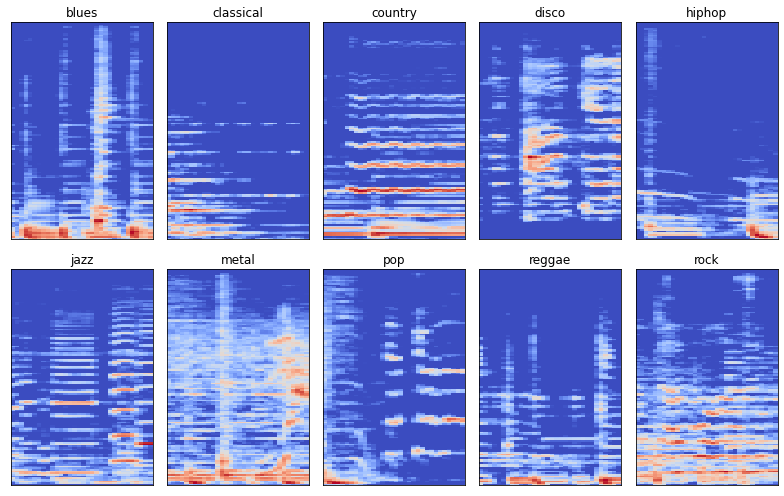

In [ ]:
create_spectrogram_plots(X_v, Y_v, encoder = le)

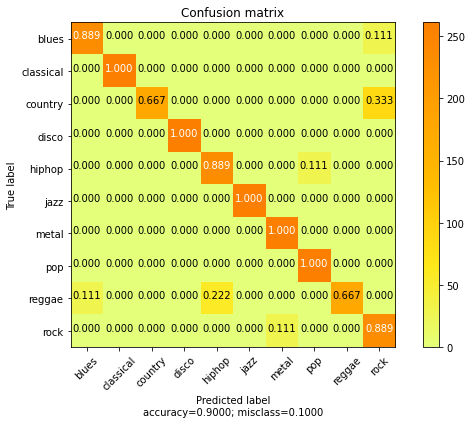

In [ ]:
cm = confusion_matrix(targets, preds)
plot_confusion_matrix(cm,le.classes_,title='Confusion matrix')

## **ALGORITHM APPLICATION FOR REAL CASE SCENARIOS**

In [ ]:
predict_yt('https://www.youtube.com/watch?v=Obim8BYGnOE', network = crnn, encoder = le, slice_len=32)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


The genre of the song "Till I Collapse" is: hiphop.


In [ ]:
predict_yt('https://www.youtube.com/watch?v=zVim3go8kso', network = crnn, encoder = le, slice_len=32)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


The genre of the song "Mellow Mood - Dance Inna Babylon (Official Video)" is: reggae.
